In [1]:
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import xgboost as xgb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, skew, pearsonr
import sklearn as sk
from sklearn import metrics
from datetime import datetime, date
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler,power_transform 
from collections import Counter
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, label_binarize
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, classification_report, accuracy_score, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import pickle
import warnings
from sklearn import datasets
%matplotlib inline

C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Import all libraries to use.

# Data Processing

In [2]:
df = pd.read_csv("Loan_data.csv",low_memory=False)
pd.set_option('display.max_columns', None)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,Aug-2018,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Using functions to import dataset and to extend the visible columns. There are categorical and numerical variables, NaN values and suspicion of the presence of unique values. Identification the dependent variable - loan_status and the potential independent variables.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


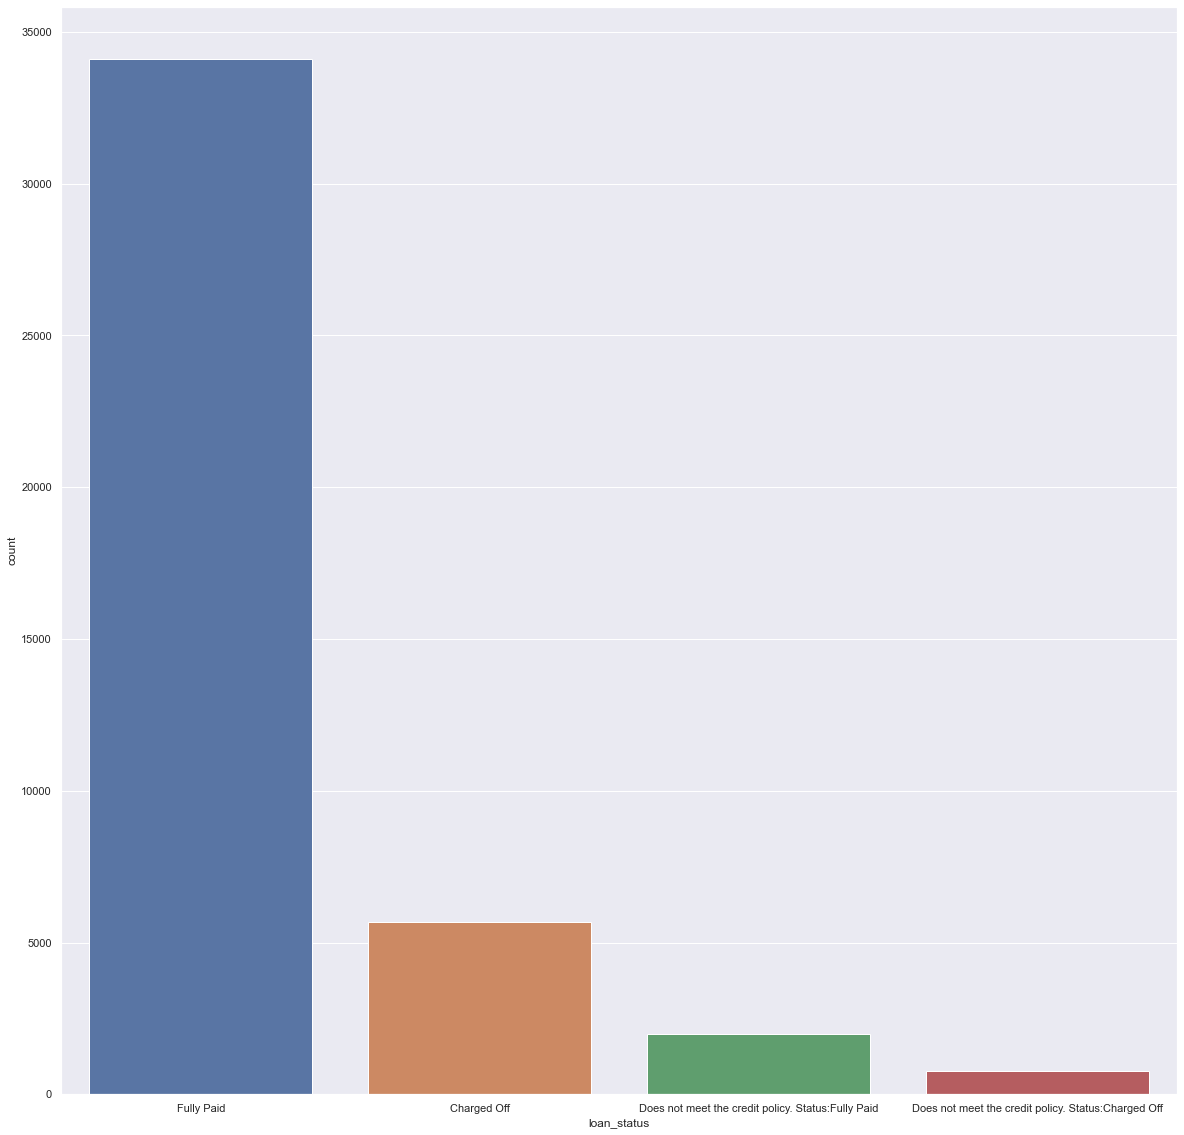

In [5]:
sns.countplot(data=df,x='loan_status')
sns.set(rc = {'figure.figsize':(20,20)})

Analysis of the dependent variable 'loan_status' plot: 
the variable have an information about amount of loans was fully Paid , charged off, fully paid but does not meet the credit policy and charged off with does not meet the credit policy.
For the purpose of the models, I combine two pairs of columns as two groups: 1-Fully Paid, 0-Charged Off, additionally changing the values to numeric type.

In [6]:
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'Fully Paid'
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'Charged Off'
df.loc[df['loan_status'] == 'Fully Paid', 'loan_status'] = int(1)
df.loc[df['loan_status'] == 'Charged Off', 'loan_status'] = int(0)

In [7]:
round(100*(df.isnull().sum()/len(df.index)),2)

id                         0.00
member_id                100.00
loan_amnt                  0.00
funded_amnt                0.00
funded_amnt_inv            0.00
                          ...  
settlement_status         99.62
settlement_date           99.62
settlement_amount         99.62
settlement_percentage     99.62
settlement_term           99.62
Length: 151, dtype: float64

Check the percentage of "null" values.

In [8]:
df.dropna(thresh=df.shape[0]*0.70,how='all',axis=1,inplace=True)

Decide to delete those variables, whose percentage of "null" is greater than 70% - variables nothing add to my model.

In [9]:
df = df.drop(['out_prncp','out_prncp_inv',
                'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
                'total_rec_late_fee','recoveries','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d',
                'last_fico_range_high','last_fico_range_low','chargeoff_within_12_mths','hardship_flag','debt_settlement_flag'], axis=1)

Delete variables that carry information from the future.

In [10]:
df = df.drop(['id', 'emp_title','issue_d','url','zip_code','earliest_cr_line','collection_recovery_fee',
                'collections_12_mths_ex_med','policy_code','title','sub_grade','addr_state'], axis=1)

Delete variables that add nothing to the model.

In [11]:
df.isna().sum()

loan_amnt                  1
funded_amnt                1
funded_amnt_inv            1
term                       1
int_rate                   1
installment                1
grade                      1
emp_length              1113
home_ownership             1
annual_inc                 5
verification_status        1
loan_status                1
pymnt_plan                 1
purpose                    1
dti                        1
delinq_2yrs               30
fico_range_low             1
fico_range_high            1
inq_last_6mths            30
open_acc                  30
pub_rec                   30
revol_bal                  1
revol_util                91
total_acc                 30
initial_list_status        1
application_type           1
acc_now_delinq            30
delinq_amnt               30
pub_rec_bankruptcies    1366
tax_liens                106
disbursement_method        1
dtype: int64

Check rest of the variables with amount of "null", see that one row in every columns is empty, so remove it.

In [12]:
df = df.dropna(axis=0, how='all') 

In [13]:
df.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length              1112
home_ownership             0
annual_inc                 4
verification_status        0
loan_status                0
pymnt_plan                 0
purpose                    0
dti                        0
delinq_2yrs               29
fico_range_low             0
fico_range_high            0
inq_last_6mths            29
open_acc                  29
pub_rec                   29
revol_bal                  0
revol_util                90
total_acc                 29
initial_list_status        0
application_type           0
acc_now_delinq            29
delinq_amnt               29
pub_rec_bankruptcies    1365
tax_liens                105
disbursement_method        0
dtype: int64

In [14]:
pd.set_option('display.max_columns', None)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,1,n,credit_card,27.65,0.0,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,f,Individual,0.0,0.0,0.0,0.0,Cash
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,0,n,car,1.00,0.0,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,f,Individual,0.0,0.0,0.0,0.0,Cash
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,1,n,small_business,8.72,0.0,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,f,Individual,0.0,0.0,0.0,0.0,Cash
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,1,n,other,20.00,0.0,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,f,Individual,0.0,0.0,0.0,0.0,Cash
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,1,n,other,17.94,0.0,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,f,Individual,0.0,0.0,0.0,0.0,Cash


Identify those variables, which values have to be converted to float by cutting off a "string" part.

In [15]:
df['term'] = df['term'].str.rstrip("months").astype(float) 
df['int_rate'] = df['int_rate'].str.rstrip("%").astype(float) 
df['revol_util'] = df['revol_util'].str.rstrip("%").astype(float) 
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method
0,5000.0,5000.0,4975.0,36.0,10.65,162.87,B,10+ years,RENT,24000.0,Verified,1,n,credit_card,27.65,0.0,735.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,f,Individual,0.0,0.0,0.0,0.0,Cash
1,2500.0,2500.0,2500.0,60.0,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,0,n,car,1.00,0.0,740.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,f,Individual,0.0,0.0,0.0,0.0,Cash
2,2400.0,2400.0,2400.0,36.0,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,1,n,small_business,8.72,0.0,735.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,f,Individual,0.0,0.0,0.0,0.0,Cash
3,10000.0,10000.0,10000.0,36.0,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,1,n,other,20.00,0.0,690.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,f,Individual,0.0,0.0,0.0,0.0,Cash
4,3000.0,3000.0,3000.0,60.0,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,1,n,other,17.94,0.0,695.0,699.0,0.0,15.0,0.0,27783.0,53.9,38.0,f,Individual,0.0,0.0,0.0,0.0,Cash


For variable - emp_length, have to use function below to convert to float.

In [16]:
def leave_only_digits(rec):
    new_rec = []
    if type(rec) == float:
        return rec
    for char in rec:
        if char.isdigit():
            new_rec.append(char)
    return int(''.join(new_rec))
df['emp_length'] = df.emp_length.apply(leave_only_digits)

pd.set_option('display.max_columns', None)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method
0,5000.0,5000.0,4975.0,36.0,10.65,162.87,B,10.0,RENT,24000.0,Verified,1,n,credit_card,27.65,0.0,735.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,f,Individual,0.0,0.0,0.0,0.0,Cash
1,2500.0,2500.0,2500.0,60.0,15.27,59.83,C,1.0,RENT,30000.0,Source Verified,0,n,car,1.00,0.0,740.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,f,Individual,0.0,0.0,0.0,0.0,Cash
2,2400.0,2400.0,2400.0,36.0,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,1,n,small_business,8.72,0.0,735.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,f,Individual,0.0,0.0,0.0,0.0,Cash
3,10000.0,10000.0,10000.0,36.0,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,1,n,other,20.00,0.0,690.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,f,Individual,0.0,0.0,0.0,0.0,Cash
4,3000.0,3000.0,3000.0,60.0,12.69,67.79,B,1.0,RENT,80000.0,Source Verified,1,n,other,17.94,0.0,695.0,699.0,0.0,15.0,0.0,27783.0,53.9,38.0,f,Individual,0.0,0.0,0.0,0.0,Cash


In [17]:
df.shape

(42535, 31)

For now -> 31 columns and 42535 rows

In [18]:
df.loc[:,df.nunique()==1]

,pymnt_plan,initial_list_status,application_type,disbursement_method
0,n,f,Individual,Cash
1,n,f,Individual,Cash
2,n,f,Individual,Cash
3,n,f,Individual,Cash
4,n,f,Individual,Cash
...,...,...,...,...
42531,n,f,Individual,Cash
42532,n,f,Individual,Cash
42533,n,f,Individual,Cash
42534,n,f,Individual,Cash


Identify unique values - one and the same value for all observations. Delete 4 variables - don't contribute any significant information to the model.

In [19]:
df = df.drop(['pymnt_plan', 'initial_list_status','application_type','disbursement_method'], axis=1)

Using histograms to illustrate the variables with missing values to fill all "null" with median or the most common value or other decision, depending on the distribution of values.

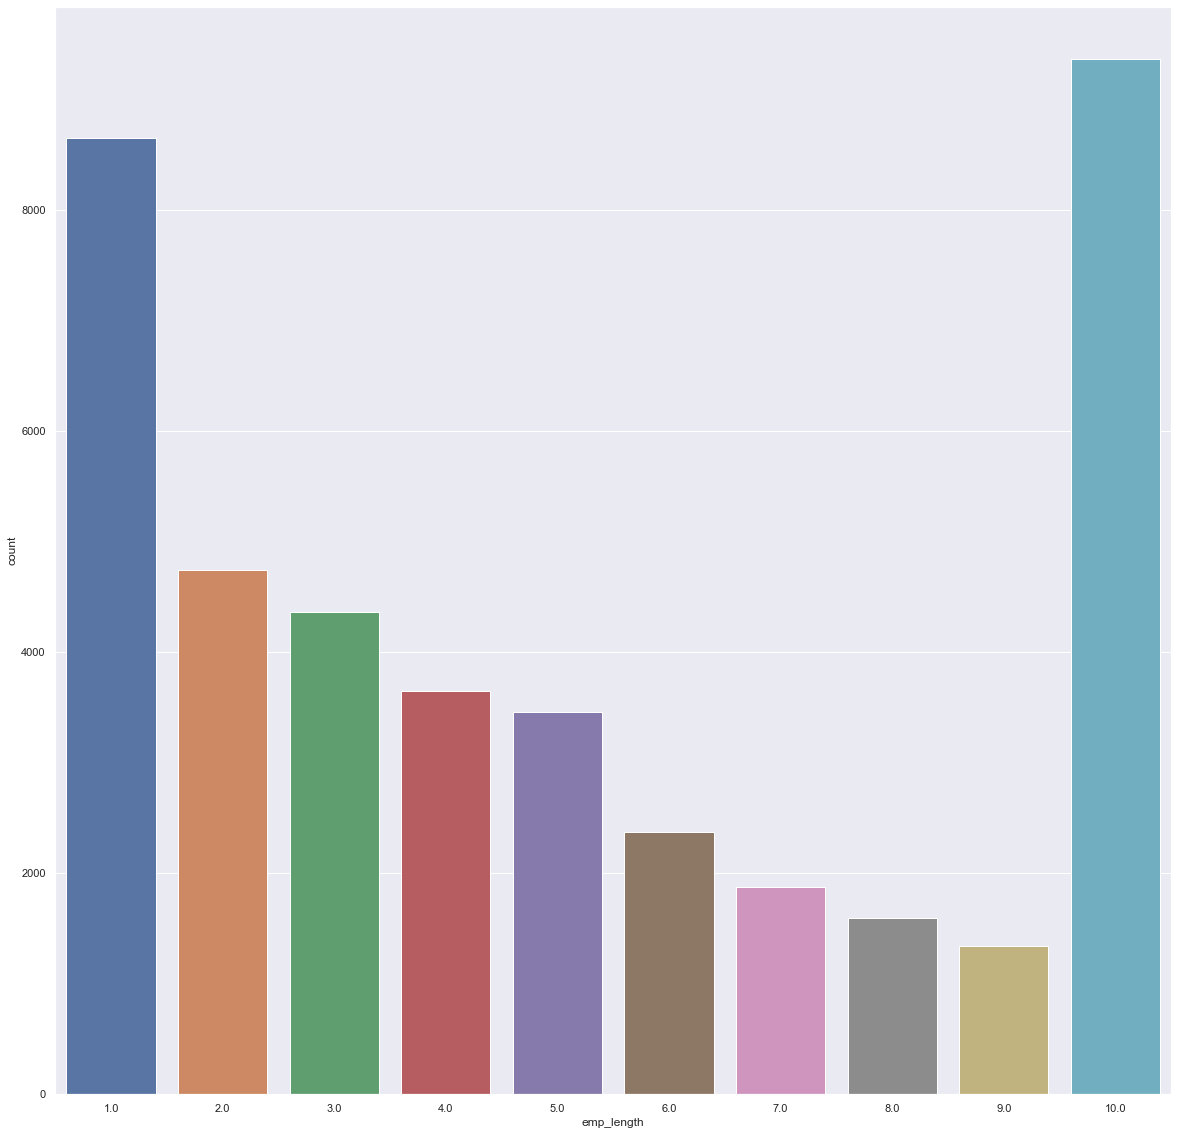

In [20]:
sns.countplot(data=df,x='emp_length')
sns.set(rc = {'figure.figsize':(20,20)})

In [21]:
df.emp_length.fillna(df.emp_length.median(),inplace = True)

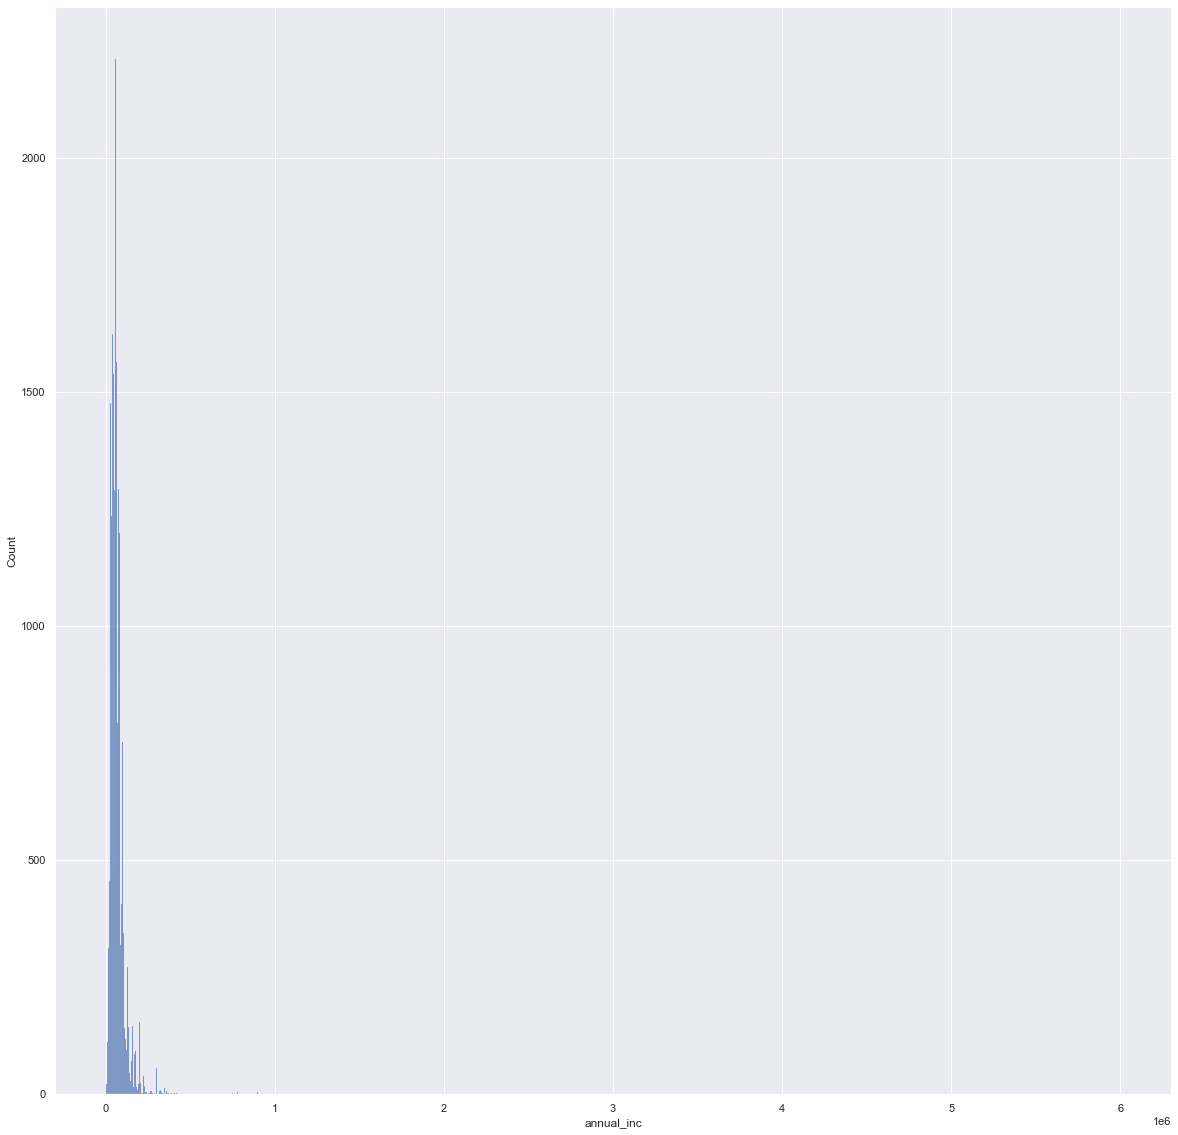

In [22]:
sns.histplot(data=df,x='annual_inc')
sns.set(rc = {'figure.figsize':(20,20)})

In [23]:
df.annual_inc.fillna(df.annual_inc.median(),inplace = True)

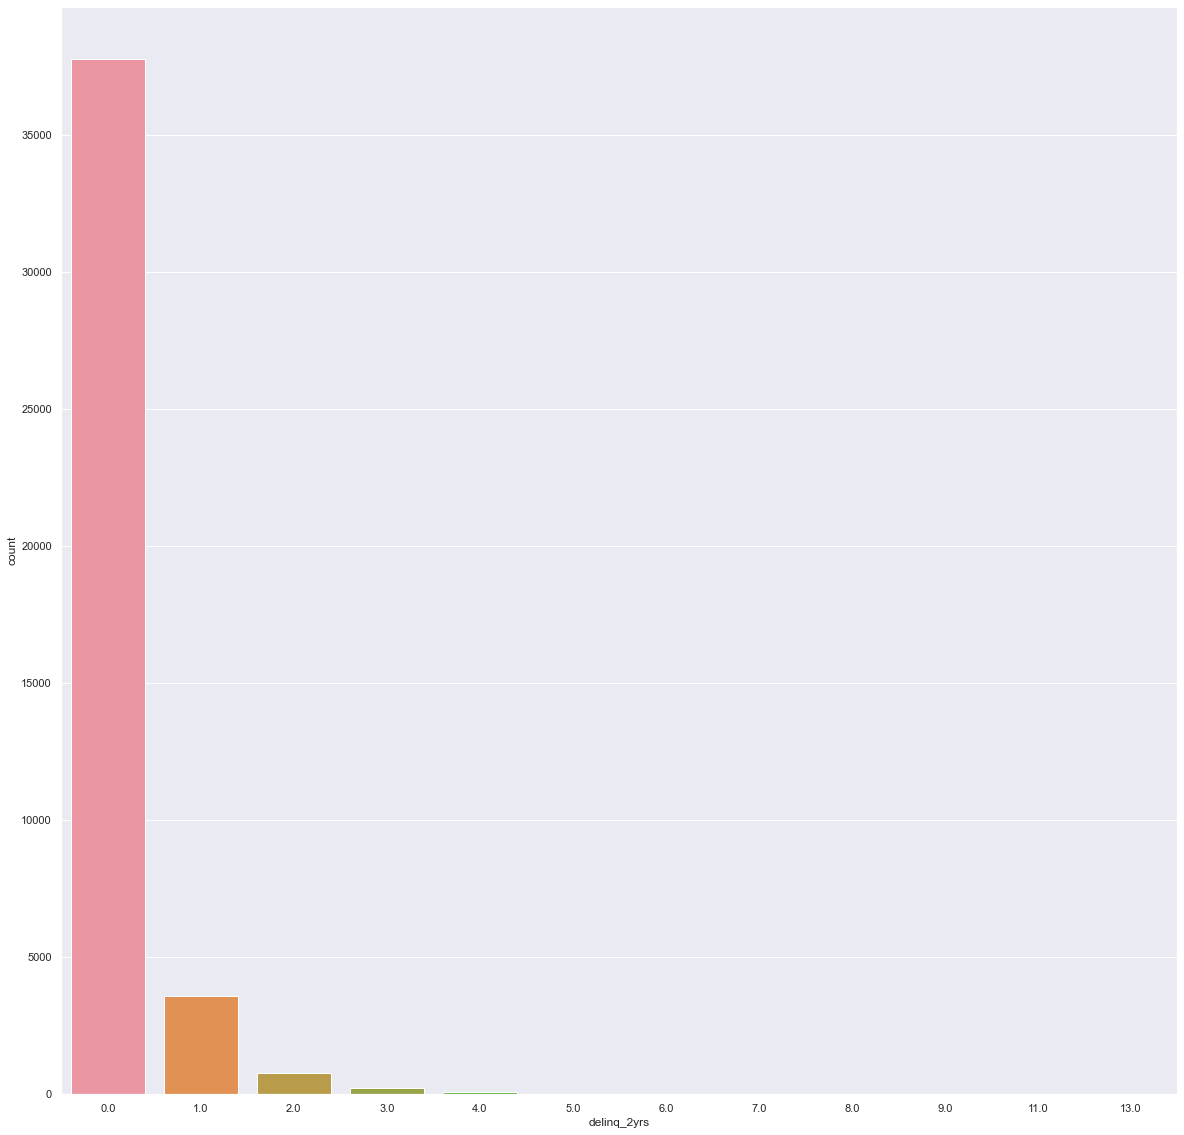

In [24]:
sns.countplot(data=df,x='delinq_2yrs')
sns.set(rc = {'figure.figsize':(20,20)})

In [25]:
df.delinq_2yrs.fillna(df.delinq_2yrs.median(),inplace = True)

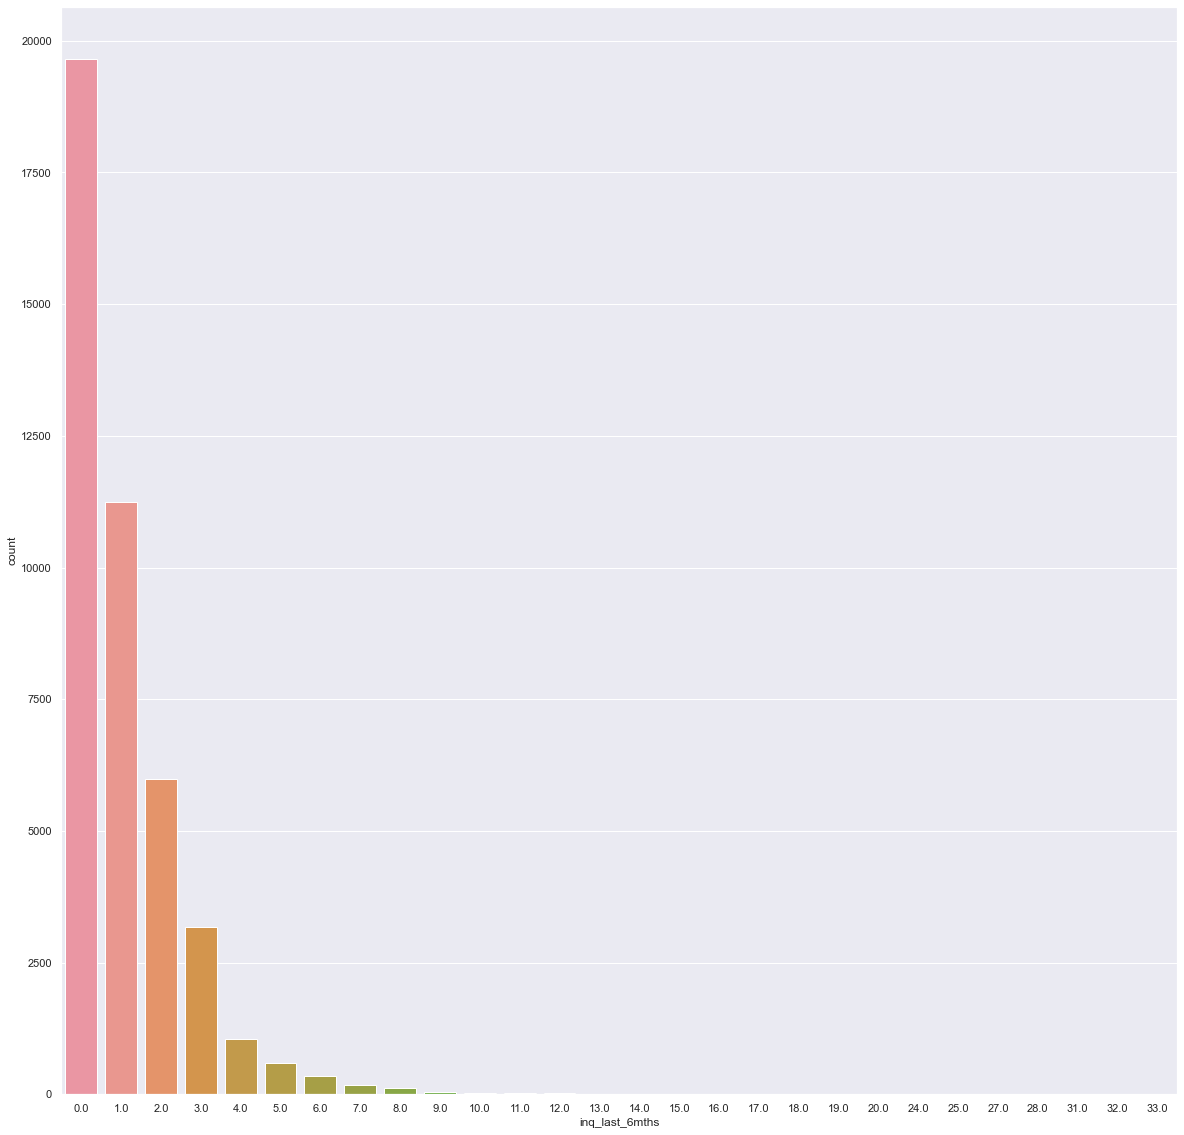

In [26]:
sns.countplot(data=df,x='inq_last_6mths')
sns.set(rc = {'figure.figsize':(20,20)})

In [27]:
df.inq_last_6mths.fillna(df.inq_last_6mths.median(),inplace = True)

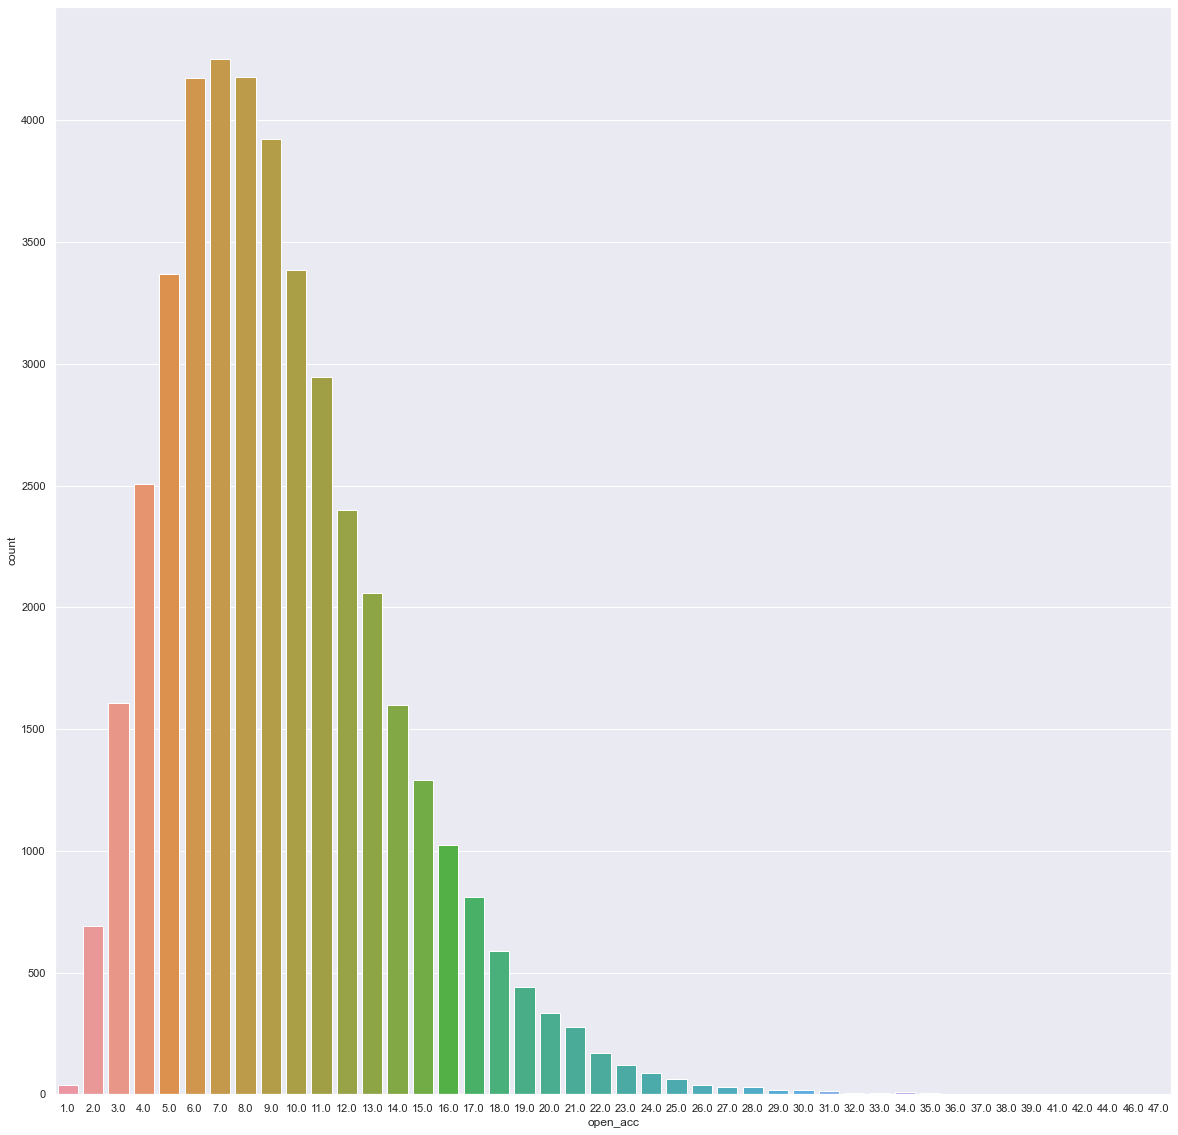

In [28]:
sns.countplot(data=df,x='open_acc')
sns.set(rc = {'figure.figsize':(20,20)})

In [29]:
df.open_acc.fillna(df.open_acc.median(),inplace = True)

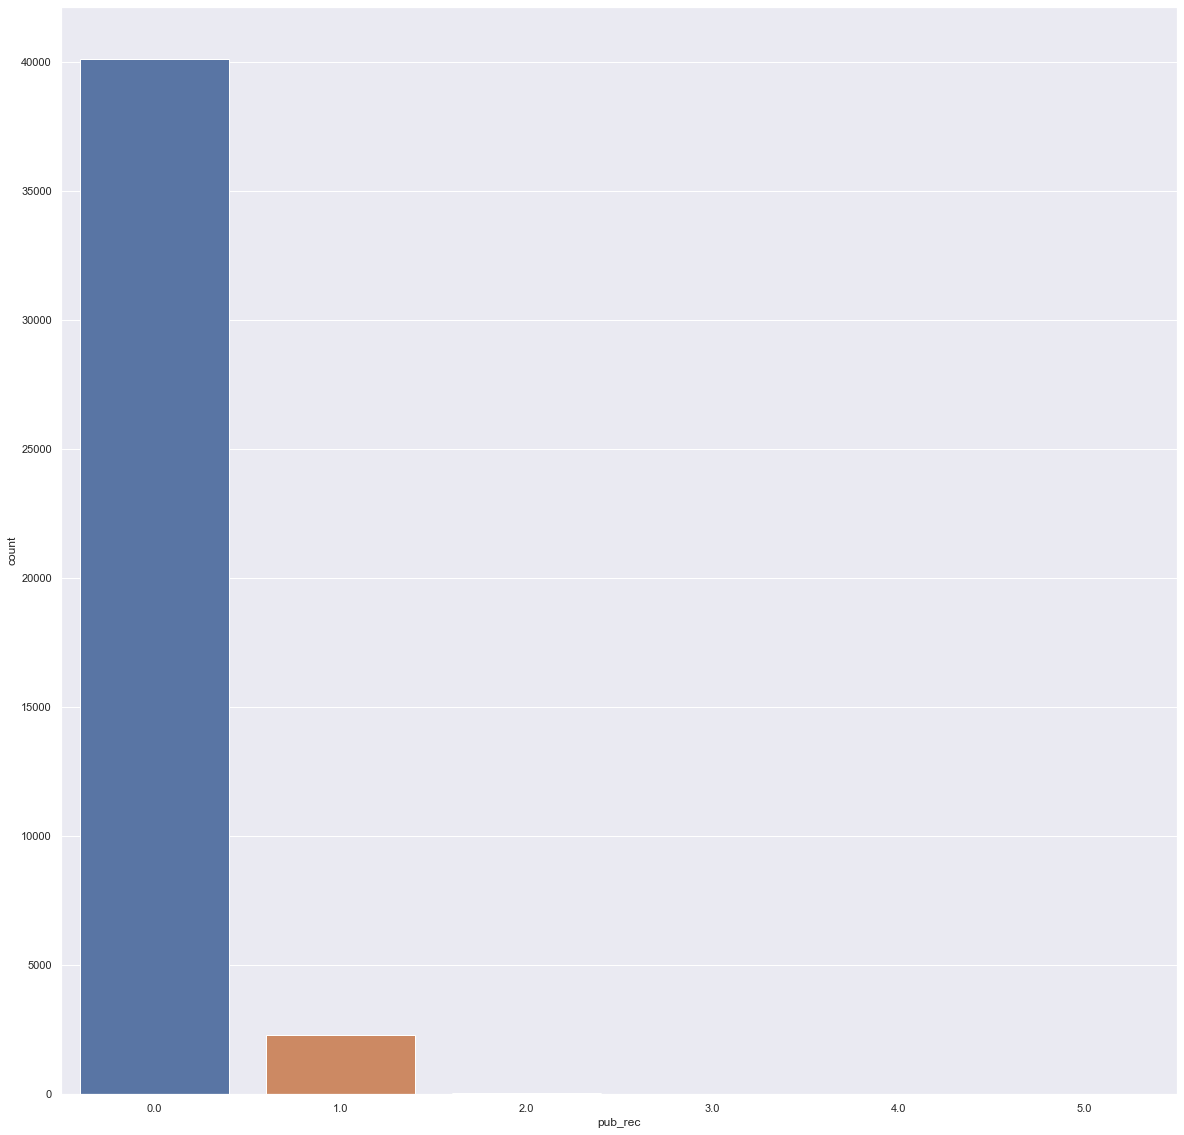

In [30]:
sns.countplot(data=df,x='pub_rec')
sns.set(rc = {'figure.figsize':(20,20)})

In [31]:
df['pub_rec'].fillna(0.0, inplace = True) 

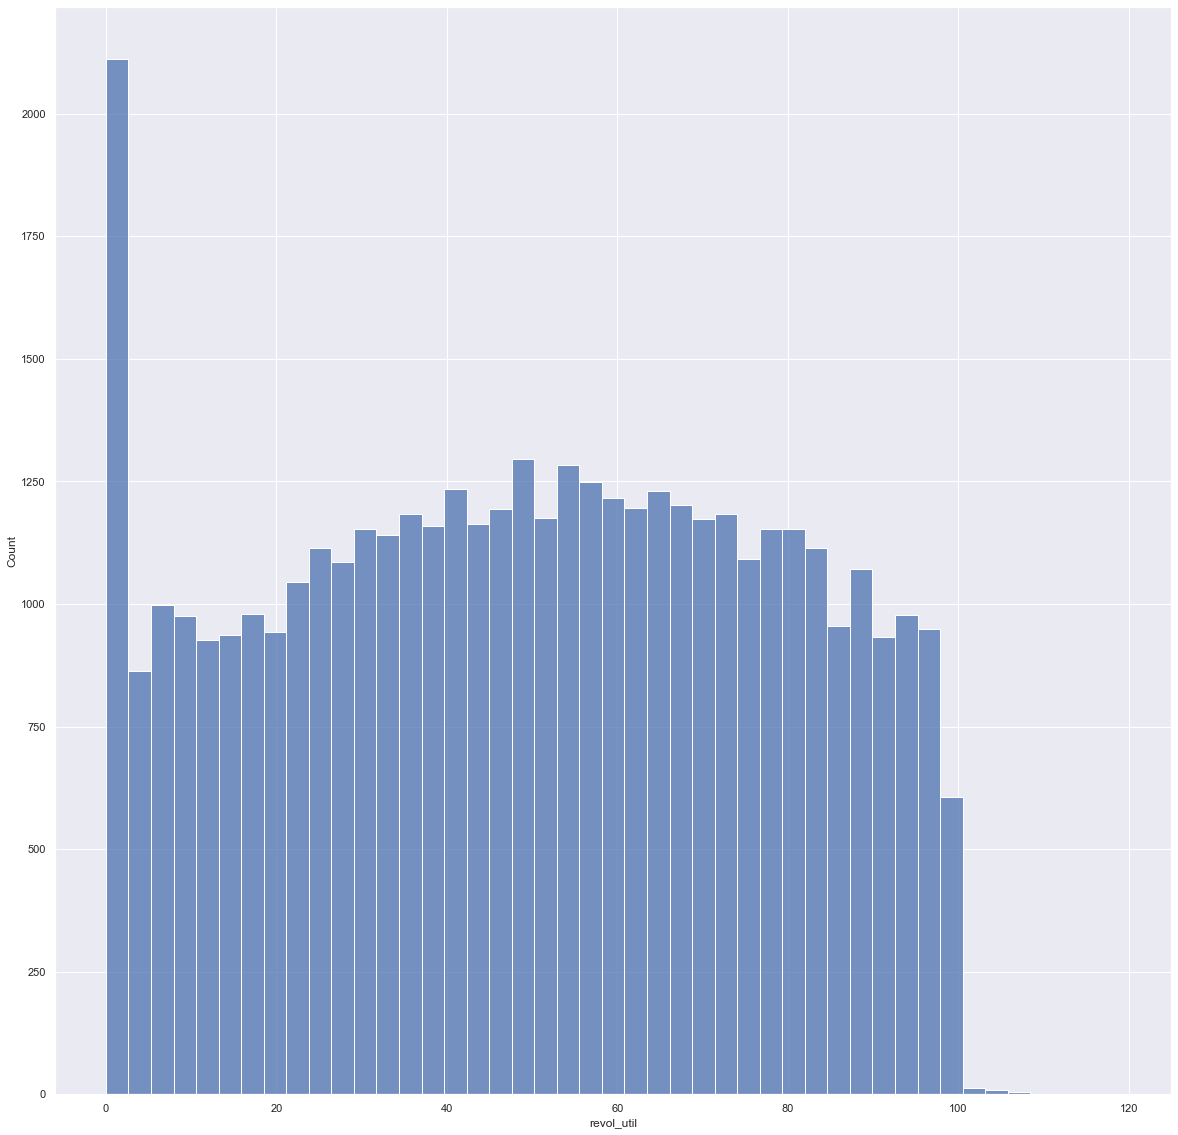

In [32]:
sns.histplot(data=df,x='revol_util')
sns.set(rc = {'figure.figsize':(20,20)})

In [33]:
df.revol_util.fillna(df.revol_util.median(),inplace = True)

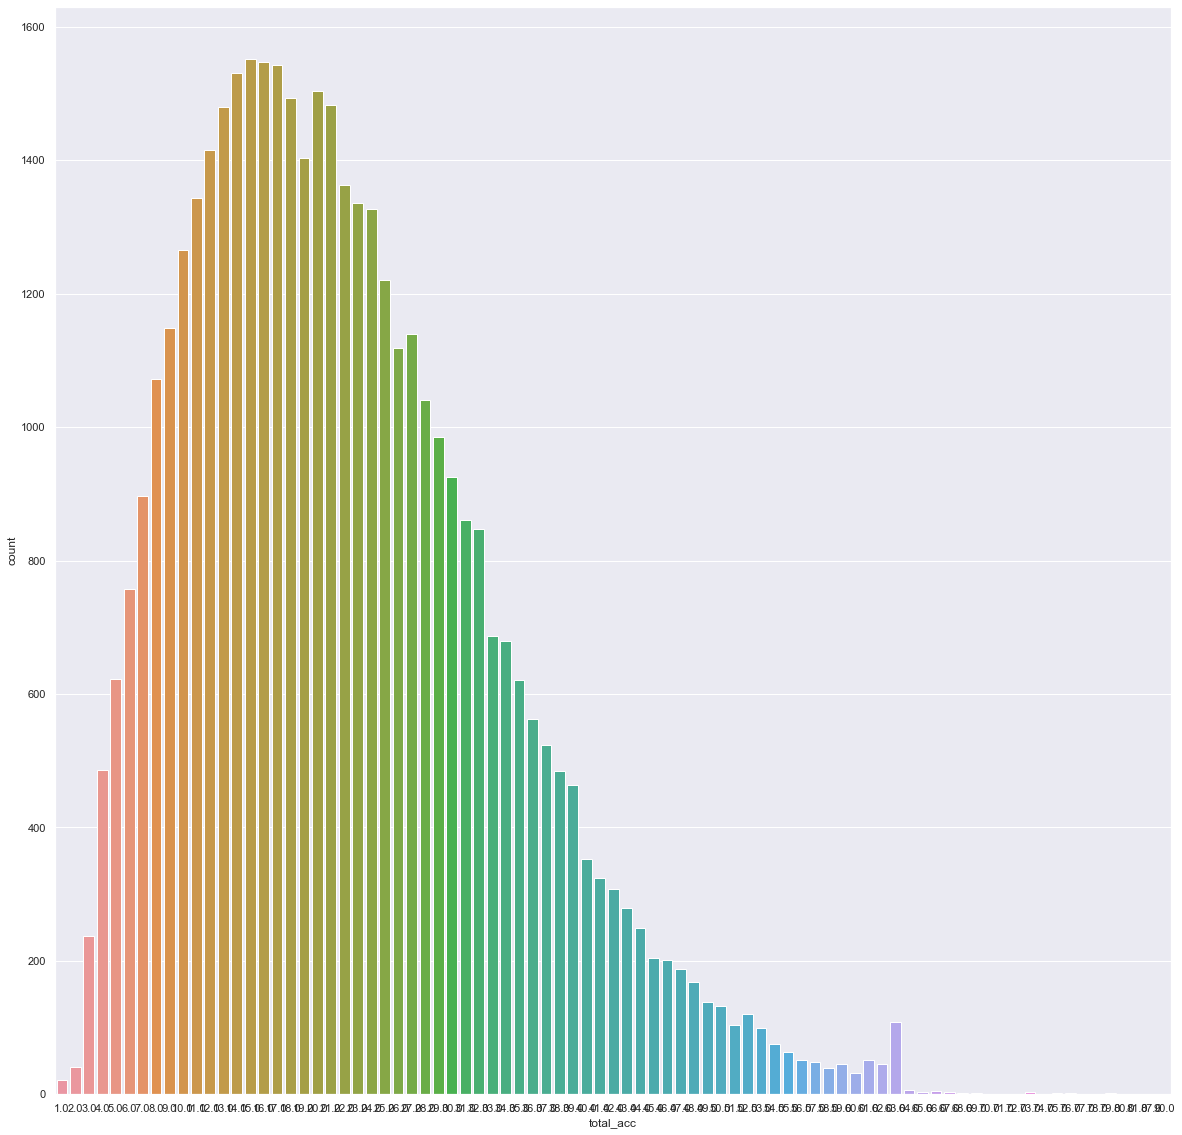

In [34]:
sns.countplot(data=df,x='total_acc')
sns.set(rc = {'figure.figsize':(20,20)})

In [35]:
df.total_acc.fillna(df.total_acc.median(),inplace = True)

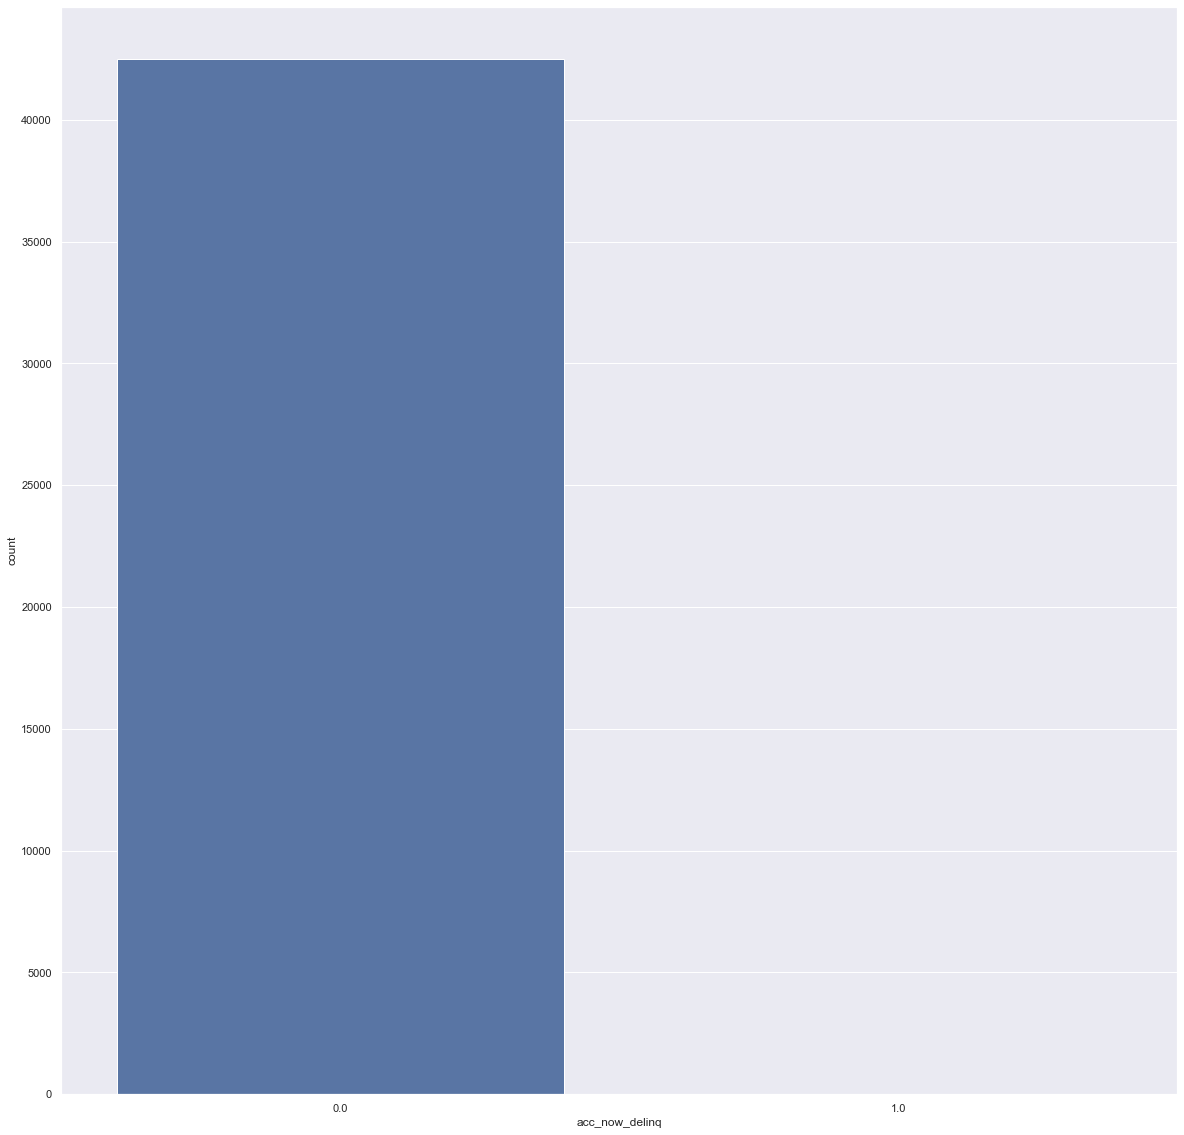

In [36]:
sns.countplot(data=df,x='acc_now_delinq')
sns.set(rc = {'figure.figsize':(20,20)})

In [37]:
df = df.drop(['acc_now_delinq'], axis=1)

Remove variable due to a single value of 1.0

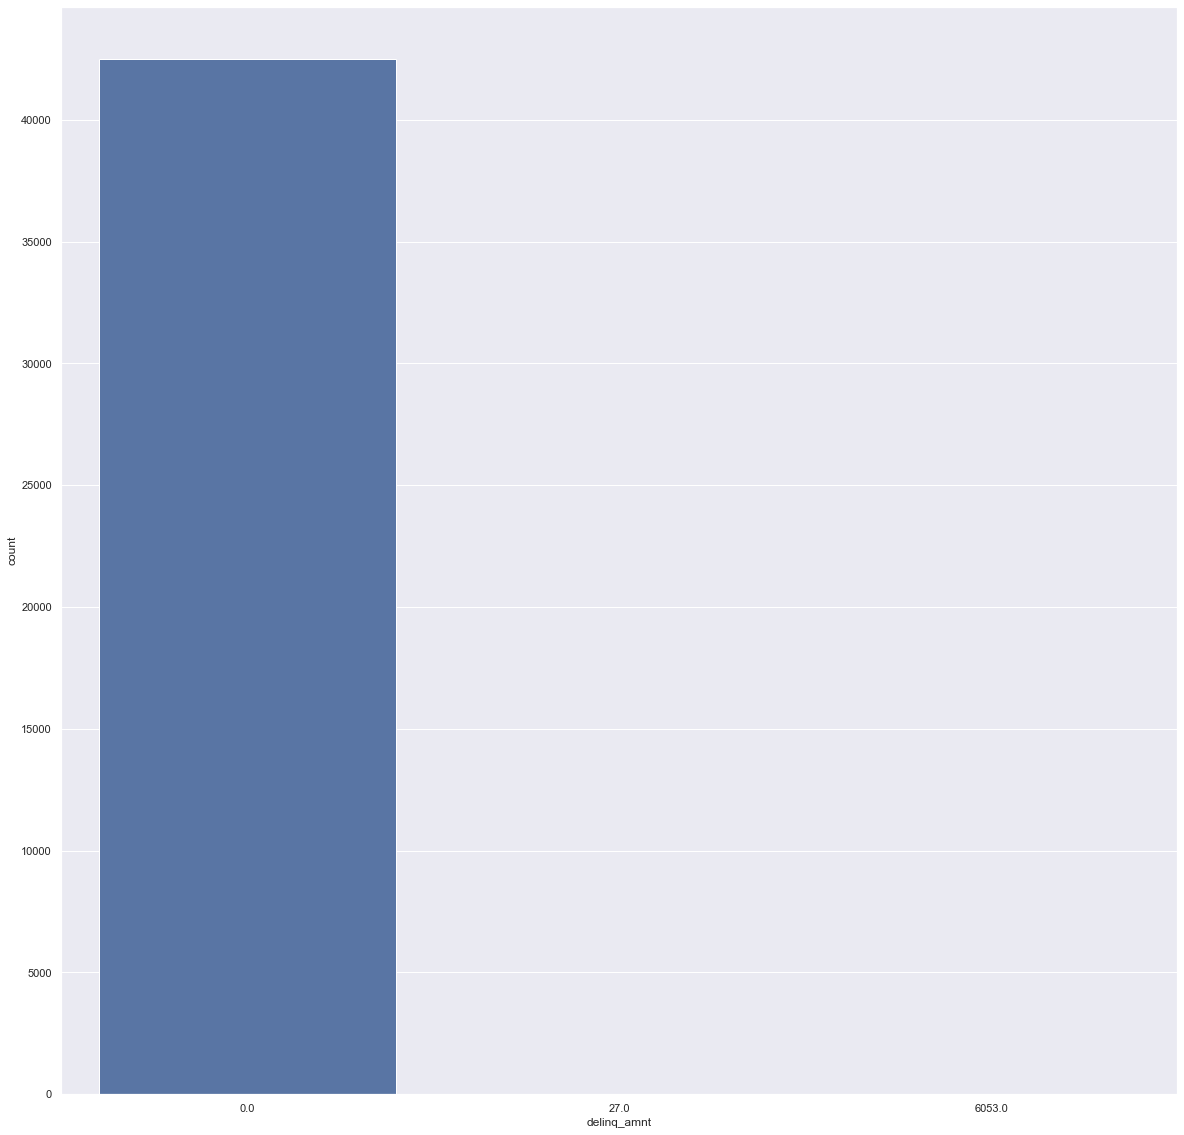

In [38]:
sns.countplot(data=df,x='delinq_amnt')
sns.set(rc = {'figure.figsize':(20,20)})

In [39]:
df = df.drop(['delinq_amnt'], axis=1)

Remove variable due to a single values of 27.0 and 6053.0

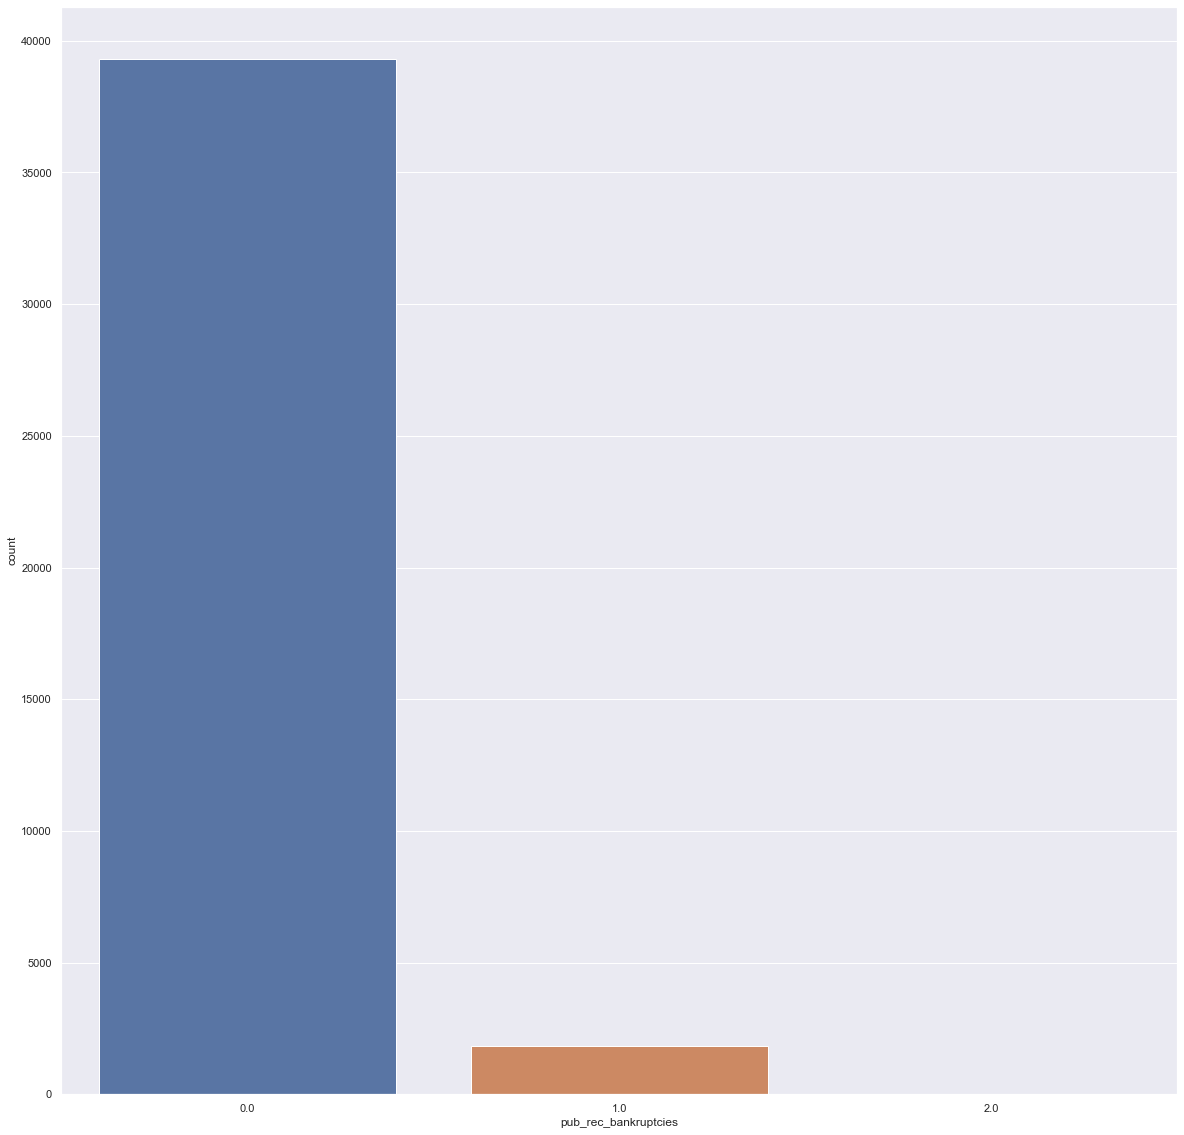

In [40]:
sns.countplot(data=df,x='pub_rec_bankruptcies')
sns.set(rc = {'figure.figsize':(20,20)})

In [41]:
df['pub_rec_bankruptcies'].fillna(0.0, inplace = True) 

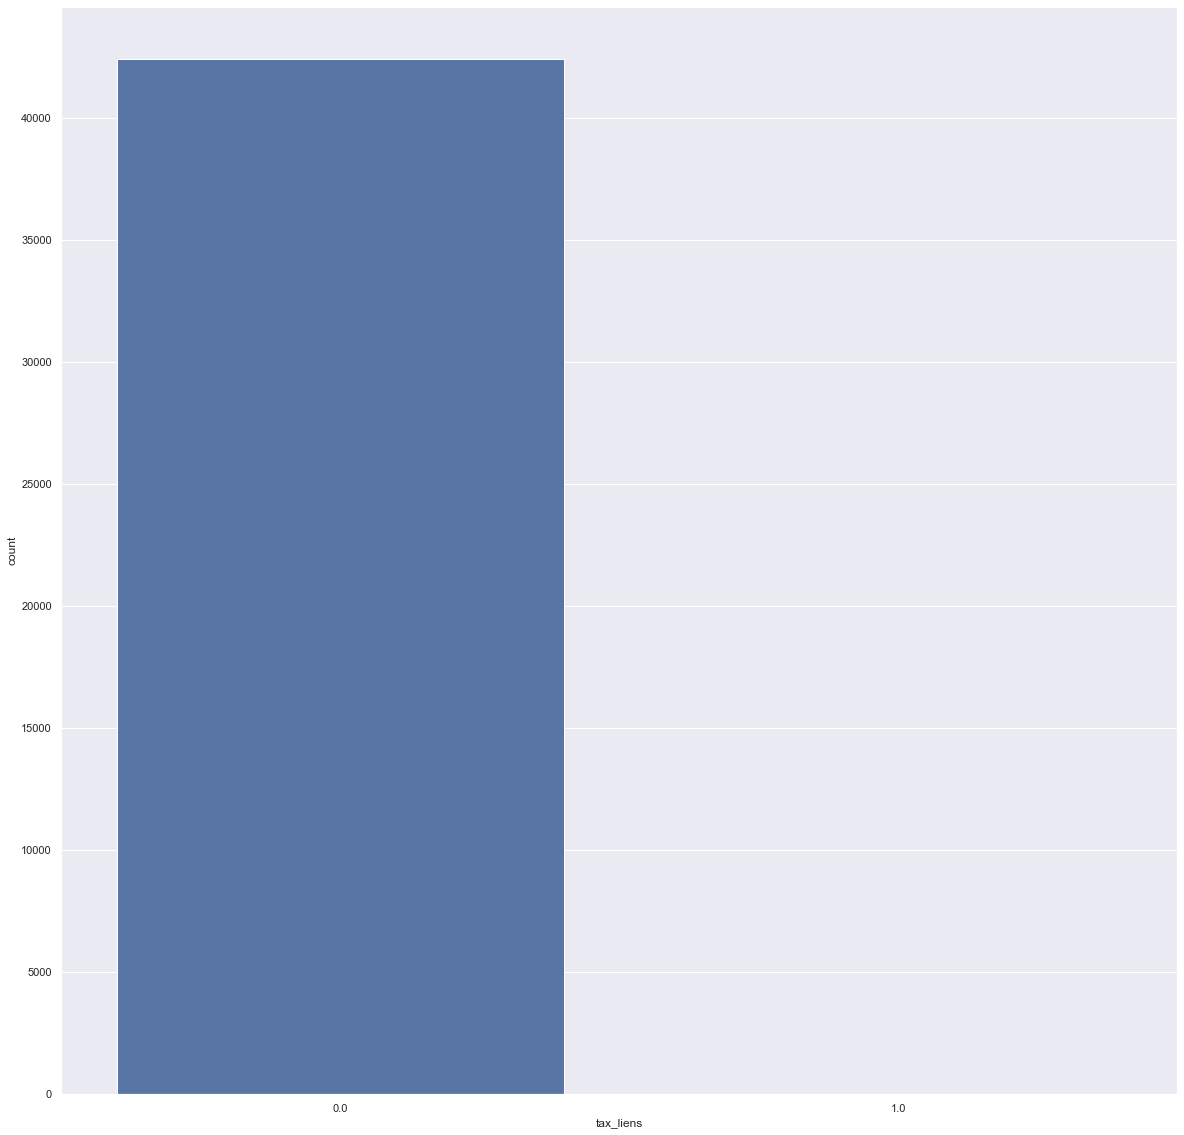

In [42]:
sns.countplot(data=df,x='tax_liens')
sns.set(rc = {'figure.figsize':(20,20)})

In [43]:
df = df.drop(['tax_liens'], axis=1)

Remove variable due to a single value of 1.0

In [44]:
df.isna().sum()

loan_amnt               0
funded_amnt             0
funded_amnt_inv         0
term                    0
int_rate                0
installment             0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
delinq_2yrs             0
fico_range_low          0
fico_range_high         0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
pub_rec_bankruptcies    0
dtype: int64

Check that all columns have full values and all "null" have been filled.

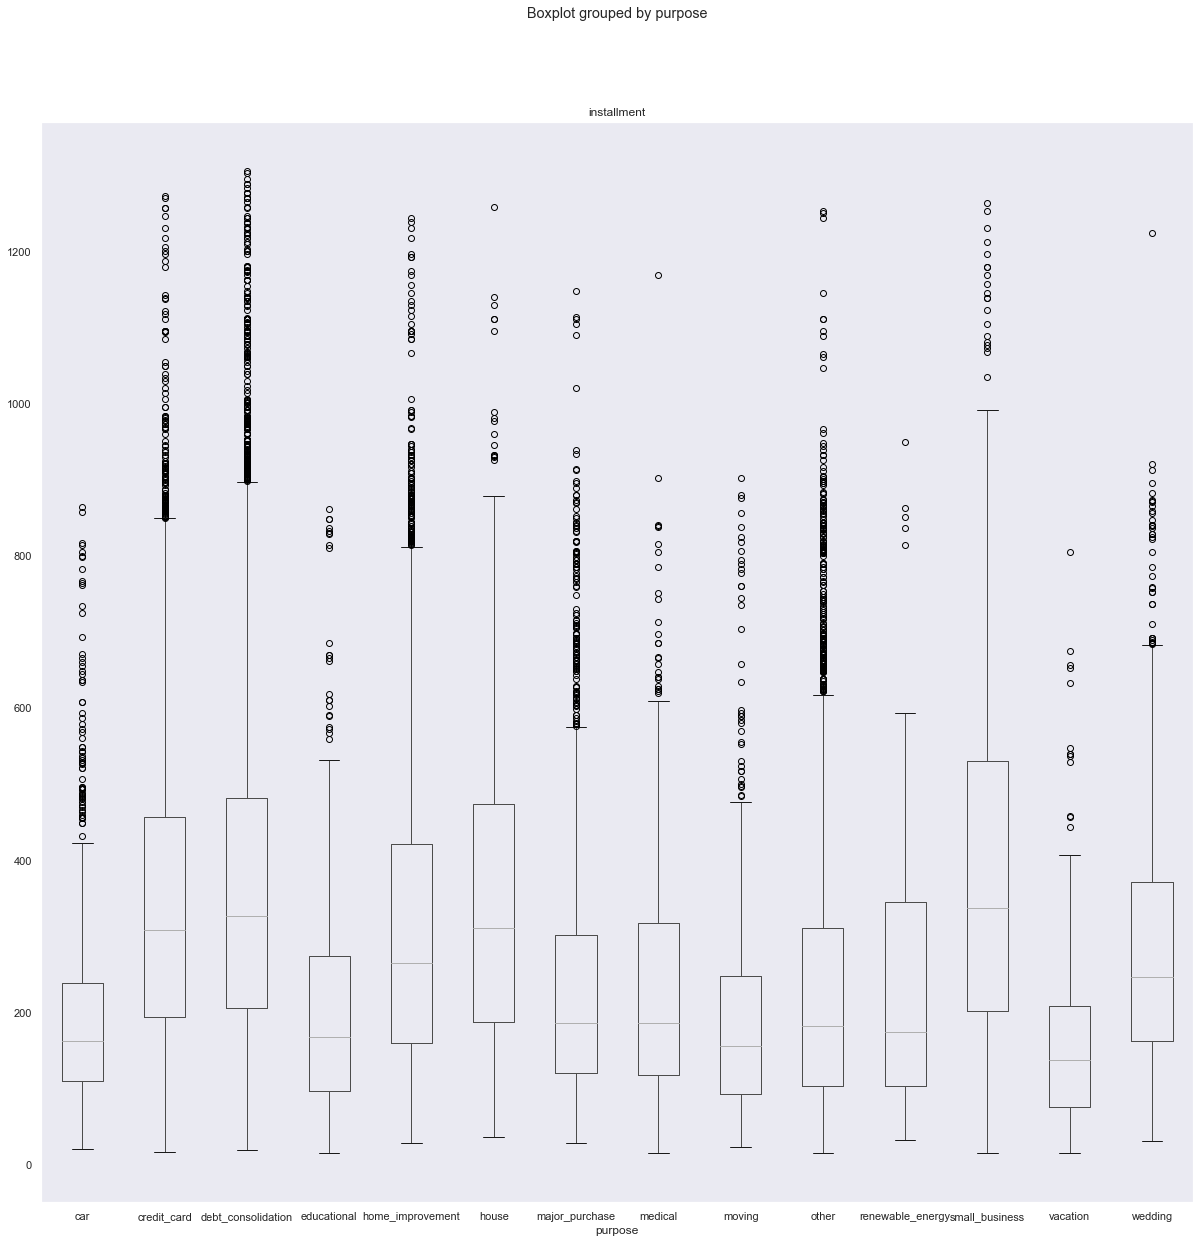

In [45]:
df.boxplot(by ='purpose', column =['installment'], grid = False)
sns.set(rc = {'figure.figsize':(20,20)})

The boxplot of outliers for variable "installment" divided by purpose. The least amount of outliers with variable installment is in case of purpose for renewable energy.

<AxesSubplot:title={'center':'int_rate'}, xlabel='grade'>

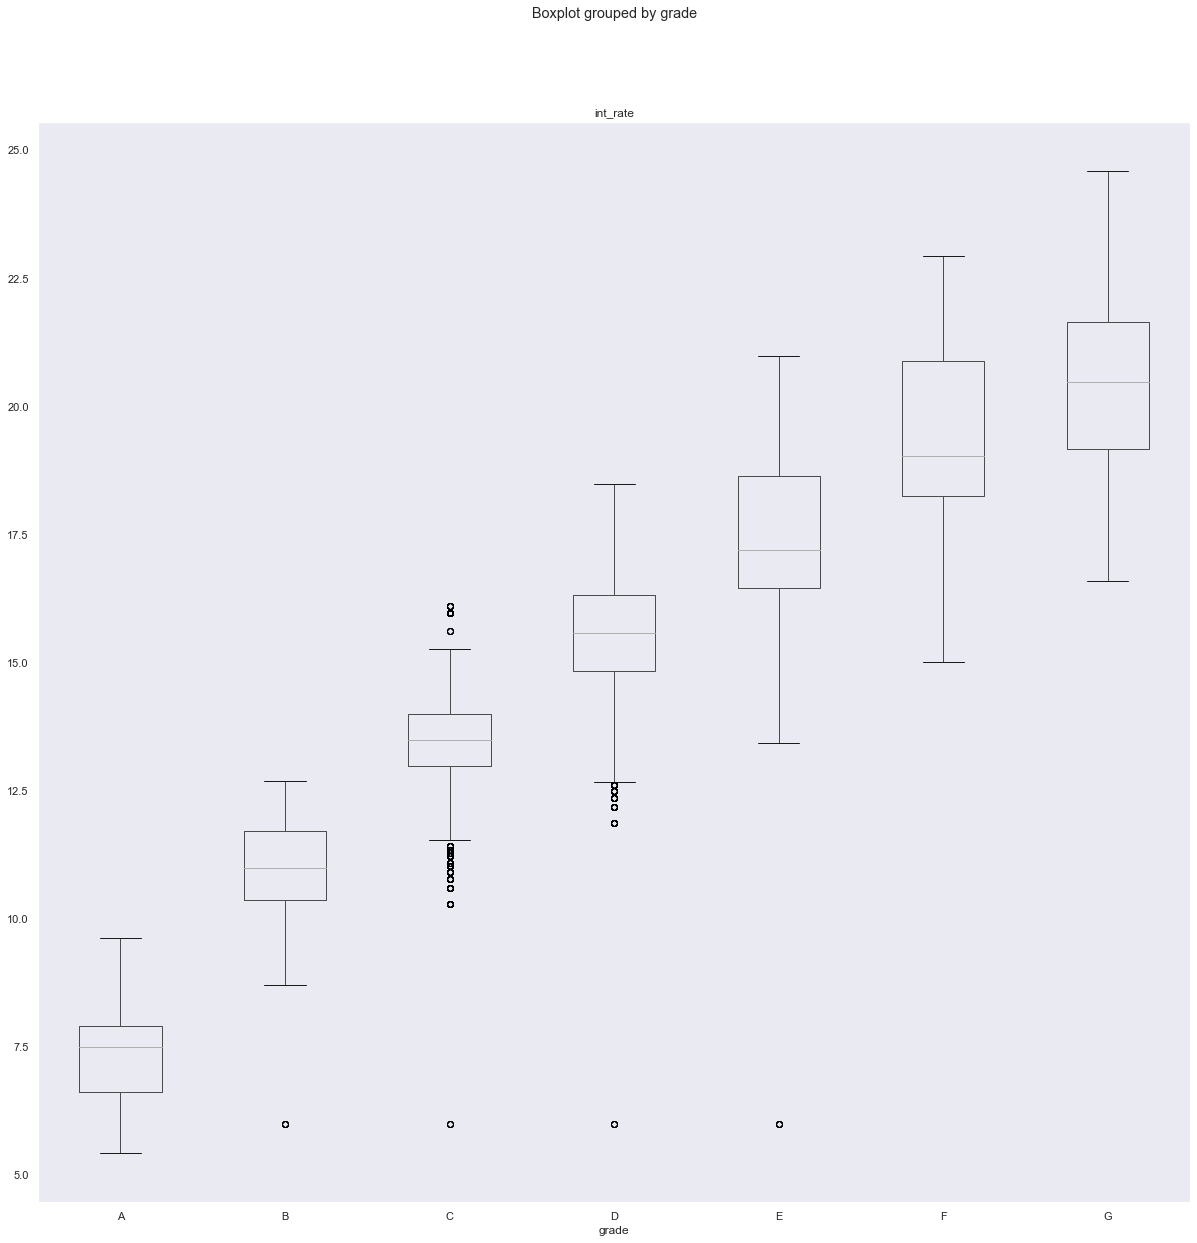

In [46]:
df.boxplot(by ='grade', column =['int_rate'], grid = False)

The boxplot of outliers for variable "int_rate" divided by grade. The most amount of outliers with variable interest rate is in case of C grade.

<AxesSubplot:title={'center':'loan_amnt'}, xlabel='emp_length'>

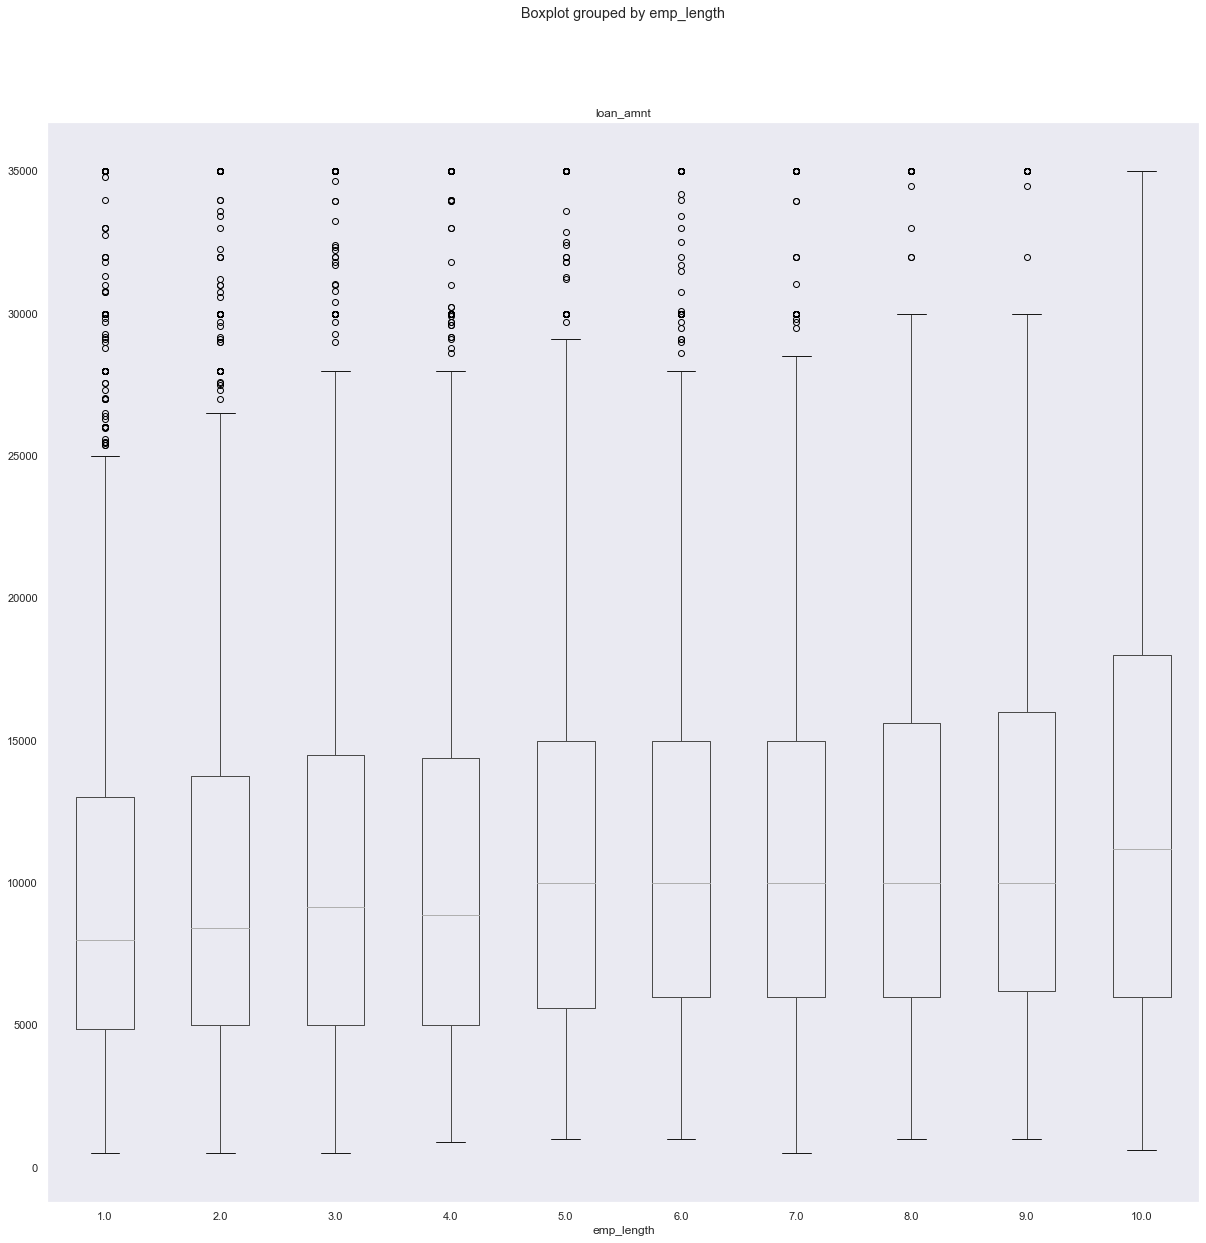

In [47]:
df.boxplot(by ='emp_length', column =['loan_amnt'], grid = False)

The boxplot of outliers for variable "loan_amnt" divided by length of employment. Outliers are equal distribution in any length of employment. 

# EDA - Exploratory Data Analysis

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,42535.0,11089.722581,7410.938391,500.00,5200.00,9700.00,15000.00,35000.00
funded_amnt,42535.0,10821.585753,7146.914675,500.00,5000.00,9600.00,15000.00,35000.00
funded_amnt_inv,42535.0,10139.938785,7131.598014,0.00,4950.00,8500.00,14000.00,35000.00
term,42535.0,42.207218,10.509342,36.00,36.00,36.00,60.00,60.00
int_rate,42535.0,12.165016,3.707936,5.42,9.63,11.99,14.72,24.59
installment,42535.0,322.623063,208.927216,15.67,165.52,277.69,428.18,1305.19
emp_length,42535.0,5.017962,3.370809,1.00,2.00,4.00,9.00,10.00
annual_inc,42535.0,69135.603176,64093.411134,1896.00,40000.00,59000.00,82500.00,6000000.00
dti,42535.0,13.373043,6.726315,0.00,8.20,13.47,18.68,29.99
delinq_2yrs,42535.0,0.152345,0.512247,0.00,0.00,0.00,0.00,13.00


Function shows the values of the basic statistics for each column.

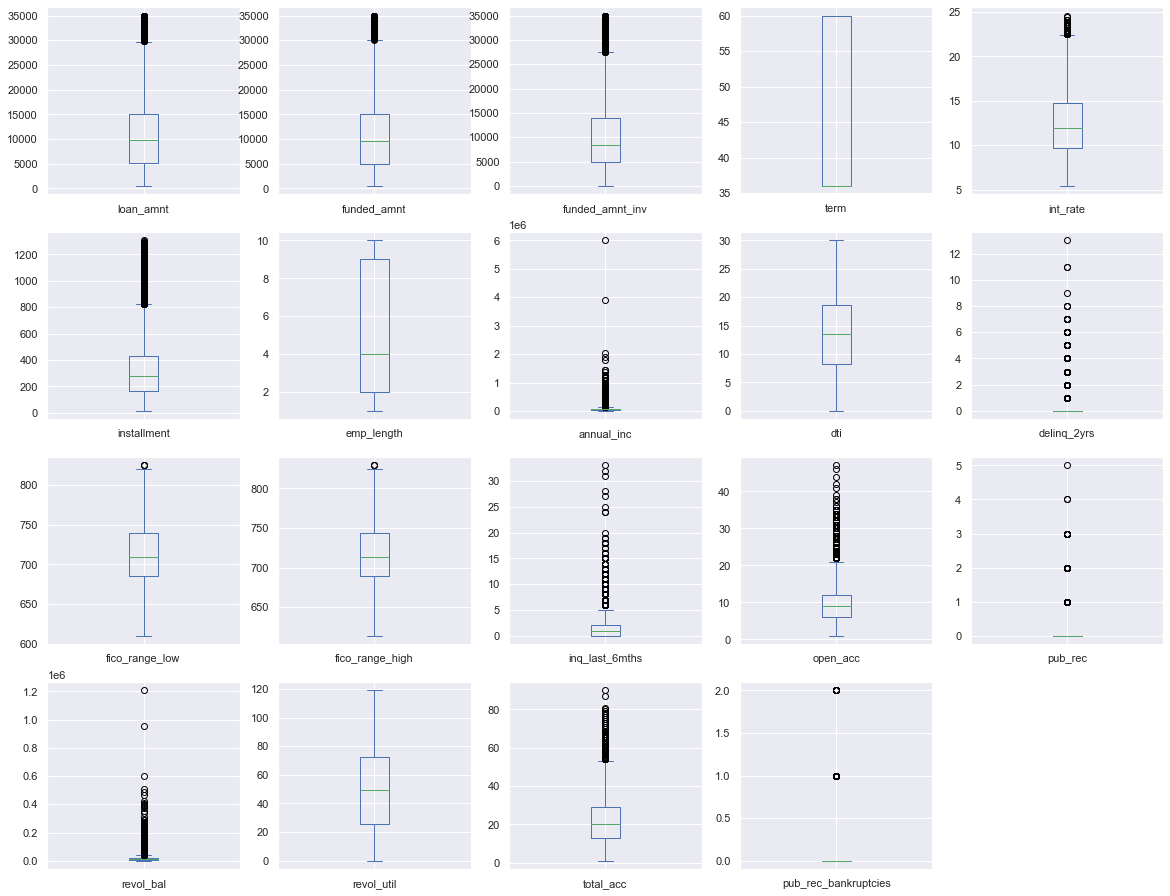

In [49]:
df.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False)
plt.show()

Function shows a set of box plots determining outliers for all variables individually.

In [50]:
z = np.abs(stats.zscore(df.annual_inc))
len(z[z>5]) 

118

Calculate zscore - the deviation

In [51]:
df =df[(np.abs(stats.zscore(df.select_dtypes(include = np.number))) < 5).all(axis=1)]

Delete all values, where zscore below 5.

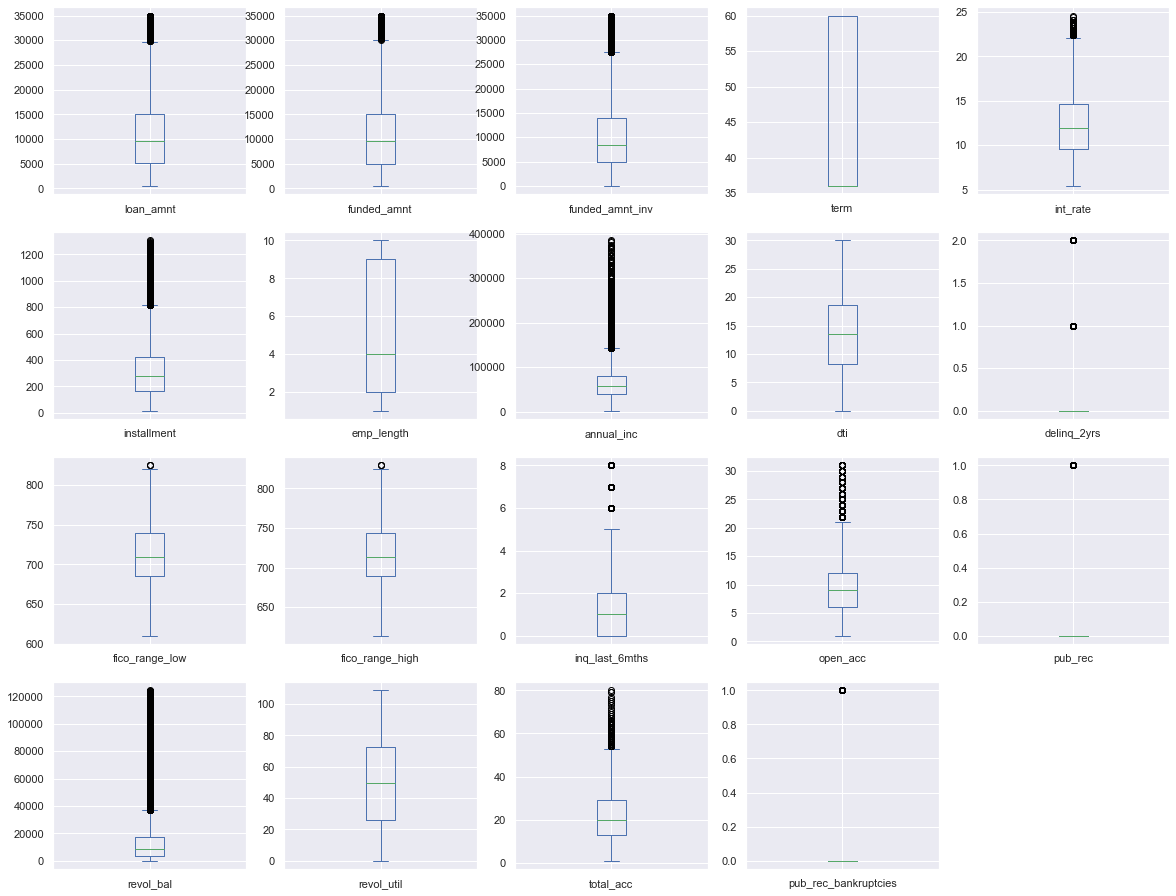

In [52]:
df.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False)
plt.show()

In [53]:
new_cols = [col for col in df.columns if col != 'loan_status'] + ['loan_status']
df = df[new_cols]

In [54]:
pd.set_option('display.max_columns', None)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,loan_status
0,5000.0,5000.0,4975.0,36.0,10.65,162.87,B,10.0,RENT,24000.0,Verified,credit_card,27.65,0.0,735.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,0.0,1
1,2500.0,2500.0,2500.0,60.0,15.27,59.83,C,1.0,RENT,30000.0,Source Verified,car,1.00,0.0,740.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,0.0,0
2,2400.0,2400.0,2400.0,36.0,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,small_business,8.72,0.0,735.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,0.0,1
3,10000.0,10000.0,10000.0,36.0,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,other,20.00,0.0,690.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,0.0,1
4,3000.0,3000.0,3000.0,60.0,12.69,67.79,B,1.0,RENT,80000.0,Source Verified,other,17.94,0.0,695.0,699.0,0.0,15.0,0.0,27783.0,53.9,38.0,0.0,1


Text(0.5, 1.0, 'Correlation between features')

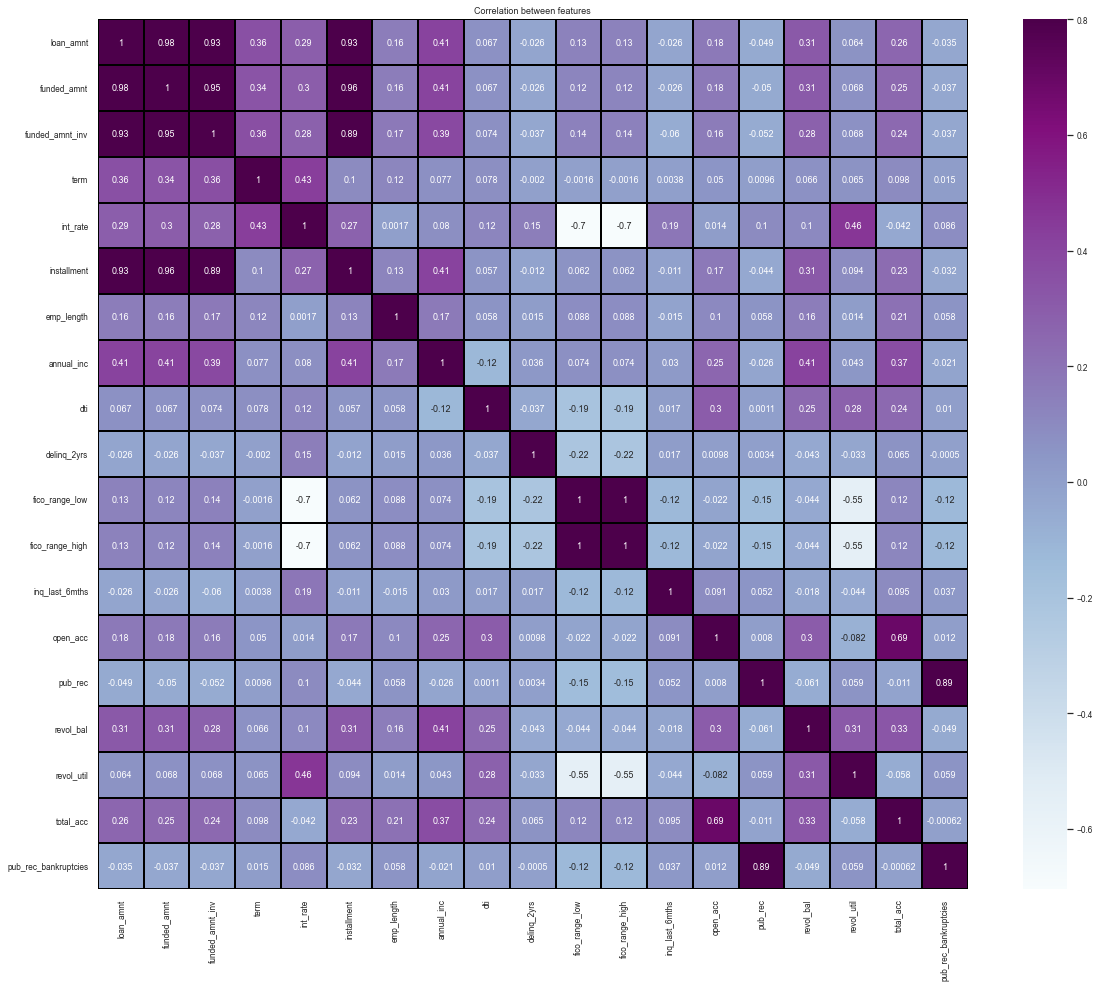

In [55]:
corr_all = df.corr()
sns.set(font_scale=0.75)
plt.figure(figsize = (20,16))

sns.heatmap(corr_all, vmax=.8, linewidths=0.01,square = True, annot = True, cmap="BuPu",linecolor="black")
plt.title('Correlation between features')

Analysis of the correlation matrix - remove variables that are too correlated with each other in order not to duplicate the same information.

In [56]:
df = df.drop(['fico_range_high', 'installment','funded_amnt_inv','loan_amnt','pub_rec'], axis=1)

Text(0.5, 1.0, 'Correlation between features')

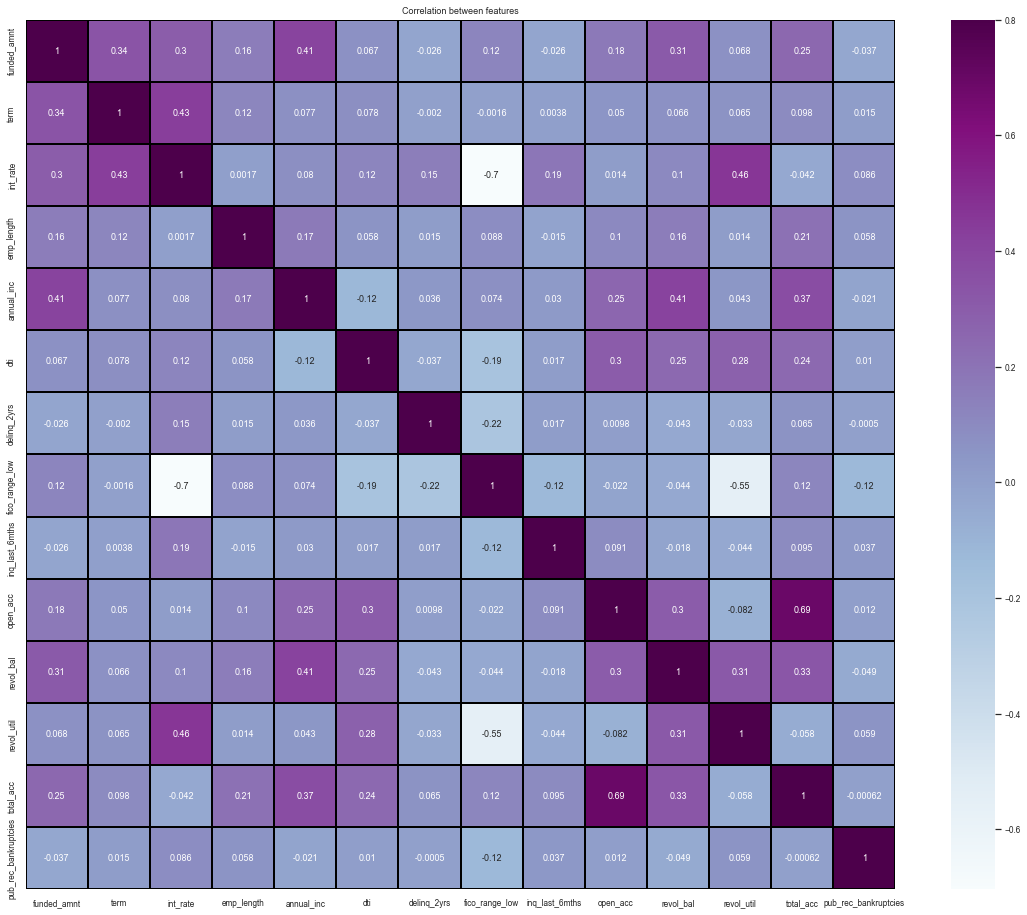

In [57]:
corr_all = df.corr()
sns.set(font_scale=0.75)
plt.figure(figsize = (20,16))

sns.heatmap(corr_all, vmax=.8, linewidths=0.01,square = True, annot = True, cmap="BuPu",linecolor="black")
plt.title('Correlation between features')

After removing, the maximum correlation is 0.69 - allow for further analysis.

In [58]:
df.shape

(41585, 19)

After exploratory data analysis - 19 columns and 41585 rows.

In [59]:
pd.set_option('display.max_columns', None)
df.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,loan_status
0,5000.0,36.0,10.65,B,10.0,RENT,24000.0,Verified,credit_card,27.65,0.0,735.0,1.0,3.0,13648.0,83.7,9.0,0.0,1
1,2500.0,60.0,15.27,C,1.0,RENT,30000.0,Source Verified,car,1.00,0.0,740.0,5.0,3.0,1687.0,9.4,4.0,0.0,0
2,2400.0,36.0,15.96,C,10.0,RENT,12252.0,Not Verified,small_business,8.72,0.0,735.0,2.0,2.0,2956.0,98.5,10.0,0.0,1
3,10000.0,36.0,13.49,C,10.0,RENT,49200.0,Source Verified,other,20.00,0.0,690.0,1.0,10.0,5598.0,21.0,37.0,0.0,1
4,3000.0,60.0,12.69,B,1.0,RENT,80000.0,Source Verified,other,17.94,0.0,695.0,0.0,15.0,27783.0,53.9,38.0,0.0,1


# How does the FICO score relate to the probability of non-payment of the liability?

In [60]:
round(df['fico_range_low'].describe())

count    41585.0
mean       713.0
std         36.0
min        610.0
25%        685.0
50%        710.0
75%        740.0
max        825.0
Name: fico_range_low, dtype: float64

Research the basic statistics of a variable.

In [61]:
df.fico_range_low.value_counts().sort_index()

610.0       1
615.0       1
625.0       2
630.0       5
635.0       5
640.0      91
645.0      93
650.0     108
655.0     109
660.0    1499
665.0    1720
670.0    1781
675.0    1939
680.0    2168
685.0    2253
690.0    2143
695.0    2146
700.0    2227
705.0    1943
710.0    1735
715.0    1865
720.0    1927
725.0    1867
730.0    1654
735.0    1635
740.0    1472
745.0    1306
750.0    1285
755.0    1084
760.0     967
765.0     783
770.0     792
775.0     648
780.0     568
785.0     405
790.0     415
795.0     335
800.0     249
805.0     187
810.0     124
815.0      27
820.0      18
825.0       3
Name: fico_range_low, dtype: int64

Check how many individual values there are in this column

The T-student test - check if the variables are correlated - dependent variables if p greater than 0.5
Create a T-student test - fico score affects the repayment or non-repayment of the loan.

In [62]:
stat, p = ttest_rel(df['fico_range_low'], df['loan_status']) 
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same mean') 
else:
    print('Probably different mean')

stat=4034.521, p=0.000
Probably different mean


Conclusion: In this case, no effect.

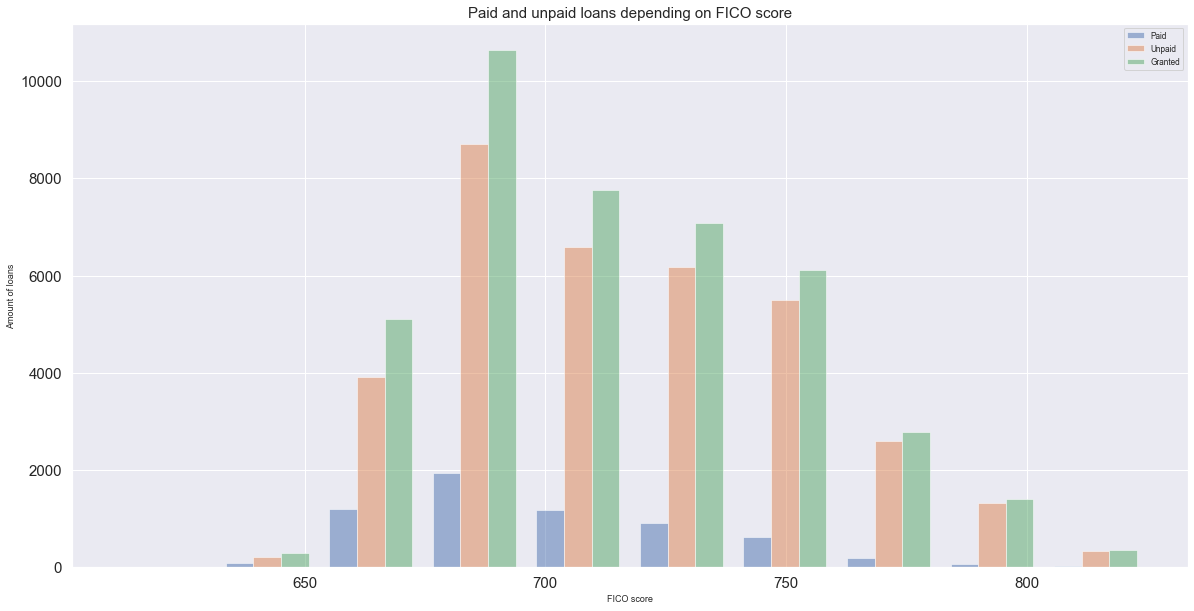

In [63]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.hist([df.fico_range_low[df.loan_status == 0], df.fico_range_low[df.loan_status == 1], df.fico_range_low], alpha = 0.5, label = ['Paid', 'Unpaid','Granted'])

ax.set_title('Paid and unpaid loans depending on FICO score', fontsize=15)
ax.set_xlabel('FICO score')
ax.set_ylabel('Amount of loans')
ax.tick_params(labelsize=15)
plt.legend()

In [64]:
# Check the amount of loans with certain FICO range
print('Amount of loans with FICO range lower than 685: ', df[(df.fico_range_low <= 685)].fico_range_low.count())
print('Amount of loans with FICO range between 690 and 710         ', df[(df.fico_range_low >= 690)&(df.fico_range_low <= 710)].fico_range_low.count())
print('Amount of loans with FICO range between 715 and 740:        ', df[(df.fico_range_low >= 715)&(df.fico_range_low <= 740)].fico_range_low.count())
print('Amount of loans with FICO range more than 745:      ', df[(df.fico_range_low >= 745)].fico_range_low.count())

Amount of loans with FICO range lower than 685:  11775
Amount of loans with FICO range between 690 and 710          10194
Amount of loans with FICO range between 715 and 740:         10420
Amount of loans with FICO range more than 745:       9196


In [65]:
# Check the percentage of unpaid loans in the specified FICO range
FICO_685= df[(df.fico_range_low <= 685) & (df.loan_status == 0)].fico_range_low.count() 
FICO_690 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.loan_status == 0)].fico_range_low.count()
FICO_715 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.loan_status == 0)].fico_range_low.count()
FICO_745 = df[(df.fico_range_low >= 745) & (df.loan_status == 0)].fico_range_low.count()

print('Amount of unpaid loans with FICO range lower than 685:',FICO_685, 'This is:',round((FICO_685*100)/11775,2), '% loans at this FICO range')
print('Amount of unpaid loans with FICO range between 690 and 710:', FICO_690, 'This is:', round((FICO_690*100)/10194,2), '% loans at this FICO range')
print('Amount of unpaid loans with FICO range between 715 and 740:', FICO_715, 'This is:', round((FICO_715*100)/10420,2), '% loans at this FICO range')
print('Amount of unpaid loans with FICO range more than 745:',  FICO_745,'This is:', round((FICO_745*100)/9196,2), '% loans at this FICO range')

Amount of unpaid loans with FICO range lower than 685: 2486 This is: 21.11 % loans at this FICO range
Amount of unpaid loans with FICO range between 690 and 710: 1680 This is: 16.48 % loans at this FICO range
Amount of unpaid loans with FICO range between 715 and 740: 1327 This is: 12.74 % loans at this FICO range
Amount of unpaid loans with FICO range more than 745: 745 This is: 8.1 % loans at this FICO range


CONCLUSIONS (fico_range_low): The lower FICO score is, the more unpaid loans - the greater risk of non-payment of the liability.

The amount of unpaid loans in case of the lowest analyzed FICO score is 13 percentage points higher than in case of the highest FICO Score.

# How credit age is associated with the probability of non-payment of the liability? 

In [66]:
round(df['term'].describe())

count    41585.0
mean        42.0
std         11.0
min         36.0
25%         36.0
50%         36.0
75%         60.0
max         60.0
Name: term, dtype: float64

In [67]:
df.term.value_counts().sort_index()

36.0    30768
60.0    10817
Name: term, dtype: int64

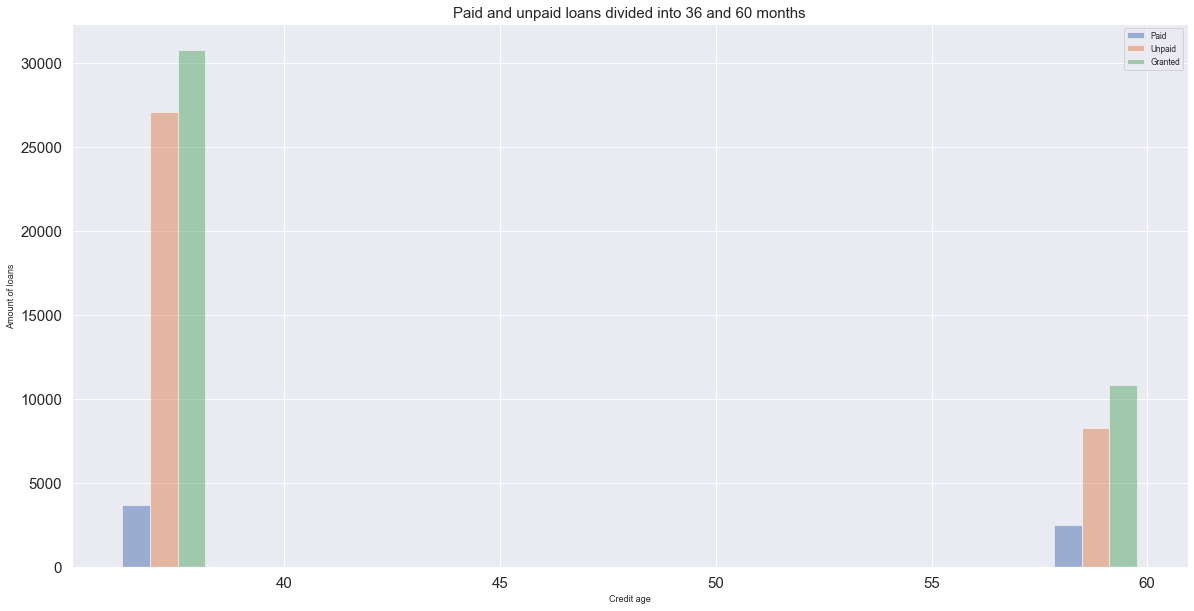

In [68]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.hist([df.term[df.loan_status == 0], df.term[df.loan_status == 1], df.term], alpha = 0.5, label = ['Paid', 'Unpaid','Granted'])

ax.set_title('Paid and unpaid loans divided into 36 and 60 months', fontsize=15)
ax.set_xlabel('Credit age')
ax.set_ylabel('Amount of loans')
ax.tick_params(labelsize=15)
plt.legend()

In [69]:
# Check the amount of loans with credit age divided into 36 and 60 months 
print('Amount of loans with credit age - 36 months: ', df[(df.term == 36.0)].term.count())
print('Amount of loans with credit age - 60 months: ', df[(df.term == 60.0)].term.count())


Amount of loans with credit age - 36 months:  30768
Amount of loans with credit age - 60 months:  10817


In [70]:
# Check the percentage of unpaid loans in the specified credit age
months_36 = df[(df.term == 36.0) & (df.loan_status == 0)].term.count() 
months_60 = df[(df.term == 60.0) & (df.loan_status == 0)].term.count()

print('Amount of unpaid loans with credit age - 36 months: ',months_36, 'This is:',round((months_36*100)/30768,2), '% loans at this credit age')
print('Amount of unpaid loans with credit age - 60 months: ',months_60, 'This is:', round((months_60*100)/10817,2), '% loans at this credit age')


Amount of unpaid loans with credit age - 36 months:  3722 This is: 12.1 % loans at this credit age
Amount of unpaid loans with credit age - 60 months:  2516 This is: 23.26 % loans at this credit age


CONCLUSIONS (term): The higher the credit age, the more unpaid loans – the greater risk of non-payment of the liability.

# Risk is independent or related to the FICO score?

In [71]:
# Check the amount of loans with credit age divided into 36 and 60 months and with specified FICO range
print('Amount of loans with credit age - 36 months and FICO range lower than 685: ', df[(df.term == 36.0)&(df.fico_range_low <= 685)].fico_range_low.count())
print('Amount of loans with credit age - 60 months and FICO range lower than 685: ', df[(df.term == 60.0)&(df.fico_range_low <= 685)].fico_range_low.count())

print('Amount of loans with credit age - 36 months and FICO range between 690 and 710: ', df[(df.term == 36.0)&(df.fico_range_low >= 690)&(df.fico_range_low <=710)].fico_range_low.count())
print('Amount of loans with credit age - 60 months and FICO range between 690 and 710: ', df[(df.term == 60.0)&(df.fico_range_low >= 690)&(df.fico_range_low <=710)].fico_range_low.count())

print('Amount of loans with credit age - 36 months and FICO range between 715 and 740: ', df[(df.term == 36.0)&(df.fico_range_low >= 715)&(df.fico_range_low <=740)].fico_range_low.count())
print('Amount of loans with credit age - 60 months and FICO range between 715 and 740: ', df[(df.term == 60.0)&(df.fico_range_low >= 715)&(df.fico_range_low <=740)].fico_range_low.count())

print('Amount of loans with credit age - 36 months and FICO range more than 745: ', df[(df.term == 36.0)&(df.fico_range_low >= 745)].fico_range_low.count())
print('Amount of loans with credit age - 60 months and FICO range more than 745: ', df[(df.term == 60.0)&(df.fico_range_low >= 745)].fico_range_low.count())


Amount of loans with credit age - 36 months and FICO range lower than 685:  8842
Amount of loans with credit age - 60 months and FICO range lower than 685:  2933
Amount of loans with credit age - 36 months and FICO range between 690 and 710:  7424
Amount of loans with credit age - 60 months and FICO range between 690 and 710:  2770
Amount of loans with credit age - 36 months and FICO range between 715 and 740:  7574
Amount of loans with credit age - 60 months and FICO range between 715 and 740:  2846
Amount of loans with credit age - 36 months and FICO range more than 745:  6928
Amount of loans with credit age - 60 months and FICO range more than 745:  2268


In [72]:
# Check the percentage of unpaid loans with credit age divided into 36 and 60 months and with specified FICO range
FICO_685_36 = df[(df.fico_range_low <= 685) & (df.loan_status == 0) & (df.term == 36)].fico_range_low.count() 
FICO_685_60 = df[(df.fico_range_low <= 685) & (df.loan_status == 0) & (df.term == 60)].fico_range_low.count() 

FICO_690_36 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.loan_status == 0) & (df.term == 36)].fico_range_low.count()
FICO_690_60 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.loan_status == 0) & (df.term == 60)].fico_range_low.count()

FICO_715_36 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.loan_status == 0) & (df.term == 36)].fico_range_low.count()
FICO_715_60 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.loan_status == 0) & (df.term == 60)].fico_range_low.count()

FICO_745_36 = df[(df.fico_range_low >= 745) & (df.loan_status == 0) & (df.term == 36)].fico_range_low.count()
FICO_745_60 = df[(df.fico_range_low >= 745) & (df.loan_status == 0) & (df.term == 60)].fico_range_low.count()

print('Amount of unpaid loans with credit age - 36 months and FICO range lower than 685: ',FICO_685_36, 'This is: ',round((FICO_685_36*100)/8842,2), '% loans under these conditions.')
print('Amount of unpaid loans with credit age - 60 months and FICO range lower than 685: ',FICO_685_60, 'This is: ', round((FICO_685_60*100)/2933,2), '% loans under these conditions.')

print('Amount of unpaid loans with credit age - 36 months and FICO range between 690 and 710: ',FICO_690_36, 'This is: ',round((FICO_690_36*100)/7424,2), '% loans under these conditions.')
print('Amount of unpaid loans with credit age - 60 months and FICO range between 690 and 710: ',FICO_690_60, 'This is: ', round((FICO_690_60*100)/2770,2), '% loans under these conditions.')

print('Amount of unpaid loans with credit age - 36 months and FICO range between 715 and 740: ',FICO_715_36, 'This is: ',round((FICO_715_36*100)/7574,2), '% loans under these conditions.')
print('Amount of unpaid loans with credit age - 60 months and FICO range between 715 and 740:',FICO_715_60, 'This is: ', round((FICO_715_60*100)/2846,2), '% loans under these conditions.')

print('Amount of unpaid loans with credit age - 36 months and FICO range more than 745: ',FICO_745_36, 'This is: ',round((FICO_745_36*100)/6928,2), '% loans under these conditions.')
print('Amount of unpaid loans with credit age - 60 months and FICO range more than 745: ',FICO_745_60, 'This is: ', round((FICO_745_60*100)/2268,2), '% loans under these conditions.')


Amount of unpaid loans with credit age - 36 months and FICO range lower than 685:  1588 This is:  17.96 % loans under these conditions.
Amount of unpaid loans with credit age - 60 months and FICO range lower than 685:  898 This is:  30.62 % loans under these conditions.
Amount of unpaid loans with credit age - 36 months and FICO range between 690 and 710:  997 This is:  13.43 % loans under these conditions.
Amount of unpaid loans with credit age - 60 months and FICO range between 690 and 710:  683 This is:  24.66 % loans under these conditions.
Amount of unpaid loans with credit age - 36 months and FICO range between 715 and 740:  751 This is:  9.92 % loans under these conditions.
Amount of unpaid loans with credit age - 60 months and FICO range between 715 and 740: 576 This is:  20.24 % loans under these conditions.
Amount of unpaid loans with credit age - 36 months and FICO range more than 745:  386 This is:  5.57 % loans under these conditions.
Amount of unpaid loans with credit age

CONCLUSIONS (term, fico_range_low): In all FICO ranges, the longer credit age is, the greater risk of non-payment of the liability. 

# How does the status of a home mortgage relate the probability of non-payment of the liability?

In [73]:
df["home_ownership"].replace({"OWN": "1", "RENT": "2","MORTGAGE": "3", "OTHER": "4", "NONE": "4" }, inplace=True)

In [74]:
df.home_ownership.value_counts().sort_index()

1     3170
2    19899
3    18378
4      138
Name: home_ownership, dtype: int64

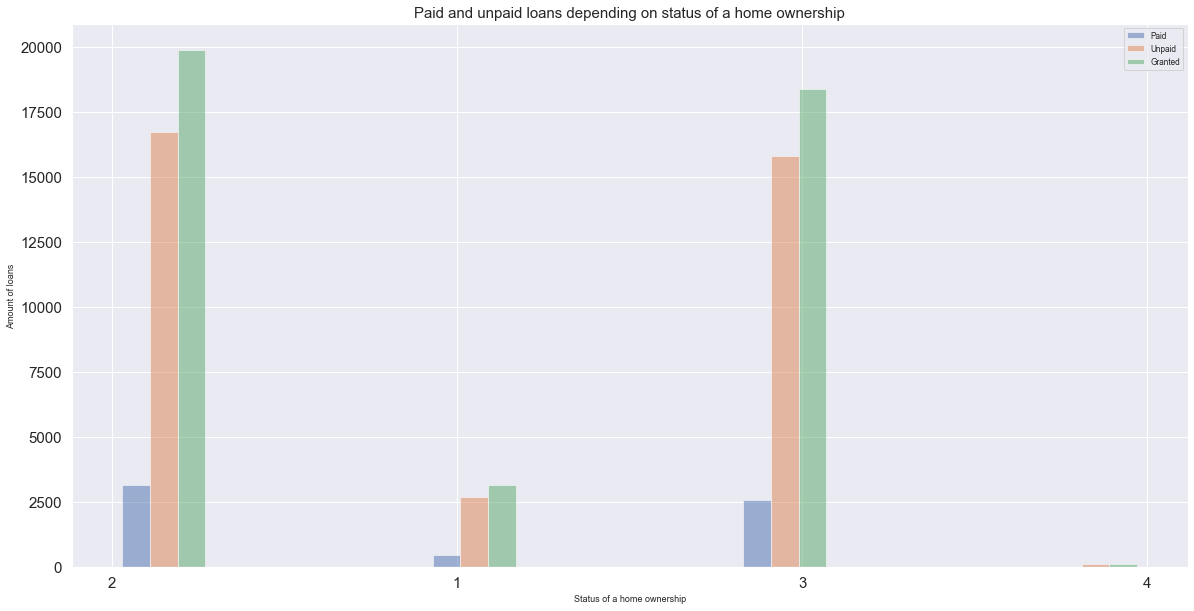

In [75]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.hist([df.home_ownership[df.loan_status == 0], df.home_ownership[df.loan_status == 1], df.home_ownership], alpha = 0.5, label = ['Paid', 'Unpaid','Granted'])

ax.set_title('Paid and unpaid loans depending on status of a home ownership', fontsize=15)
ax.set_xlabel('Status of a home ownership')
ax.set_ylabel('Amount of loans')
ax.tick_params(labelsize=15)
plt.legend()

In [76]:
# Check the amount of loans with status of a home ownership
print('Amount of loans with the status of own home: ', df[(df.home_ownership == "1")].home_ownership.count())
print('Amount of loans with the status of rent house: ', df[(df.home_ownership == "2")].home_ownership.count())
print('Amount of loans with the status of mortgage house: ', df[(df.home_ownership == "3")].home_ownership.count())
print('Amount of loans with the status of none/other: ', df[(df.home_ownership == "4")].home_ownership.count())

Amount of loans with the status of own home:  3170
Amount of loans with the status of rent house:  19899
Amount of loans with the status of mortgage house:  18378
Amount of loans with the status of none/other:  138


In [77]:
# Check the percentage of unpaid loans with status of a home ownership
own = df[(df.home_ownership == "1") & (df.loan_status == 0)].home_ownership.count()
rent = df[(df.home_ownership == "2") & (df.loan_status == 0)].home_ownership.count()
mortgage = df[(df.home_ownership == "3") & (df.loan_status == 0)].home_ownership.count()
other_none = df[(df.home_ownership == "4") & (df.loan_status == 0)].home_ownership.count()

print('Amount of unpaid loans with the status of own home: ',own, 'This is: ',round((own*100)/3170,2), '% loans with this status.')
print('Amount of unpaid loans with the status of rent house: ', rent, 'This is :', round((rent*100)/19899,2), '% loans with this status.')
print('Amount of unpaid loans with the status of mortgage house: ', mortgage, 'This is: ', round((mortgage*100)/18378,2), '% loans with this status.')
print('Amount of unpaid loans with the status of none/other: ', other_none, 'This is: ', round((other_none*100)/138,2), '% loans with this status.')

Amount of unpaid loans with the status of own home:  477 This is:  15.05 % loans with this status.
Amount of unpaid loans with the status of rent house:  3152 This is : 15.84 % loans with this status.
Amount of unpaid loans with the status of mortgage house:  2581 This is:  14.04 % loans with this status.
Amount of unpaid loans with the status of none/other:  28 This is:  20.29 % loans with this status.


CONCLUSIONS (home_ownership): In case of status - none/other is the largest percentage of unpaid loans - the greatest risk of non-payment of the liability. The lowest percentage of outstanding loans is in case of status - mortgage house - the least risk of non-payment of the liability. Additionally the greater risk of non-repayment of the loan is in case of status - rent house than in case of status - own home.

# How does annual income relate to the probability of non-payment of the liability?¶

In [78]:
round(df['annual_inc'].describe())

count     41585.0
mean      66657.0
std       39662.0
min        1896.0
25%       40000.0
50%       58000.0
75%       81377.0
max      385000.0
Name: annual_inc, dtype: float64

In [79]:
df.annual_inc.value_counts().sort_index()

1896.0      1
2000.0      1
3300.0      1
3500.0      1
3600.0      1
           ..
372000.0    1
375000.0    1
381450.0    1
384000.0    1
385000.0    1
Name: annual_inc, Length: 5457, dtype: int64

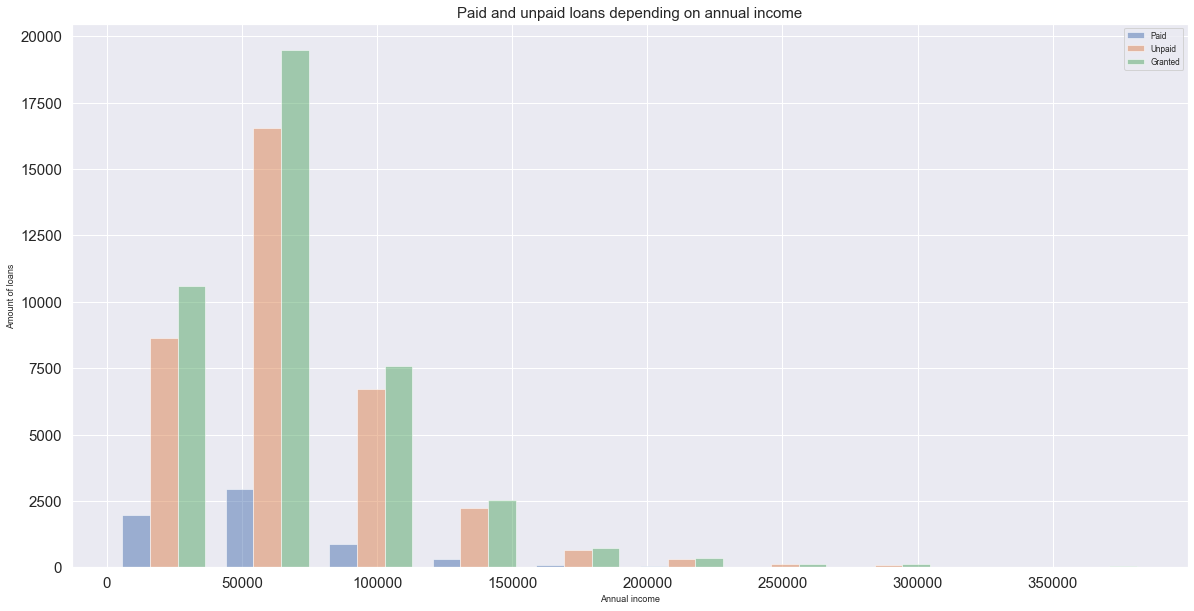

In [80]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.hist([df.annual_inc[df.loan_status == 0], df.annual_inc[df.loan_status == 1], df.annual_inc], alpha = 0.5, label = ['Paid', 'Unpaid','Granted'])

ax.set_title('Paid and unpaid loans depending on annual income', fontsize=15)
ax.set_xlabel('Annual income')
ax.set_ylabel('Amount of loans')
ax.tick_params(labelsize=15)
plt.legend()

In [81]:
# Check the amount of loans with certain annual income range
print('Amount of loans with annual income range lower than 40000: ', df[(df.annual_inc <= 40000)].annual_inc.count())
print('Amount of loans with annual income range between 40001 and 58000: ', df[(df.annual_inc >= 40001)&(df.annual_inc <= 58000)].annual_inc.count())
print('Amount of loans with annual income range between 58001 and 81377: ', df[(df.annual_inc >= 58001)&(df.annual_inc <= 81377)].annual_inc.count())
print('Amount of loans with annual income range more than 81378: ', df[(df.annual_inc >= 81378)].annual_inc.count())

Amount of loans with annual income range lower than 40000:  10552
Amount of loans with annual income range between 40001 and 58000:  10301
Amount of loans with annual income range between 58001 and 81377:  10335
Amount of loans with annual income range more than 81378:  10396


In [82]:
# Check the percentage of unpaid loans with certain annual income range
income_40000= df[(df.annual_inc <= 40000) & (df.loan_status == 0)].annual_inc.count() 
income_40001 = df[(df.annual_inc >= 40001)&(df.annual_inc <=58000) & (df.loan_status == 0)].annual_inc.count()
income_58001 = df[(df.annual_inc >= 58001)&(df.annual_inc <=81377) & (df.loan_status == 0)].annual_inc.count()
income_81378 = df[(df.annual_inc >= 81378) & (df.loan_status == 0)].annual_inc.count() 

print('Amount of unpaid loans with annual income range lower than 40000: ',income_40000, 'This is: ', round((income_40000*100)/10552,2), '% loans at this level of annual income.')
print('Amount of unpaid loans with annual income range between 40001 and 58000: ',income_40001, 'This is: ', round((income_40001*100)/10301,2), '% loans at this level of annual income.')
print('Amount of unpaid loans with annual income range between 58001 and 81377: ',income_58001, 'This is: ', round((income_58001*100)/10335,2), '% loans at this level of annual income.')
print('Amount of unpaid loans with annual income range more than 81378: ',income_81378,'This is: ', round((income_81378*100)/10396,2), '% loans at this level of annual income.')

Amount of unpaid loans with annual income range lower than 40000:  1952 This is:  18.5 % loans at this level of annual income.
Amount of unpaid loans with annual income range between 40001 and 58000:  1584 This is:  15.38 % loans at this level of annual income.
Amount of unpaid loans with annual income range between 58001 and 81377:  1499 This is:  14.5 % loans at this level of annual income.
Amount of unpaid loans with annual income range more than 81378:  1203 This is:  11.57 % loans at this level of annual income.


CONCLUSIONS (annual_inc): The higher annual income is, the fewer unpaid loans - the lower risk of non-payment of the liability.

# How does the employment history relate to the probability of non-payment of the liability?

In [83]:
round(df['emp_length'].describe())

count    41585.0
mean         5.0
std          3.0
min          1.0
25%          2.0
50%          4.0
75%          9.0
max         10.0
Name: emp_length, dtype: float64

In [84]:
df.emp_length.value_counts().sort_index()

1.0     8476
2.0     4626
3.0     4288
4.0     4681
5.0     3396
6.0     2322
7.0     1830
8.0     1544
9.0     1308
10.0    9114
Name: emp_length, dtype: int64

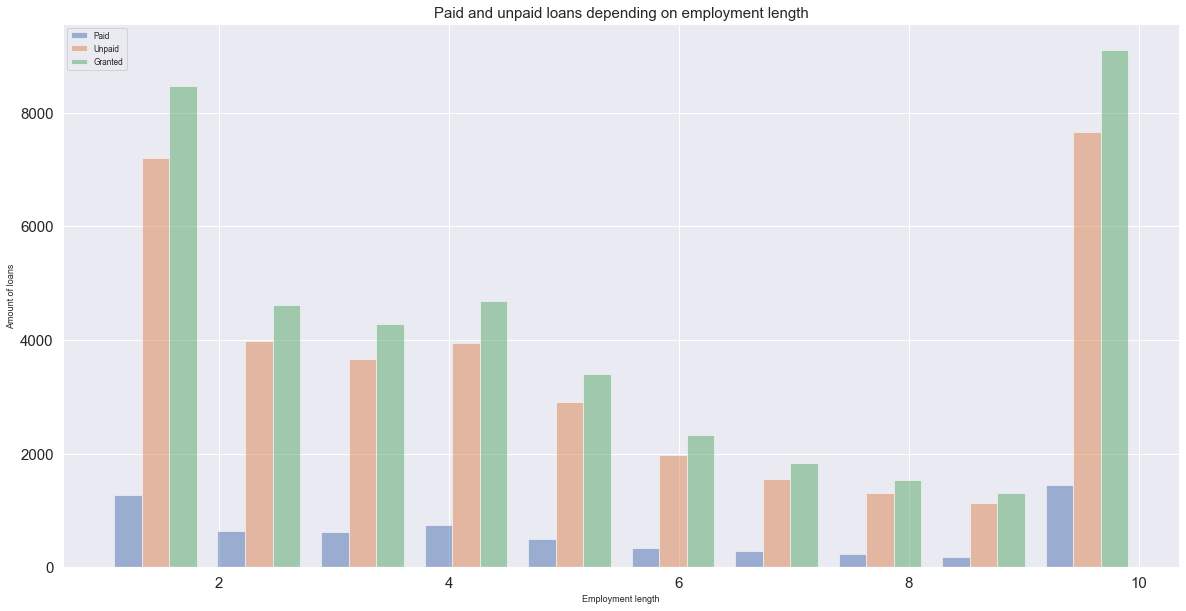

In [85]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.hist([df.emp_length[df.loan_status == 0], df.emp_length[df.loan_status == 1], df.emp_length], alpha = 0.5, label = ['Paid', 'Unpaid','Granted'])

ax.set_title('Paid and unpaid loans depending on employment length', fontsize=15)
ax.set_xlabel('Employment length')
ax.set_ylabel('Amount of loans')
ax.tick_params(labelsize=15)
plt.legend()

In [86]:
# Check the amount of loans with certain employment length range
print('Amount of loans with employment length lower than 2 years: ', df[(df.emp_length <= 2.0)].emp_length.count())
print('Amount of loans with employment length between 3 and 4 years: ', df[(df.emp_length >= 3.0)&(df.emp_length <= 4.0)].emp_length.count())
print('Amount of loans with employment length between 5 and 9 years: ', df[(df.emp_length >= 5.0)&(df.emp_length <= 9.0)].emp_length.count())
print('Amount of loans with employment length more than 10 years: ', df[(df.emp_length >= 10.0)].emp_length.count())

Amount of loans with employment length lower than 2 years:  13102
Amount of loans with employment length between 3 and 4 years:  8969
Amount of loans with employment length between 5 and 9 years:  10400
Amount of loans with employment length more than 10 years:  9114


In [87]:
# Check the percentage of unpaid loans with certain employment length range
years_2= df[(df.emp_length <= 2.0) & (df.loan_status == 0)].emp_length.count() 
years_3 = df[(df.emp_length >= 3.0)&(df.emp_length <=4.0) & (df.loan_status == 0)].emp_length.count()
years_5 = df[(df.emp_length >= 5.0)&(df.emp_length <=9.0) & (df.loan_status == 0)].emp_length.count()
years_10 = df[(df.emp_length >= 10.0) & (df.loan_status == 0)].emp_length.count() 

print('Amount of unpaid loans with employment length lower than 2 years: ',years_2, 'This is: ', round((years_2*100)/13102,2), '% loans at this level of employment length.')
print('Amount of unpaid loans with employment length between 3 and 4 years: ',years_3, 'This is: ', round((years_3*100)/7871,2), '% loans at this level of employment length.')
print('Amount of unpaid loans with employment length between 5 and 9 years: ',years_5, 'This is: ', round((years_5*100)/11498,2), '% loans at this level of employment length.')
print('Amount of unpaid loans with employment length more than 10 years: ',years_10,'This is: ', round((years_10*100)/9114,2), '% loans at this level of employment length.')

Amount of unpaid loans with employment length lower than 2 years:  1900 This is:  14.5 % loans at this level of employment length.
Amount of unpaid loans with employment length between 3 and 4 years:  1360 This is:  17.28 % loans at this level of employment length.
Amount of unpaid loans with employment length between 5 and 9 years:  1522 This is:  13.24 % loans at this level of employment length.
Amount of unpaid loans with employment length more than 10 years:  1456 This is:  15.98 % loans at this level of employment length.


CONCLUSIONS (emp_length) : Looking at the employment length there is no clear trend regarding loan repayment. The most unpaid loans, so the highest risk appears when employment length is between 3 and 4 years, but the lowest when employment length is between 5 and 9 years.

# How the sum of the loan relate to the probability of non-payment of the liability?

In [88]:
round(df['funded_amnt'].describe())

count    41585.0
mean     10806.0
std       7127.0
min        500.0
25%       5000.0
50%       9600.0
75%      15000.0
max      35000.0
Name: funded_amnt, dtype: float64

In [89]:
df.funded_amnt.value_counts().sort_index()

500.0        9
550.0        1
600.0        6
700.0        3
725.0        1
          ... 
34475.0      4
34525.0      1
34675.0      2
34800.0      1
35000.0    541
Name: funded_amnt, Length: 1048, dtype: int64

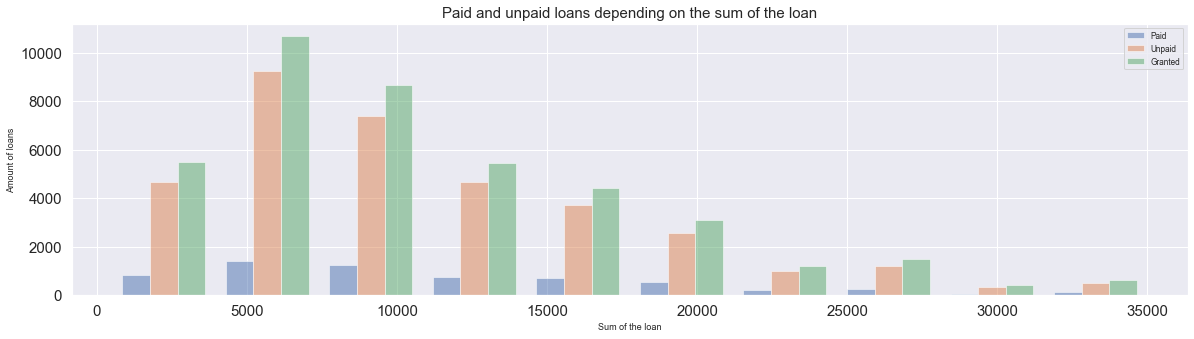

In [90]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.hist([df.funded_amnt[df.loan_status == 0], df.funded_amnt[df.loan_status == 1], df.funded_amnt], alpha = 0.5, label = ['Paid', 'Unpaid','Granted'])

ax.set_title('Paid and unpaid loans depending on the sum of the loan', fontsize=15)
ax.set_xlabel('Sum of the loan')
ax.set_ylabel('Amount of loans')
ax.tick_params(labelsize=15)
plt.legend()

In [91]:
# Check the amount of loans with certain sum of the loan range
print('Amount of loans with sum of the loan lower than 5000: ', df[(df.funded_amnt <= 5000)].funded_amnt.count())
print('Amount of loans with sum of the loan between 5001 a 9600: ', df[(df.funded_amnt >= 5001)&(df.funded_amnt <= 9600)].funded_amnt.count())
print('Amount of loans with sum of the loan between 9601 a 15000: ', df[(df.funded_amnt >= 9601)&(df.funded_amnt <= 15000)].funded_amnt.count())
print('Amount of loans with sum of the loan more than 15001: ', df[(df.funded_amnt >= 15001)].funded_amnt.count())

Amount of loans with sum of the loan lower than 5000:  10400
Amount of loans with sum of the loan between 5001 a 9600:  10748
Amount of loans with sum of the loan between 9601 a 15000:  11533
Amount of loans with sum of the loan more than 15001:  8904


In [92]:
# Check the percentage of unpaid loans with certain sum of the loan range
sum_loan_5000= df[(df.funded_amnt <= 5000) & (df.loan_status == 0)].funded_amnt.count() 
sum_loan_5001 = df[(df.funded_amnt >= 5001)&(df.funded_amnt <=9600) & (df.loan_status == 0)].funded_amnt.count()
sum_loan_9601 = df[(df.funded_amnt >= 9601)&(df.funded_amnt <=15000) & (df.loan_status == 0)].funded_amnt.count()
sum_loan_15001 = df[(df.funded_amnt >= 15001) & (df.loan_status == 0)].funded_amnt.count() 

print('Amount of unpaid loans with sum of the loan lower than 5000: ',sum_loan_5000, 'This is: ', round((sum_loan_5000*100)/10400,2), '% loans at this level of loan sum.')
print('Amount of unpaid loans with sum of the loan between 5001 a 9600: ',sum_loan_5001, 'This is: ', round((sum_loan_5001*100)/10748,2), '% loans at this level of loan sum.')
print('Amount of unpaid loans with sum of the loan between 9601 a 15000: ',sum_loan_9601, 'This is: ', round((sum_loan_9601*100)/11533,2), '% loans at this level of loan sum.')
print('Amount of unpaid loans with sum of the loan more than 15001: ',sum_loan_15001,'This is: ', round((sum_loan_15001*100)/8904,2), '% loans at this level of loan sum.')

Amount of unpaid loans with sum of the loan lower than 5000:  1533 This is:  14.74 % loans at this level of loan sum.
Amount of unpaid loans with sum of the loan between 5001 a 9600:  1454 This is:  13.53 % loans at this level of loan sum.
Amount of unpaid loans with sum of the loan between 9601 a 15000:  1632 This is:  14.15 % loans at this level of loan sum.
Amount of unpaid loans with sum of the loan more than 15001:  1619 This is:  18.18 % loans at this level of loan sum.


CONCLUSIONS (funded_amnt): Risk is at a similar level in range 0-15000 of the sum of the loan. When the sum of the loan is greater than 15001, in this case risk of non-payment of the liability increases.

# Feature Engineering

In [93]:
df_a = pd.read_csv("Loan_data.csv",low_memory=False)

Create auxiliary data frame in order to add columns to the original dataset.

In [94]:
pd.set_option('display.max_columns', None)
df.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,loan_status
0,5000.0,36.0,10.65,B,10.0,2,24000.0,Verified,credit_card,27.65,0.0,735.0,1.0,3.0,13648.0,83.7,9.0,0.0,1
1,2500.0,60.0,15.27,C,1.0,2,30000.0,Source Verified,car,1.00,0.0,740.0,5.0,3.0,1687.0,9.4,4.0,0.0,0
2,2400.0,36.0,15.96,C,10.0,2,12252.0,Not Verified,small_business,8.72,0.0,735.0,2.0,2.0,2956.0,98.5,10.0,0.0,1
3,10000.0,36.0,13.49,C,10.0,2,49200.0,Source Verified,other,20.00,0.0,690.0,1.0,10.0,5598.0,21.0,37.0,0.0,1
4,3000.0,60.0,12.69,B,1.0,2,80000.0,Source Verified,other,17.94,0.0,695.0,0.0,15.0,27783.0,53.9,38.0,0.0,1


Add column - installment in relation to the loan amount in percentage

In [95]:
df = df.join(df_a["loan_amnt"])

In [96]:
installment = round(df['loan_amnt']/df['term'])
monthly_income = df['annual_inc']/12
df['installment_to_inc'] = 100*(installment/monthly_income)
df['installment_to_inc'].head()
df = df.drop(['loan_amnt'], axis=1)

Text(0.5, 1.0, 'Correlation between features')

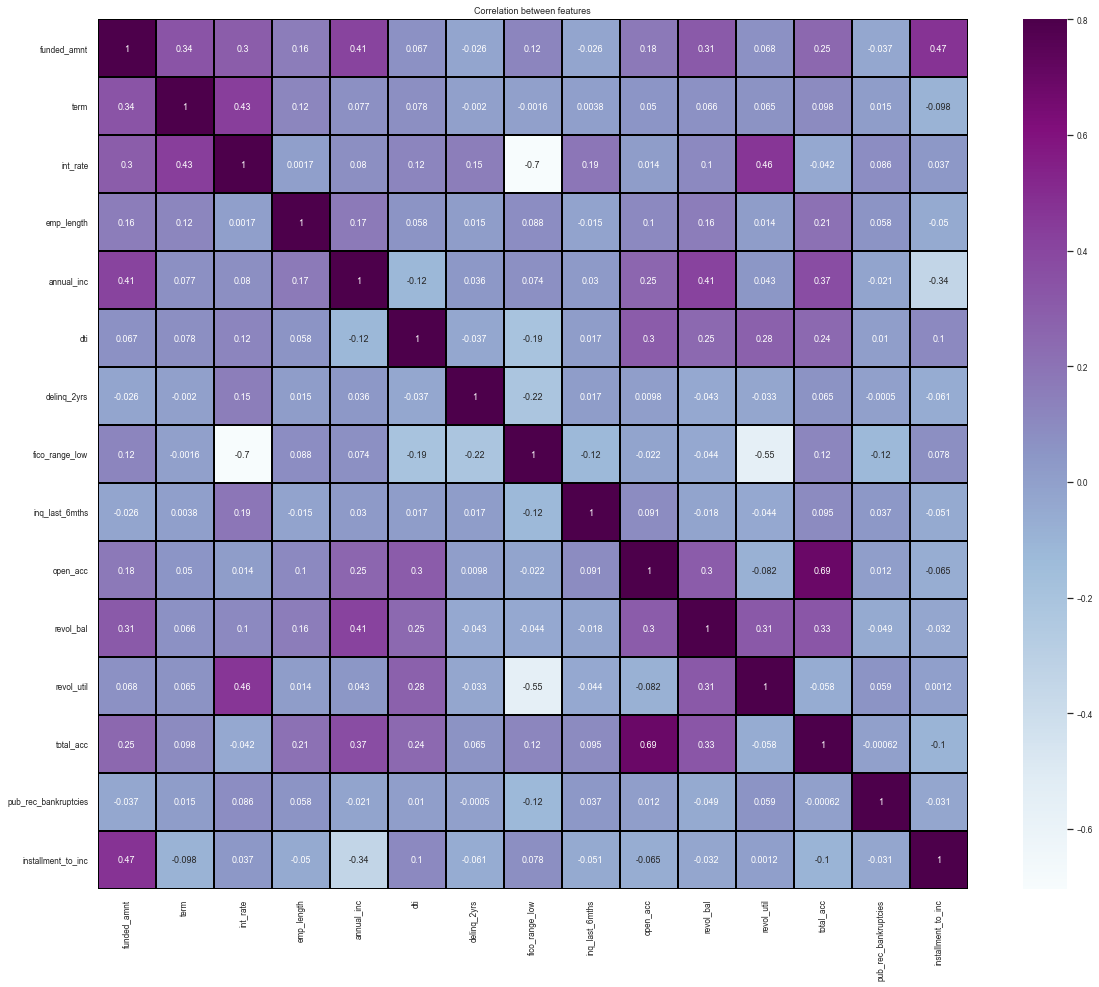

In [97]:
corr_all = df.corr()
sns.set(font_scale=0.75)
plt.figure(figsize = (20,16))

sns.heatmap(corr_all, vmax=.8, linewidths=0.01,square = True, annot = True, cmap="BuPu",linecolor="black")
plt.title('Correlation between features')

Check correlation to decide if variable is not too correlated with other variables - the decision to add a new variable.

Add column - financial indicator - loan amount received in relation to the requested

In [98]:
df = df.join(df_a["funded_amnt_inv"])

In [99]:
df['funded_amnt_to_inv'] = df['funded_amnt_inv']/df['funded_amnt']
df['funded_amnt_to_inv'].head()
df = df.drop(['funded_amnt_inv'], axis=1)

Text(0.5, 1.0, 'Correlation between features')

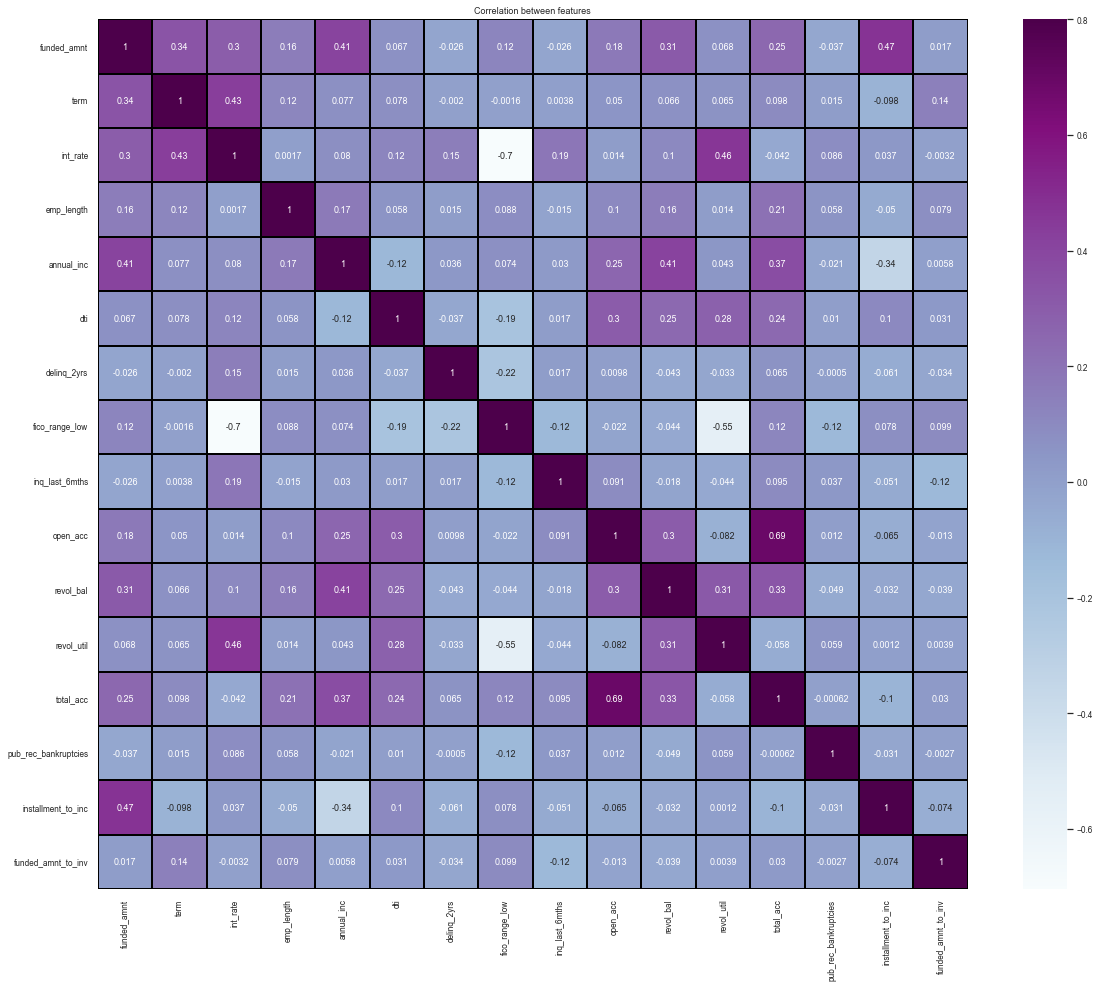

In [100]:
corr_all = df.corr()
sns.set(font_scale=0.75)
plt.figure(figsize = (20,16))

sns.heatmap(corr_all, vmax=.8, linewidths=0.01,square = True, annot = True, cmap="BuPu",linecolor="black")
plt.title('Correlation between features')

Check correlation to decide if variable is not too correlated with other variables - the decision to add a new variable.

Add column - level of accuracy in describing the purpose of the loan

In [101]:
df = df.join(df_a["desc"])

In [102]:
df['desc_number'] = df['desc'].str.len()

In [103]:
df['desc_number'].fillna(0.0, inplace = True)

In [104]:
df = df.drop(['desc'], axis=1)

Text(0.5, 1.0, 'Correlation between features')

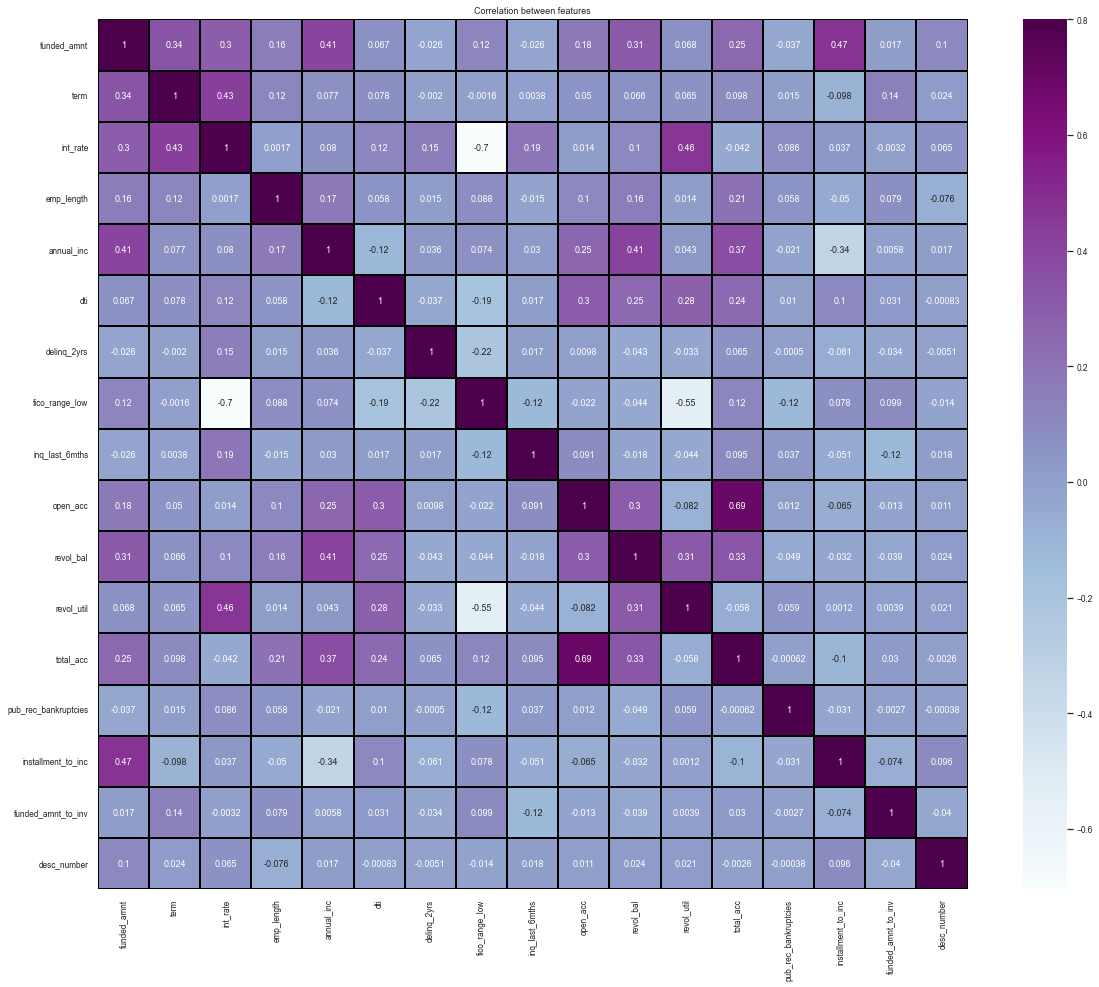

In [105]:
corr_all = df.corr()
sns.set(font_scale=0.75)
plt.figure(figsize = (20,16))

sns.heatmap(corr_all, vmax=.8, linewidths=0.01,square = True, annot = True, cmap="BuPu",linecolor="black")
plt.title('Correlation between features')

Check correlation to decide if variable is not too correlated with other variables - the decision to add a new variable.

In [106]:
new_cols = [col for col in df.columns if col != 'loan_status'] 
X = df[new_cols]
y = df['loan_status'].astype("int")

y - dependent variable, x - independent variables

In [107]:
X = pd.get_dummies(X)

One hot encoding - change from categorical to numerical.

In [108]:
pd.set_option('display.max_columns', None)
X.head()

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,installment_to_inc,funded_amnt_to_inv,desc_number,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_1,home_ownership_2,home_ownership_3,home_ownership_4,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.0,36.0,10.65,10.0,24000.0,27.65,0.0,735.0,1.0,3.0,13648.0,83.7,9.0,0.0,6.950000,0.995,78.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,60.0,15.27,1.0,30000.0,1.00,0.0,740.0,5.0,3.0,1687.0,9.4,4.0,0.0,1.680000,1.000,590.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,36.0,15.96,10.0,12252.0,8.72,0.0,735.0,2.0,2.0,2956.0,98.5,10.0,0.0,6.562194,1.000,0.0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10000.0,36.0,13.49,10.0,49200.0,20.00,0.0,690.0,1.0,10.0,5598.0,21.0,37.0,0.0,6.780488,1.000,180.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3000.0,60.0,12.69,1.0,80000.0,17.94,0.0,695.0,0.0,15.0,27783.0,53.9,38.0,0.0,0.750000,1.000,306.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [109]:
X.shape

(41585, 45)

45 variables finally enter to the model.

# Modelling

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

Create test set and training set

In [111]:
X_scaled = X.apply(stats.zscore)
pd.set_option('display.max_columns', None)
X_scaled.head()

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,installment_to_inc,funded_amnt_to_inv,desc_number,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_1,home_ownership_2,home_ownership_3,home_ownership_4,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,-0.814563,-0.592930,-0.397127,1.482373,-1.075524,2.124063,-0.321283,0.596235,-0.028455,-1.428545,0.018605,1.219129,-1.131114,-0.213383,0.468126,0.308397,-0.500053,-0.566677,1.551339,-0.508141,-0.404001,-0.290439,-0.173704,-0.104357,-0.287263,1.043937,-0.889897,-0.057702,-0.885177,-0.567900,1.468454,-0.199191,2.598022,-0.937118,-0.099294,-0.283369,-0.099541,-0.23928,-0.133485,-0.122822,-0.339732,-0.049342,-0.219290,-0.098052,-0.155111
1,-1.165326,1.686538,0.851764,-1.190745,-0.924244,-1.845691,-0.321283,0.734859,2.931680,-1.428545,-0.749488,-1.405588,-1.566908,-0.213383,-1.128878,0.335279,0.704151,-0.566677,-0.644605,1.967959,-0.404001,-0.290439,-0.173704,-0.104357,-0.287263,1.043937,-0.889897,-0.057702,-0.885177,1.760875,-0.680988,5.020312,-0.384908,-0.937118,-0.099294,-0.283369,-0.099541,-0.23928,-0.133485,-0.122822,-0.339732,-0.049342,-0.219290,-0.098052,-0.155111
2,-1.179356,-0.592930,1.038286,1.482373,-1.371729,-0.695728,-0.321283,0.596235,0.711579,-1.655706,-0.667997,1.741953,-1.043956,-0.213383,0.350607,0.335279,-0.683506,-0.566677,-0.644605,1.967959,-0.404001,-0.290439,-0.173704,-0.104357,-0.287263,1.043937,-0.889897,-0.057702,1.129717,-0.567900,-0.680988,-0.199191,-0.384908,-0.937118,-0.099294,-0.283369,-0.099541,-0.23928,-0.133485,-0.122822,-0.339732,-0.049342,4.560162,-0.098052,-0.155111
3,-0.113038,-0.592930,0.370589,1.482373,-0.440149,0.984527,-0.321283,-0.651381,-0.028455,0.161583,-0.498337,-0.995807,1.309330,-0.213383,0.416758,0.335279,-0.260153,-0.566677,-0.644605,1.967959,-0.404001,-0.290439,-0.173704,-0.104357,-0.287263,1.043937,-0.889897,-0.057702,-0.885177,1.760875,-0.680988,-0.199191,-0.384908,-0.937118,-0.099294,-0.283369,-0.099541,-0.23928,-0.133485,-0.122822,2.943499,-0.049342,-0.219290,-0.098052,-0.155111
4,-1.095173,1.686538,0.154331,-1.190745,0.336420,0.677672,-0.321283,-0.512757,-0.768489,1.297388,0.926305,0.166416,1.396489,-0.213383,-1.410703,0.335279,0.036194,-0.566677,1.551339,-0.508141,-0.404001,-0.290439,-0.173704,-0.104357,-0.287263,1.043937,-0.889897,-0.057702,-0.885177,1.760875,-0.680988,-0.199191,-0.384908,-0.937118,-0.099294,-0.283369,-0.099541,-0.23928,-0.133485,-0.122822,2.943499,-0.049342,-0.219290,-0.098052,-0.155111


Standardization - unification of variables, reduction to a similar distribution

Clustering (data grouping)

Algorithms to evaluate the number of clusters needed for the Kmeans method - elbow method and silhouette coefficient

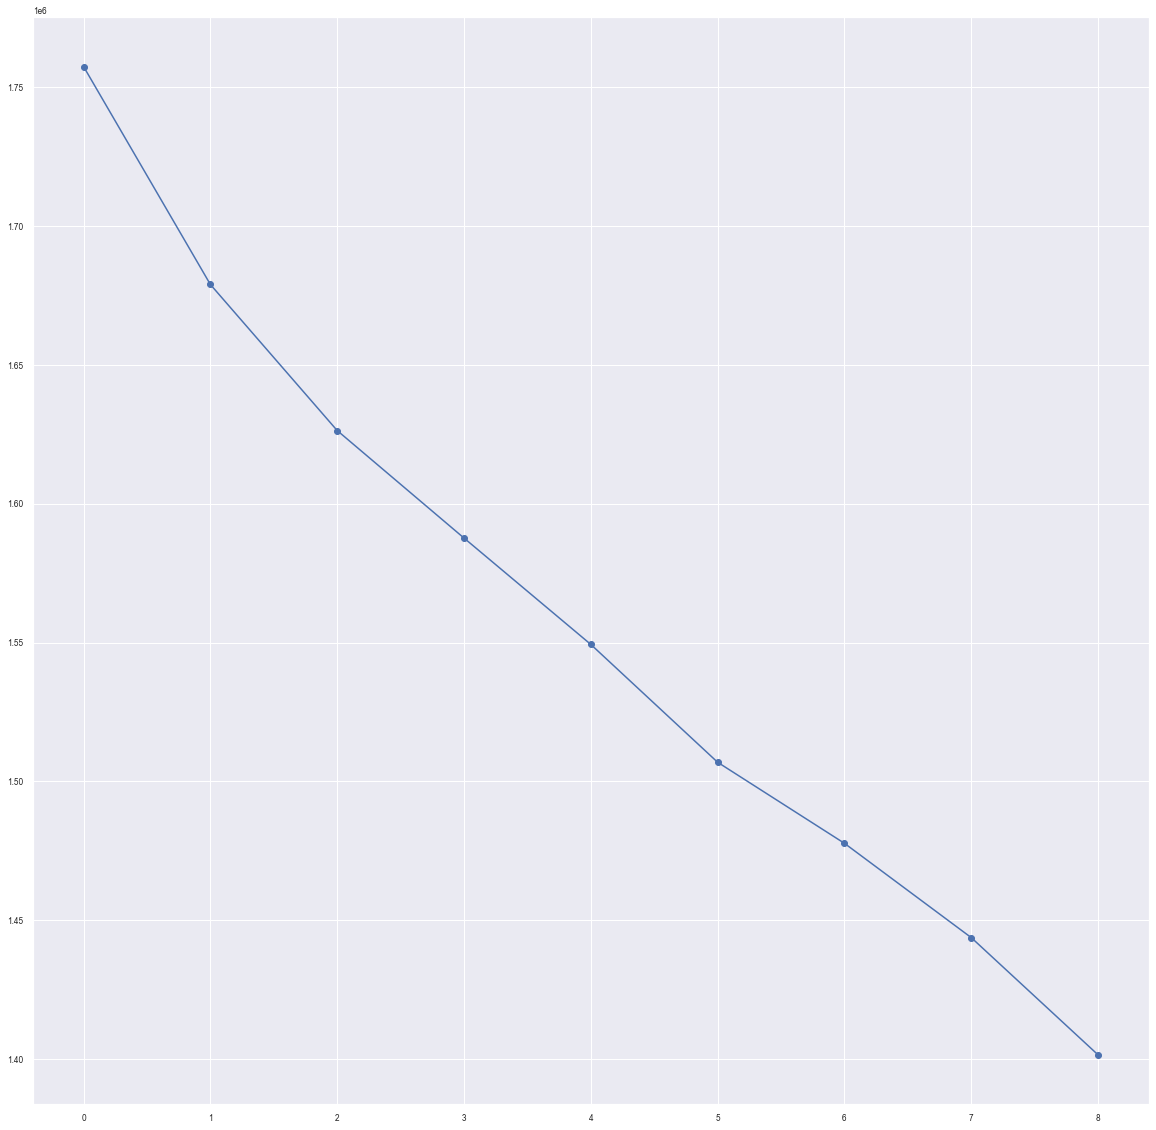

In [112]:
# Elbow-curve
ssd = [] 
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_) 
plt.plot(ssd, marker = "o" )

"bend" occurs at values of 4,5. Estimate the optimal number of clusters - 4.

In [113]:
# Silhouette coefficient
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.07367713236211618
For n_clusters=3, the silhouette score is 0.06698110551402474
For n_clusters=4, the silhouette score is 0.06205640473649167
For n_clusters=5, the silhouette score is 0.06258672787414467
For n_clusters=6, the silhouette score is 0.07642881294131407
For n_clusters=7, the silhouette score is 0.07218864279333428
For n_clusters=8, the silhouette score is 0.08498804342051562


Silhouette coefficient confirms the choice of clusters using the Elbow method - near 4 clusters, score decreases.

KMeans Method

In [114]:
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=42)
kmeans.fit(X_scaled)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [115]:
kmeans.labels_

array([1, 1, 1, ..., 1, 0, 0])

In [116]:
df['K-Means_Cluster_ID'] = kmeans.labels_

DBSCAN Method

In [117]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [118]:
X_std

array([[-0.81456324, -0.59293049, -0.39712711, ..., -0.21929048,
        -0.09805212, -0.1551106 ],
       [-1.16532567,  1.68653834,  0.85176381, ..., -0.21929048,
        -0.09805212, -0.1551106 ],
       [-1.17935617, -0.59293049,  1.03828648, ...,  4.56016155,
        -0.09805212, -0.1551106 ],
       ...,
       [-1.16181805, -0.59293049, -0.75395308, ..., -0.21929048,
        -0.09805212, -0.1551106 ],
       [-0.60410578, -0.59293049, -1.01075966, ..., -0.21929048,
        -0.09805212, -0.1551106 ],
       [-0.81456324, -0.59293049, -1.18106296, ..., -0.21929048,
        -0.09805212, -0.1551106 ]])

In [119]:
db = DBSCAN(eps=0.5, metric='euclidean', min_samples=5, n_jobs=-1)
model = db.fit(X_std)

In [120]:
db.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [121]:
df['DBScan_Cluster_ID'] = db.labels_

Hierarchical clustering - The result of the clustering visualized as a dendrogram

Single linkage

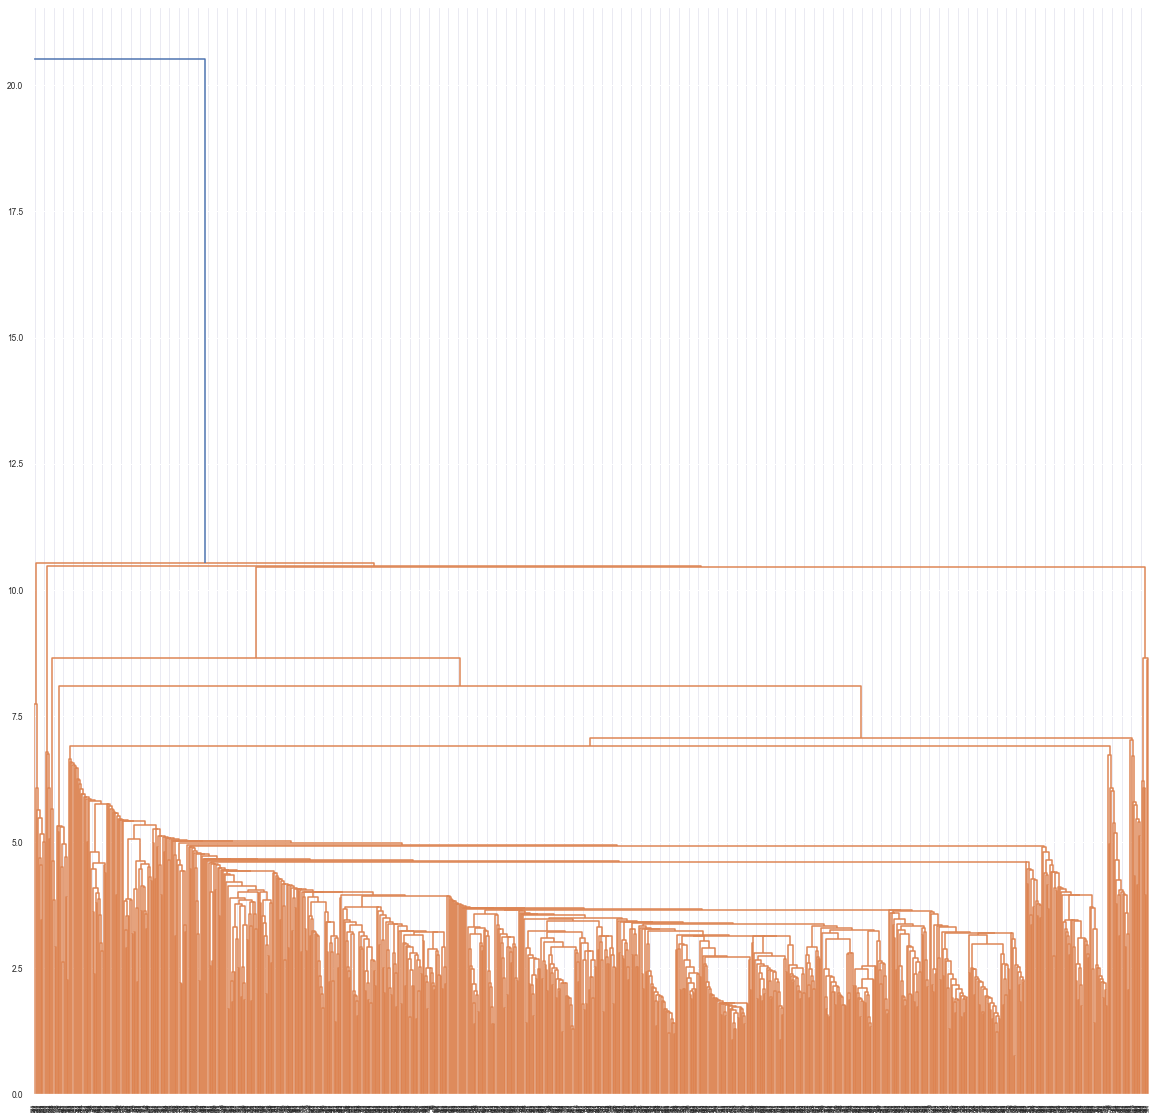

In [122]:
sl_mergings = linkage(X_scaled[:1000], method="single", metric='euclidean')
dendrogram(sl_mergings)
plt.show()

Complete linkage

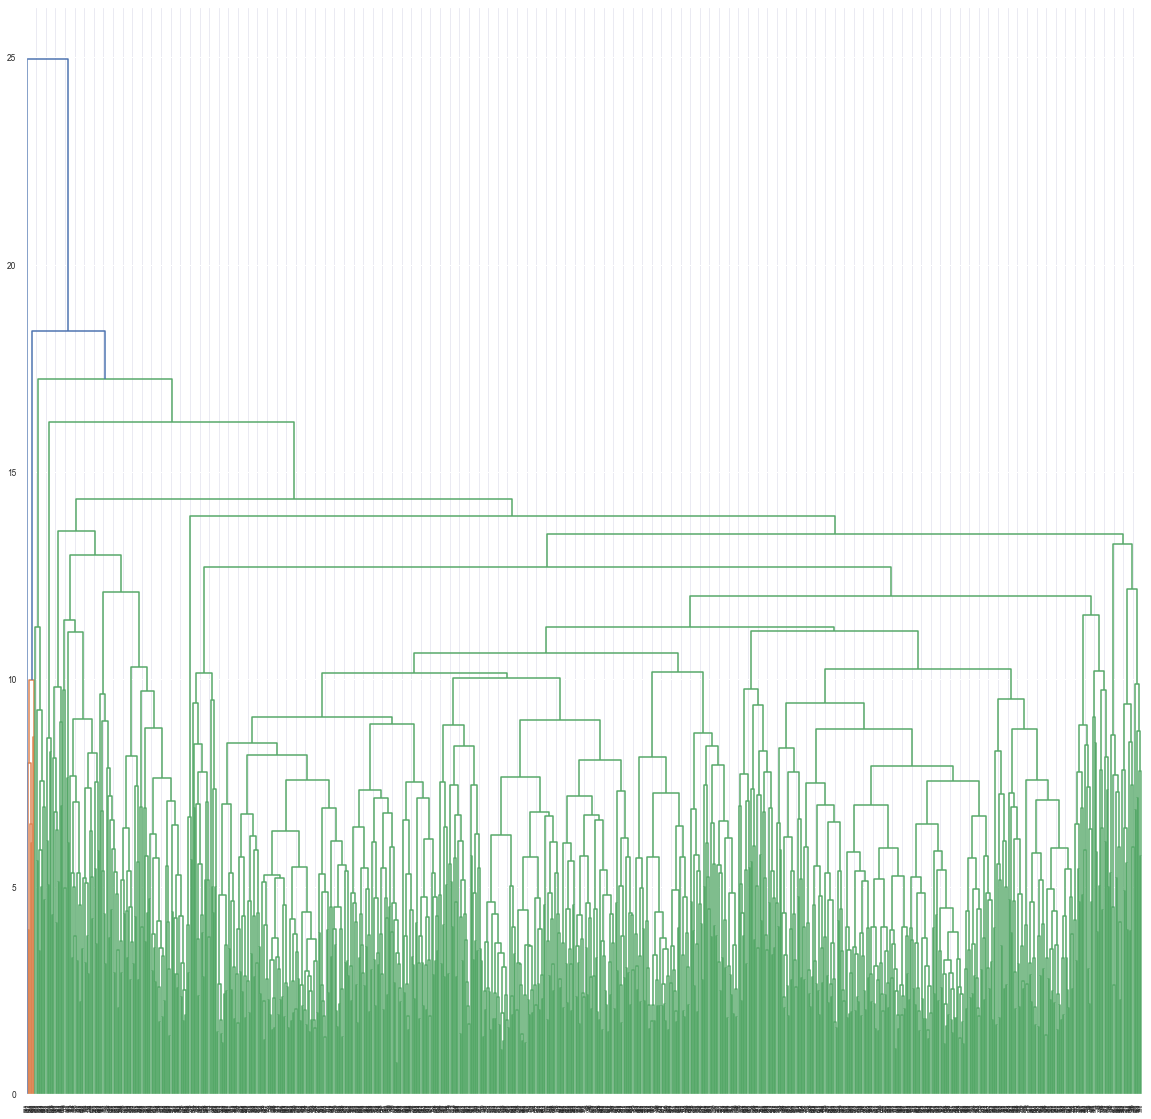

In [123]:
cl_mergings = linkage(X_scaled[:1000], method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.show()

In [124]:
sl_cluster_labels = cut_tree(sl_mergings, n_clusters=4).reshape(-1, )
sl_cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [125]:
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=4).reshape(-1, )
cl_cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [126]:
df_Cluster = df[:1000].copy()

In [127]:
df_Cluster["Hierarchical_Cluster_labels_cl"] = cl_cluster_labels
df_Cluster["Hierarchical_Cluster_labels_sl"] = sl_cluster_labels

In [128]:
df_Cluster.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,loan_status,installment_to_inc,funded_amnt_to_inv,desc_number,K-Means_Cluster_ID,DBScan_Cluster_ID,Hierarchical_Cluster_labels_cl,Hierarchical_Cluster_labels_sl
0,5000.0,36.0,10.65,B,10.0,2,24000.0,Verified,credit_card,27.65,0.0,735.0,1.0,3.0,13648.0,83.7,9.0,0.0,1,6.950000,0.995,78.0,1,-1,0,0
1,2500.0,60.0,15.27,C,1.0,2,30000.0,Source Verified,car,1.00,0.0,740.0,5.0,3.0,1687.0,9.4,4.0,0.0,0,1.680000,1.000,590.0,1,-1,0,0
2,2400.0,36.0,15.96,C,10.0,2,12252.0,Not Verified,small_business,8.72,0.0,735.0,2.0,2.0,2956.0,98.5,10.0,0.0,1,6.562194,1.000,0.0,1,-1,0,0
3,10000.0,36.0,13.49,C,10.0,2,49200.0,Source Verified,other,20.00,0.0,690.0,1.0,10.0,5598.0,21.0,37.0,0.0,1,6.780488,1.000,180.0,1,-1,0,0
4,3000.0,60.0,12.69,B,1.0,2,80000.0,Source Verified,other,17.94,0.0,695.0,0.0,15.0,27783.0,53.9,38.0,0.0,1,0.750000,1.000,306.0,1,-1,0,0


Box charts - (individual) clustering algorithm with variable from dataset.

<AxesSubplot:xlabel='Hierarchical_Cluster_labels_sl', ylabel='emp_length'>

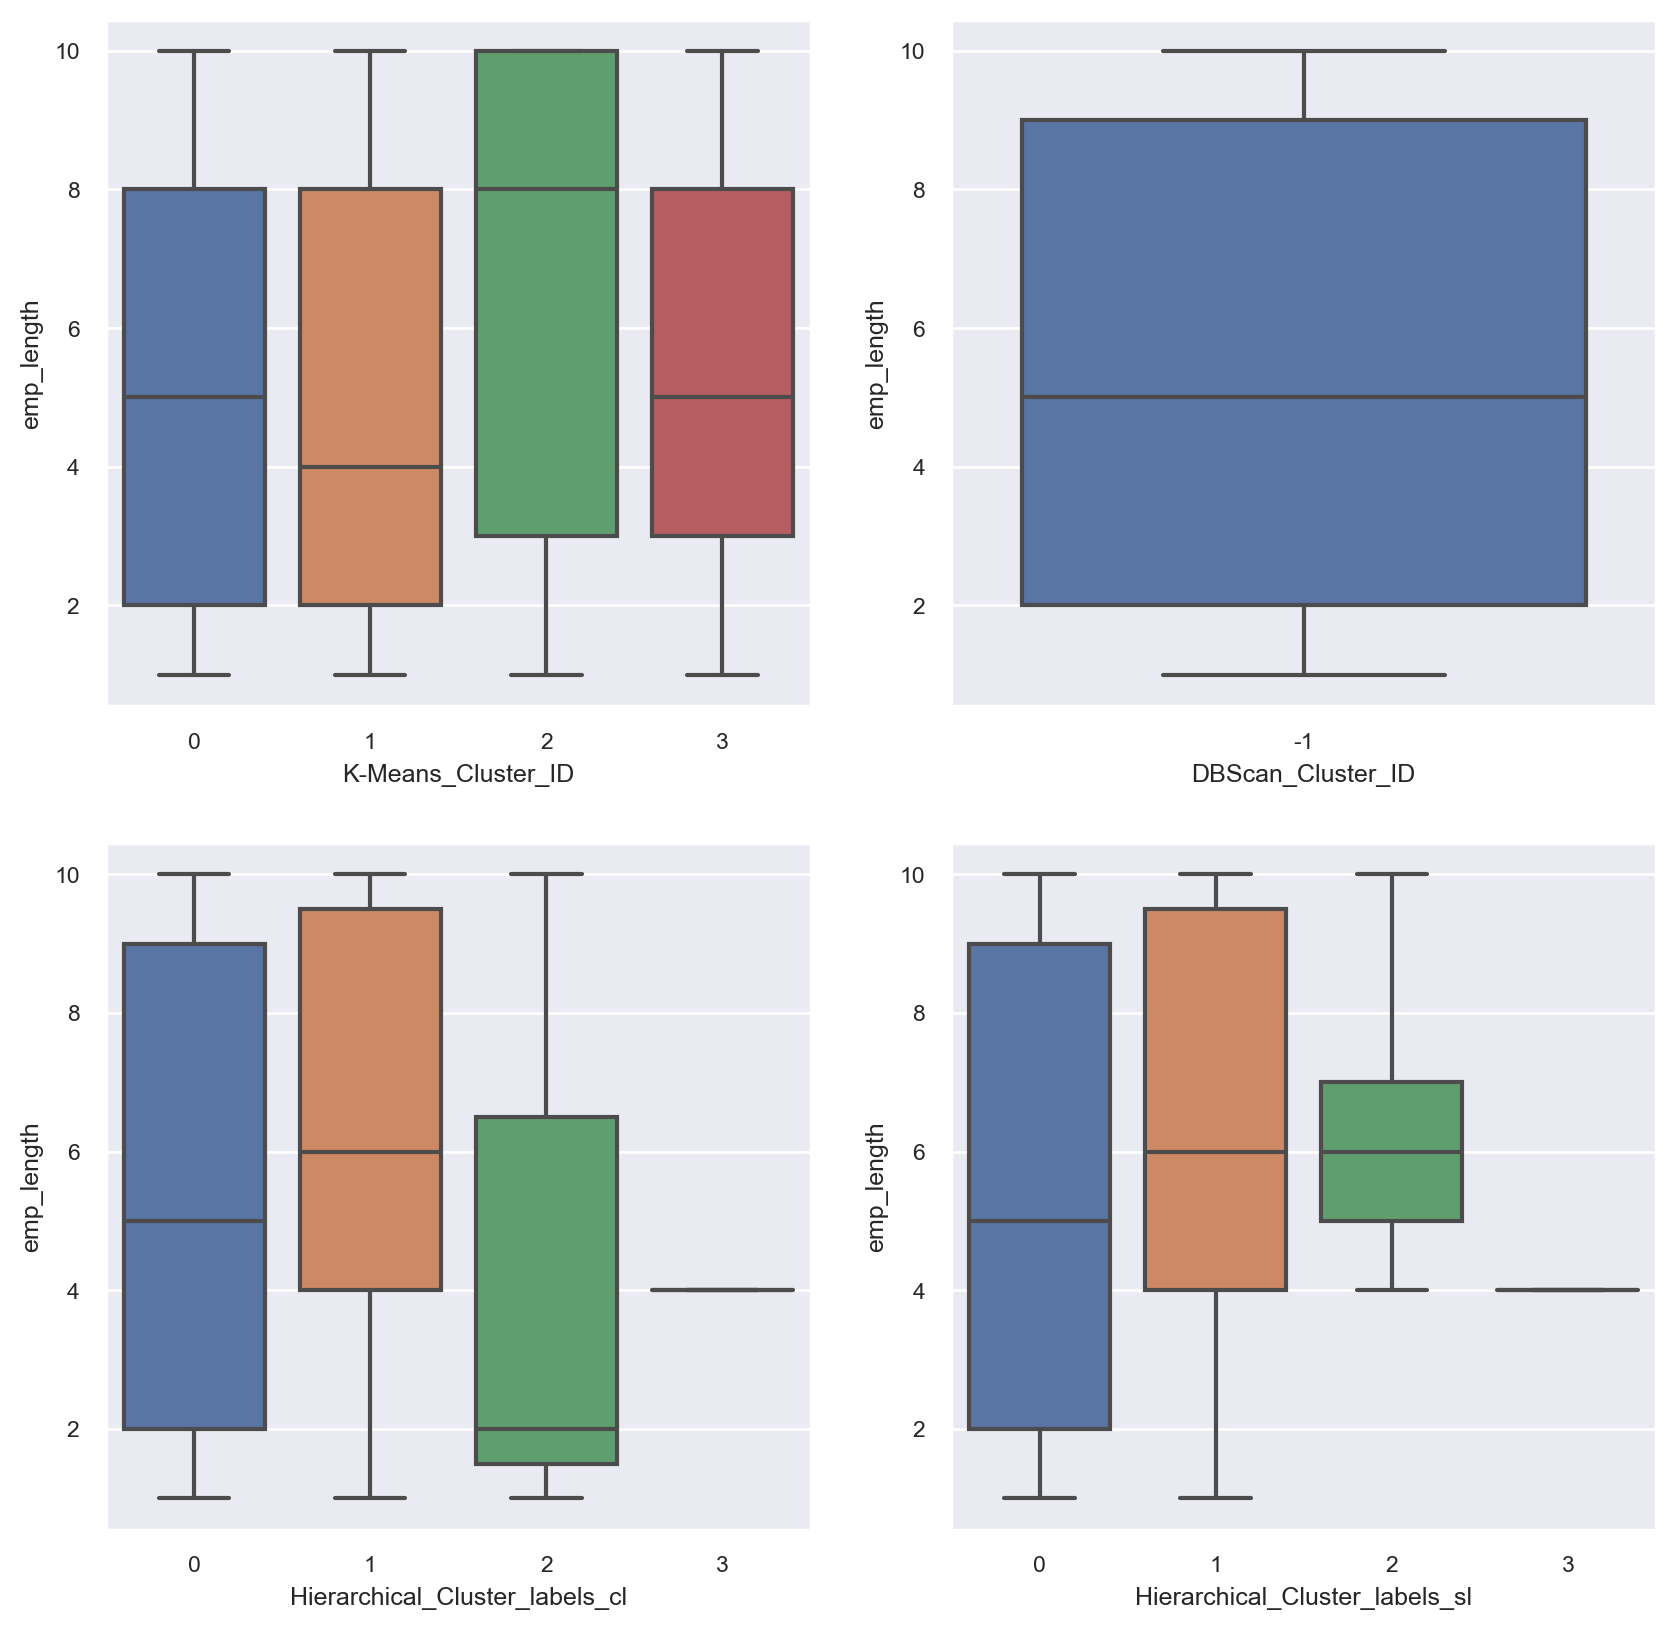

In [129]:
plt.figure(figsize=(10,10), dpi=200)

plt.subplot(2,2,1)
sns.boxplot(x='K-Means_Cluster_ID', y=df_Cluster['emp_length'], data=df_Cluster)

plt.subplot(2,2,2)
sns.boxplot(x='DBScan_Cluster_ID', y=df_Cluster['emp_length'], data=df_Cluster)

plt.subplot(2,2,3)
sns.boxplot(x='Hierarchical_Cluster_labels_cl', y=df_Cluster['emp_length'], data=df_Cluster)

plt.subplot(2,2,4)
sns.boxplot(x='Hierarchical_Cluster_labels_sl', y=df_Cluster['emp_length'], data=df_Cluster)


<AxesSubplot:xlabel='Hierarchical_Cluster_labels_sl', ylabel='annual_inc'>

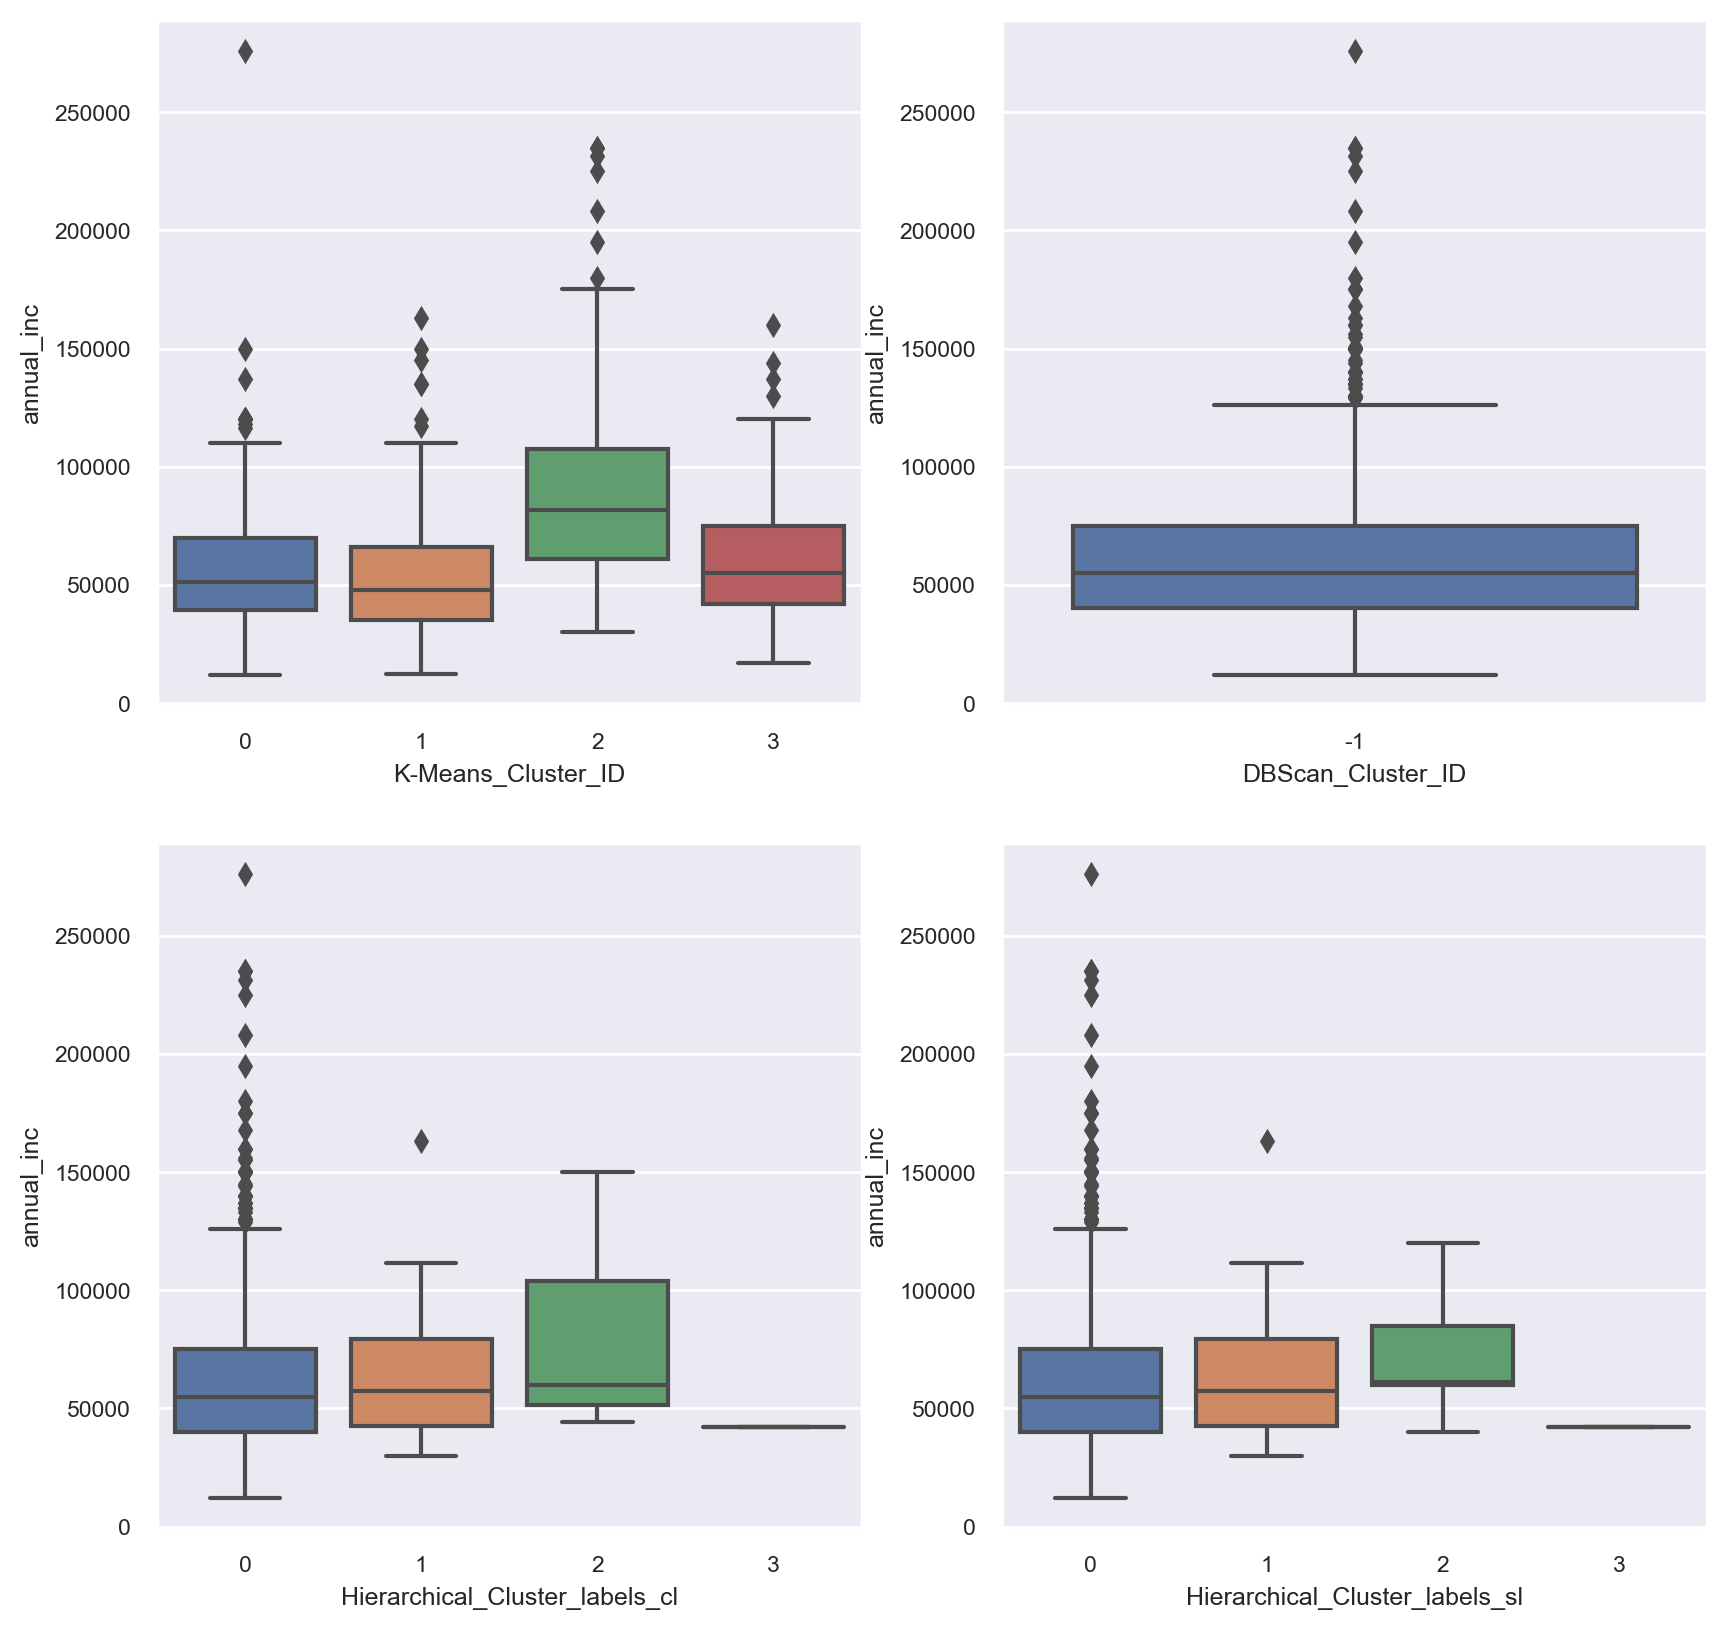

In [130]:
plt.figure(figsize=(10,10), dpi=200)

plt.subplot(2,2,1)
sns.boxplot(x='K-Means_Cluster_ID', y=df_Cluster['annual_inc'], data=df_Cluster)

plt.subplot(2,2,2)
sns.boxplot(x='DBScan_Cluster_ID', y=df_Cluster['annual_inc'], data=df_Cluster)

plt.subplot(2,2,3)
sns.boxplot(x='Hierarchical_Cluster_labels_cl', y=df_Cluster['annual_inc'], data=df_Cluster)

plt.subplot(2,2,4)
sns.boxplot(x='Hierarchical_Cluster_labels_sl', y=df_Cluster['annual_inc'], data=df_Cluster)


<AxesSubplot:xlabel='Hierarchical_Cluster_labels_sl', ylabel='fico_range_low'>

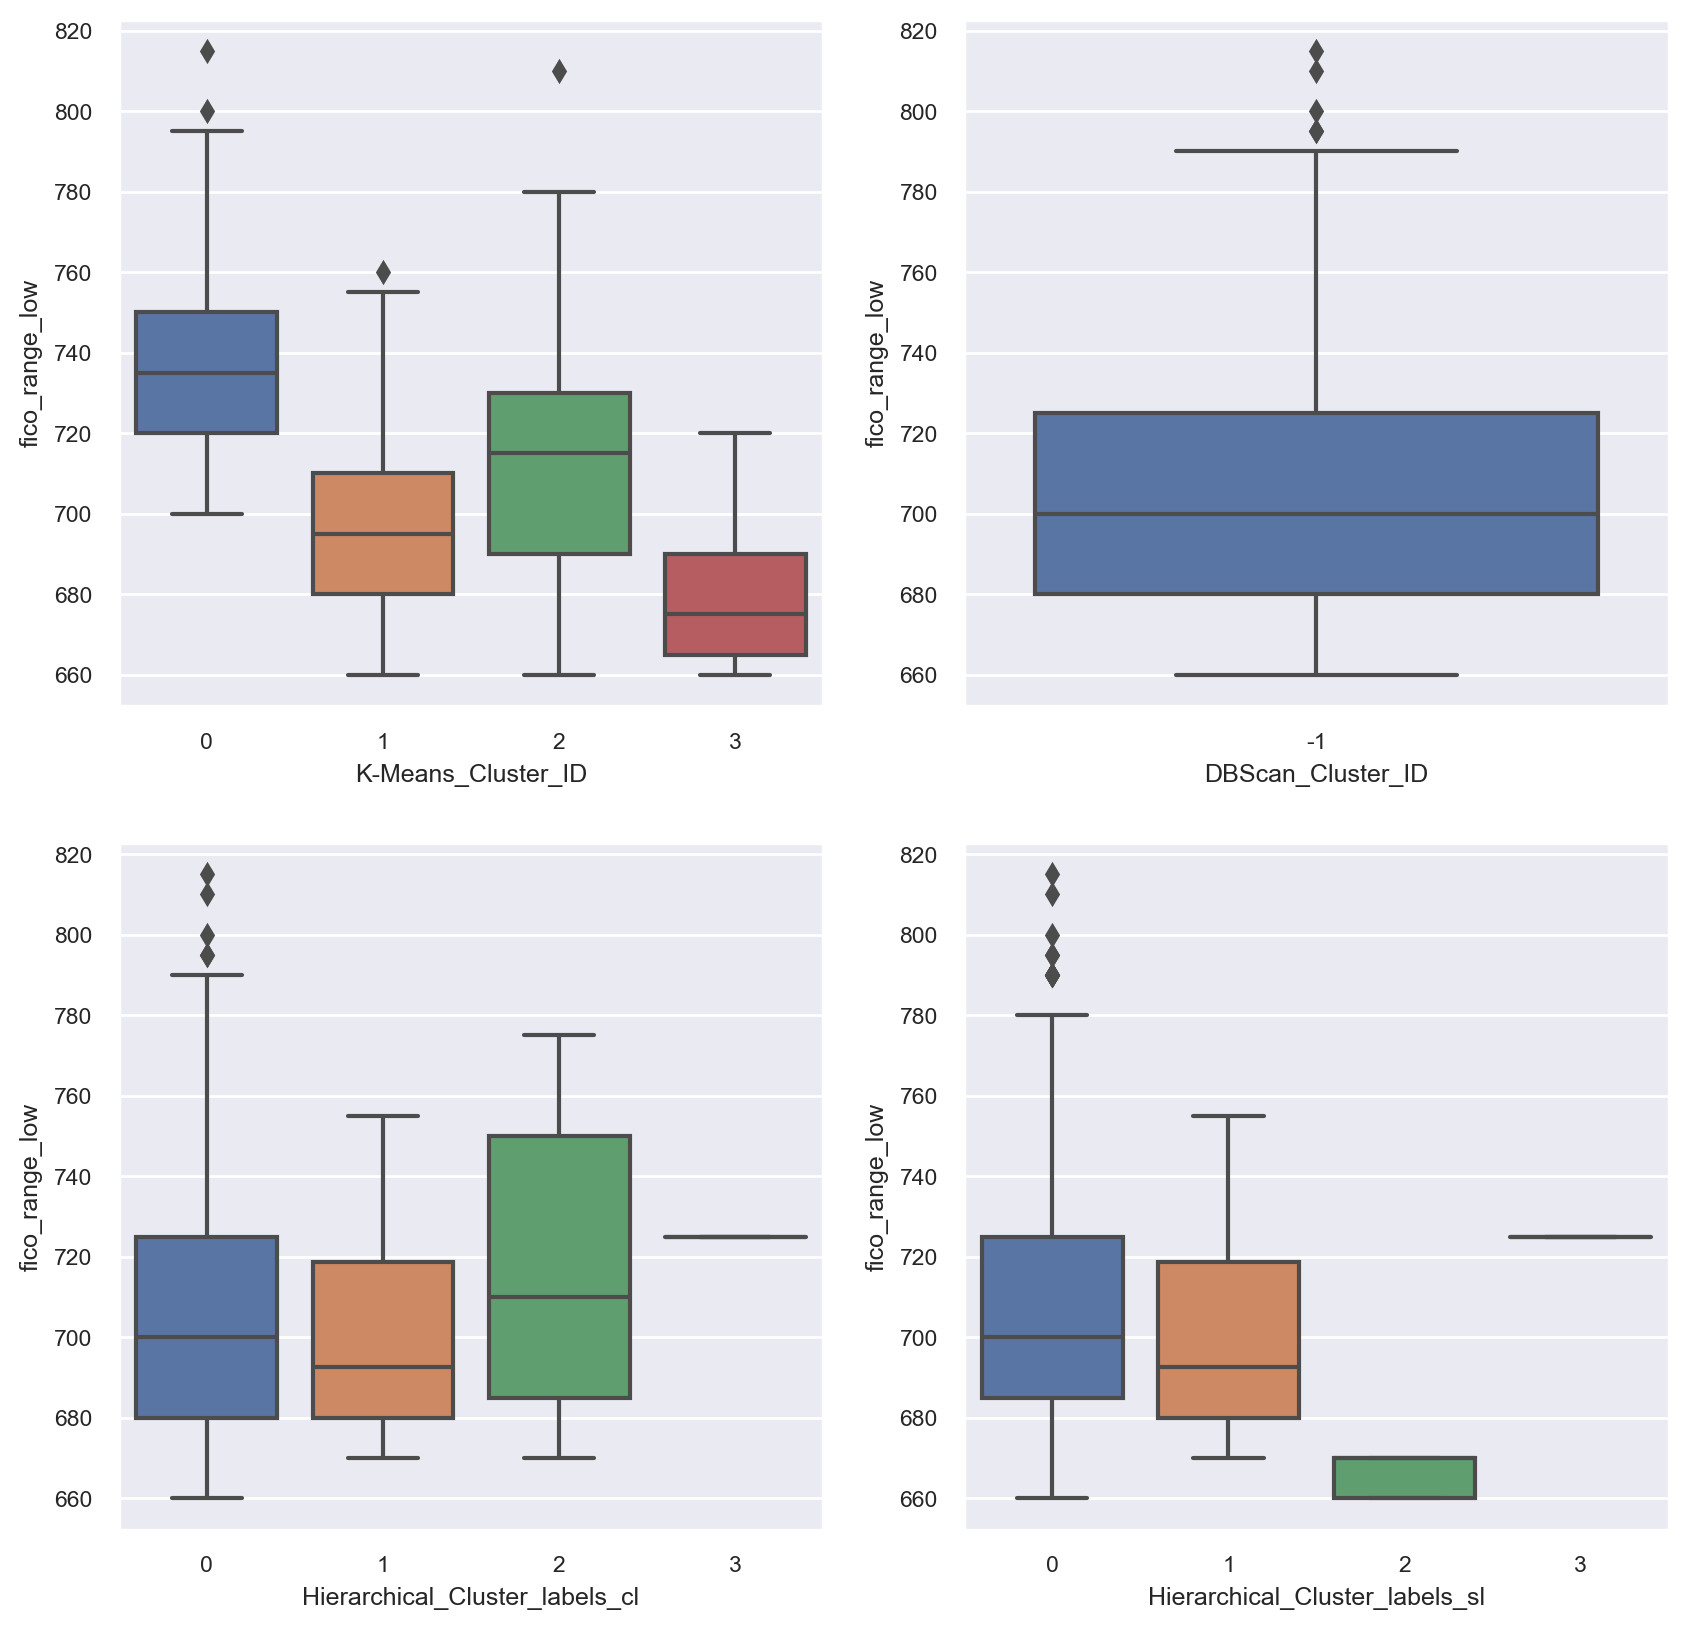

In [131]:
plt.figure(figsize=(10,10), dpi=200)

plt.subplot(2,2,1)
sns.boxplot(x='K-Means_Cluster_ID', y=df_Cluster['fico_range_low'], data=df_Cluster)

plt.subplot(2,2,2)
sns.boxplot(x='DBScan_Cluster_ID', y=df_Cluster['fico_range_low'], data=df_Cluster)

plt.subplot(2,2,3)
sns.boxplot(x='Hierarchical_Cluster_labels_cl', y=df_Cluster['fico_range_low'], data=df_Cluster)

plt.subplot(2,2,4)
sns.boxplot(x='Hierarchical_Cluster_labels_sl', y=df_Cluster['fico_range_low'], data=df_Cluster)

Build models - Logistic Regression, Random Forest, AdaBoost, XGBoost, GradientBoost

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [133]:
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 5),
                      'accuracy':round(accuracy, 5),
                       'roc_auc_score': round(metrics.roc_auc_score(prediction,y_test),5)}
    return performance_data

In [134]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.1)

In [135]:
# Model Logistic Regression
model_log_reg = LogisticRegression() 
model_log_reg.fit(X_scaled_train, y_train.astype("int"))
rl_predictions = model_log_reg.predict(X_scaled_test)
print(classification_report(y_test.astype("int"),rl_predictions))
log_reg_pr= evaluate(rl_predictions,y_test.astype("int"))
log_reg_pr

              precision    recall  f1-score   support

           0       0.48      0.02      0.04       637
           1       0.85      1.00      0.92      3522

    accuracy                           0.85      4159
   macro avg       0.67      0.51      0.48      4159
weighted avg       0.79      0.85      0.78      4159



{'f1-score': 0.91662, 'accuracy': 0.8466, 'roc_auc_score': 0.66596}

In [136]:
# Model Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_scaled_train, y_train.astype("int"))
rf_prediction = rf.predict(X_scaled_test)
print(classification_report(y_test.astype("int"),rf_prediction))
rf_pr = evaluate(rf_prediction,y_test.astype("int"))
print(rf_pr)

              precision    recall  f1-score   support

           0       0.56      0.01      0.03       637
           1       0.85      1.00      0.92      3522

    accuracy                           0.85      4159
   macro avg       0.71      0.51      0.47      4159
weighted avg       0.80      0.85      0.78      4159

{'f1-score': 0.91716, 'accuracy': 0.84732, 'roc_auc_score': 0.70546}


In [137]:
# Model AdaBoost
model_AdaBoost = AdaBoostClassifier(random_state=1)
model_AdaBoost.fit(X_scaled_train, y_train.astype("int"))
model_AdaBoost.score(X_scaled_test,y_test.astype("int"))
AB_predictions = model_AdaBoost.predict(X_scaled_test)
print(classification_report(y_test.astype("int"),AB_predictions))
AdaBoost = evaluate(AB_predictions,y_test.astype("int"))
AdaBoost

              precision    recall  f1-score   support

           0       0.42      0.02      0.04       637
           1       0.85      0.99      0.92      3522

    accuracy                           0.85      4159
   macro avg       0.64      0.51      0.48      4159
weighted avg       0.78      0.85      0.78      4159



{'f1-score': 0.91606, 'accuracy': 0.84564, 'roc_auc_score': 0.63662}

In [138]:
import xgboost as xgb 
# Model XGBoost
model_xgboost = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_xgboost.fit(X_scaled_train, y_train.astype("int"))
model_xgboost.score(X_scaled_test,y_test.astype("int"))
XGB_predictions = model_xgboost.predict(X_scaled_test)
print(classification_report(y_test.astype("int"),XGB_predictions))
xgboost = evaluate(XGB_predictions,y_test.astype("int"))
xgboost

C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:20:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.40      0.00      0.01       637
           1       0.85      1.00      0.92      3522

    accuracy                           0.85      4159
   macro avg       0.62      0.50      0.46      4159
weighted avg       0.78      0.85      0.78      4159



C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'f1-score': 0.91688, 'accuracy': 0.8466, 'roc_auc_score': 0.62357}

In [139]:
from sklearn.ensemble import GradientBoostingClassifier
# Model GradientBoost    
model_GradientBoost = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model_GradientBoost.fit(X_scaled_train, y_train.astype("int"))
model_GradientBoost.score(X_scaled_test,y_test.astype("int"))
GB_predictions = model_GradientBoost.predict(X_scaled_test)
print(classification_report(y_test.astype("int"),GB_predictions))
GradientBoost = evaluate(GB_predictions,y_test.astype("int"))
GradientBoost

C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       637
           1       0.85      1.00      0.92      3522

    accuracy                           0.85      4159
   macro avg       0.42      0.50      0.46      4159
weighted avg       0.72      0.85      0.78      4159



ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [140]:
GB_predictions

array([1, 1, 1, ..., 1, 1, 1])

GradientBoost model predicted only one cluster indicating success - fully paid loan - overfitting towards loan_status of 1.

In [141]:
results = pd.DataFrame({'Method':['Logistic Regression'], 'AUROC': [round(metrics.roc_auc_score(rl_predictions,y_test),5)]},index={'1'})
tempResultsDf1 = pd.DataFrame({'Method':['Random Forest'], 'AUROC': [round(metrics.roc_auc_score(rf_prediction,y_test),5)]},index={'2'})
results = pd.concat([results, tempResultsDf1])
tempResultsDf2 = pd.DataFrame({'Method':['AdaBoost'], 'AUROC': [round(metrics.roc_auc_score(AB_predictions,y_test),5)]},index={'3'})
results = pd.concat([results, tempResultsDf2])
tempResultsDf3 = pd.DataFrame({'Method':['XGBoost'], 'AUROC': [round(metrics.roc_auc_score(XGB_predictions,y_test),5)]},index={'4'})
results = pd.concat([results, tempResultsDf3])
results = results[['Method', 'AUROC']]
results

,Method,AUROC
1,Logistic Regression,0.66596
2,Random Forest,0.70546
3,AdaBoost,0.63662
4,XGBoost,0.62357


Analyzing the table above, the AUROC score is the highest for the XGBoost Model, but none of the above values exceeds the assumed value of 80%, which means that at this stage no model predicted the data with assumed accuracy.

Check the results of models using the data compression method - PCA (Principal Components Analysis)

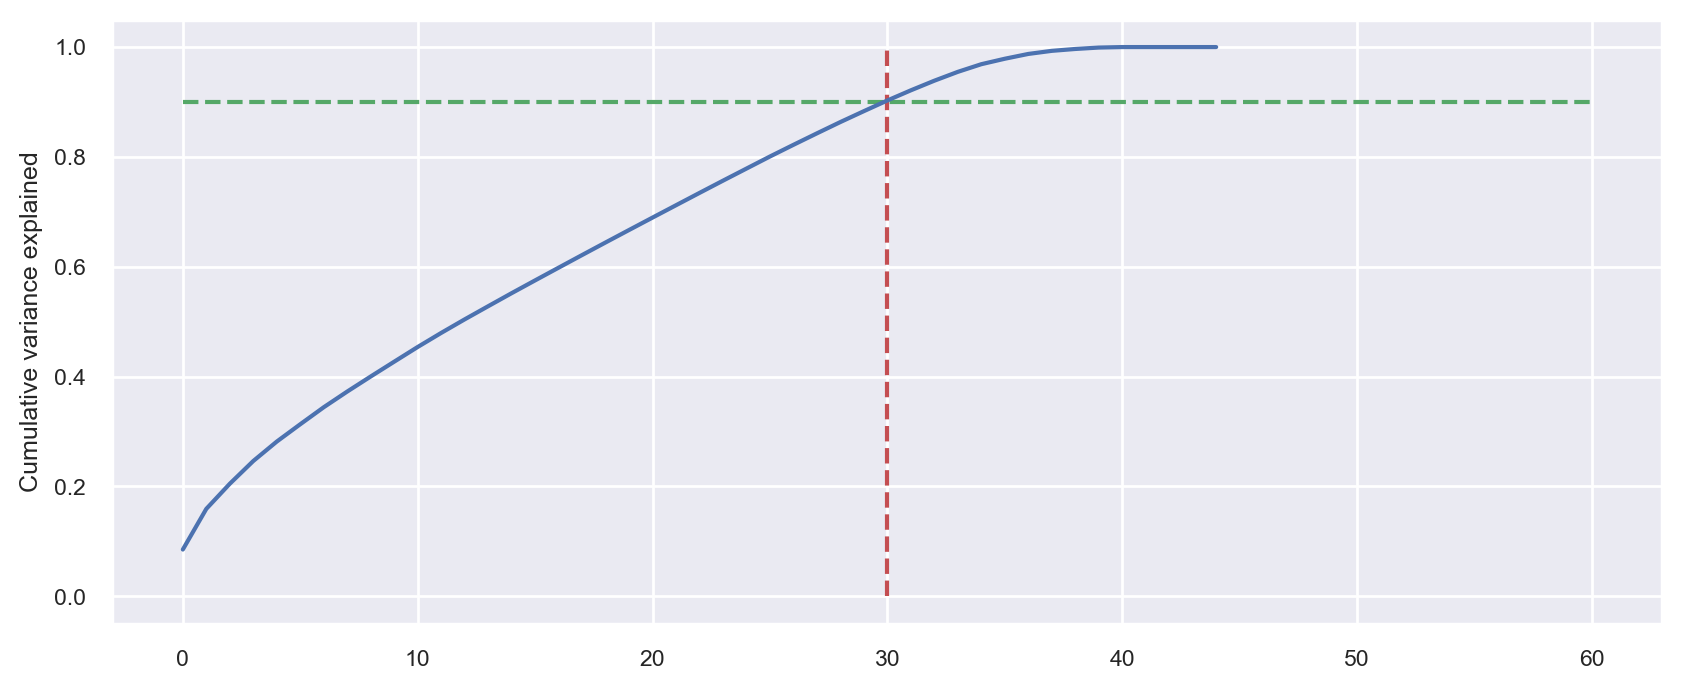

In [142]:
pca = PCA()
pca.fit(X_scaled)
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu
fig = plt.figure(figsize=[10,4],dpi=200)
plt.vlines(x=30, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.90, xmax=60, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [143]:
pca_final = IncrementalPCA(n_components=30) 
X_pca = pca_final.fit_transform(X_scaled)

In [144]:
print(X_scaled.shape)
print(X_pca.shape)

(41585, 45)
(41585, 30)


Leave 30 components, 90% variability

In [145]:
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.30)

In [146]:
# Model Logistic Regression PCA
model_log_reg_pca = LogisticRegression()
model_log_reg_pca.fit(X_pca_train, y_train.astype("int"))
rl_predictions_pca = model_log_reg_pca.predict(X_pca_test)
print(classification_report(y_test.astype("int"),rl_predictions_pca))
log_reg_pr_pca= evaluate(rl_predictions_pca,y_test.astype("int"))
log_reg_pr_pca

              precision    recall  f1-score   support

           0       0.43      0.01      0.03      1844
           1       0.85      1.00      0.92     10632

    accuracy                           0.85     12476
   macro avg       0.64      0.51      0.47     12476
weighted avg       0.79      0.85      0.79     12476



{'f1-score': 0.91966, 'accuracy': 0.85155, 'roc_auc_score': 0.64102}

In [147]:
# Model Random Forest PCA
rf_pca = RandomForestClassifier(n_estimators=100)
rf_pca.fit(X_pca_train, y_train.astype("int"))
rf_prediction_pca = rf_pca.predict(X_pca_test)
print(classification_report(y_test.astype("int"),rf_prediction_pca))
rf_pr_pca = evaluate(rf_prediction_pca,y_test.astype("int"))
print(rf_pr_pca)

              precision    recall  f1-score   support

           0       0.35      0.03      0.05      1844
           1       0.85      0.99      0.92     10632

    accuracy                           0.85     12476
   macro avg       0.60      0.51      0.49     12476
weighted avg       0.78      0.85      0.79     12476

{'f1-score': 0.91756, 'accuracy': 0.84835, 'roc_auc_score': 0.60143}


In [148]:
# Model AdaBoost PCA
model_AdaBoost_pca = AdaBoostClassifier(random_state=1)
model_AdaBoost_pca.fit(X_pca_train, y_train.astype("int"))
model_AdaBoost_pca.score(X_pca_test,y_test.astype("int"))
AB_predictions_pca = model_AdaBoost_pca.predict(X_pca_test)
print(classification_report(y_test.astype("int"),AB_predictions_pca))
AdaBoost_pca = evaluate(AB_predictions_pca,y_test.astype("int"))
AdaBoost_pca

              precision    recall  f1-score   support

           0       0.43      0.02      0.04      1844
           1       0.85      1.00      0.92     10632

    accuracy                           0.85     12476
   macro avg       0.64      0.51      0.48     12476
weighted avg       0.79      0.85      0.79     12476



{'f1-score': 0.91937, 'accuracy': 0.85123, 'roc_auc_score': 0.6438}

In [149]:
import xgboost as xgb #wczytanie
# Model XGBoost PCA
model_xgboost_pca = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_xgboost_pca.fit(X_pca_train, y_train.astype("int"))
model_xgboost_pca.score(X_pca_test,y_test.astype("int"))
XGB_predictions_pca = model_xgboost_pca.predict(X_pca_test)
print(classification_report(y_test.astype("int"),XGB_predictions_pca))
xgboost_pca = evaluate(XGB_predictions_pca,y_test.astype("int"))
xgboost_pca

C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:22:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.43      0.01      0.01      1844
           1       0.85      1.00      0.92     10632

    accuracy                           0.85     12476
   macro avg       0.64      0.50      0.47     12476
weighted avg       0.79      0.85      0.79     12476



{'f1-score': 0.91999, 'accuracy': 0.85196, 'roc_auc_score': 0.64375}

In [150]:
from sklearn.ensemble import GradientBoostingClassifier
# Model GradientBoost PCA
model_GradientBoost_pca = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model_GradientBoost_pca.fit(X_pca_train, y_train.astype("int"))
model_GradientBoost_pca.score(X_pca_test,y_test.astype("int"))
GB_predictions_pca = model_GradientBoost_pca.predict(X_pca_test)
print(classification_report(y_test.astype("int"),GB_predictions_pca))
GradientBoost_pca = evaluate(GB_predictions_pca,y_test.astype("int"))
GradientBoost_pca

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1844
           1       0.85      1.00      0.92     10632

    accuracy                           0.85     12476
   macro avg       0.43      0.50      0.46     12476
weighted avg       0.73      0.85      0.78     12476



C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adusia\anaconda3\lib\site-packages\sklearn\

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Model GradientBoost also predicts only one cluster with using PCA method.

In [151]:
resultsPCA = pd.DataFrame({'Method':['LogisticRegression'], 'AUROC': [round(metrics.roc_auc_score(rl_predictions_pca,y_test),5)]},index={'1'})
tempResultsDf5 = pd.DataFrame({'Method':['Random Forest'], 'AUROC': [round(metrics.roc_auc_score(rf_prediction_pca,y_test),5)]},index={'2'})
resultsPCA = pd.concat([resultsPCA, tempResultsDf5])
tempResultsDf6 = pd.DataFrame({'Method':['AdaBoost'], 'AUROC': [round(metrics.roc_auc_score(AB_predictions_pca,y_test),5)]},index={'3'})
resultsPCA = pd.concat([resultsPCA, tempResultsDf6])
tempResultsDf7 = pd.DataFrame({'Method':['XGBoost'], 'AUROC': [round(metrics.roc_auc_score(XGB_predictions_pca,y_test),5)]},index={'4'})
resultsPCA = pd.concat([resultsPCA, tempResultsDf7])
resultsPCA = resultsPCA[['Method', 'AUROC']]
resultsPCA

,Method,AUROC
1,LogisticRegression,0.64102
2,Random Forest,0.60143
3,AdaBoost,0.64380
4,XGBoost,0.64375


Analyzing the table above, AUROC score is the highest for the Logistic Regression Model, but none of the above values exceeds the assumed value of 80%, which means that despite the use of the PCA method, the results have not improved satisfactorily.

Based on the results of the models, set has unbalanced values, so in the next steps -> balance the target using SMOTE algorithm

In [152]:
from imblearn.over_sampling import SMOTE 
print("Before oversampling: ", Counter(y_train))
SMOTE = SMOTE()
X_SMOTE, y_SMOTE = SMOTE.fit_resample(X_scaled, y)
print("After oversampling: ",Counter(y_SMOTE))
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE,y_SMOTE,test_size=0.1)

Before oversampling:  Counter({1: 24715, 0: 4394})
After oversampling:  Counter({1: 35347, 0: 35347})


After balance the number of successes and failures are equal.

Model a balanced set with each method.

In [153]:
# Model Logistic Regression SMOTE
model_log_reg_S = LogisticRegression() 
model_log_reg_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
rl_predictions_S = model_log_reg_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),rl_predictions_S))
log_reg_pr_S = evaluate(rl_predictions_S,y_SMOTE_test.astype("int"))
log_reg_pr_S

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      3525
           1       0.65      0.64      0.64      3545

    accuracy                           0.65      7070
   macro avg       0.65      0.65      0.65      7070
weighted avg       0.65      0.65      0.65      7070



{'f1-score': 0.64444, 'accuracy': 0.64851, 'roc_auc_score': 0.64865}

In [154]:
# Model Random Forest SMOTE
rf_S = RandomForestClassifier(n_estimators=100)
rf_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
rf_prediction_S = rf_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),rf_prediction_S))
rf_pr_S = evaluate(rf_prediction_S,y_SMOTE_test.astype("int"))
print(rf_pr_S)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      3525
           1       0.89      0.93      0.91      3545

    accuracy                           0.91      7070
   macro avg       0.91      0.91      0.91      7070
weighted avg       0.91      0.91      0.91      7070

{'f1-score': 0.90851, 'accuracy': 0.90636, 'roc_auc_score': 0.9071}


In [155]:
# Model AdaBoost SMOTE
model_AdaBoost_S = AdaBoostClassifier(random_state=1)
model_AdaBoost_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
model_AdaBoost_S.score(X_SMOTE_test,y_SMOTE_test.astype("int"))
AB_predictions_S = model_AdaBoost_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),AB_predictions_S))
AdaBoost_S = evaluate(AB_predictions_S,y_SMOTE_test.astype("int"))
AdaBoost_S

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      3525
           1       0.79      0.83      0.81      3545

    accuracy                           0.80      7070
   macro avg       0.80      0.80      0.80      7070
weighted avg       0.80      0.80      0.80      7070



{'f1-score': 0.80709, 'accuracy': 0.80141, 'roc_auc_score': 0.80228}

In [156]:
import xgboost as xgb 
# Model XGBoost SMOTE
model_xgboost_S = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_xgboost_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
model_xgboost_S.score(X_SMOTE_test,y_SMOTE_test.astype("int"))
XGB_predictions_S = model_xgboost_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),XGB_predictions_S))
xgboost_S = evaluate(XGB_predictions_S,y_SMOTE_test.astype("int"))
xgboost_S

C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:23:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      3525
           1       0.76      0.87      0.81      3545

    accuracy                           0.79      7070
   macro avg       0.80      0.79      0.79      7070
weighted avg       0.80      0.79      0.79      7070



C:\Users\Adusia\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'f1-score': 0.808, 'accuracy': 0.79364, 'roc_auc_score': 0.79989}

In [157]:
from sklearn.ensemble import GradientBoostingClassifier
# Model GradientBoost SMOTE
model_GradientBoost_S = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model_GradientBoost_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
model_GradientBoost_S.score(X_SMOTE_test,y_SMOTE_test.astype("int"))
GB_predictions_S = model_GradientBoost_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),GB_predictions_S))
GradientBoost_S = evaluate(GB_predictions_S,y_SMOTE_test.astype("int"))
GradientBoost_S

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3525
           1       0.73      0.76      0.75      3545

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070



{'f1-score': 0.74532, 'accuracy': 0.73805, 'roc_auc_score': 0.73868}

In [158]:
results_S = pd.DataFrame({'Method':['Logistic Regression'], 'AUROC': [round(metrics.roc_auc_score(rl_predictions_S,y_SMOTE_test),5)]},index={'1'})
tempResultsDf_1 = pd.DataFrame({'Method':['Random Forest'], 'AUROC': [round(metrics.roc_auc_score(rf_prediction_S,y_SMOTE_test),5)]},index={'2'})
results_S = pd.concat([results_S, tempResultsDf_1])
tempResultsDf_2 = pd.DataFrame({'Method':['AdaBoost'], 'AUROC': [round(metrics.roc_auc_score(AB_predictions_S,y_SMOTE_test),5)]},index={'3'})
results_S = pd.concat([results_S, tempResultsDf_2])
tempResultsDf_3 = pd.DataFrame({'Method':['XGBoost'], 'AUROC': [round(metrics.roc_auc_score(XGB_predictions_S,y_SMOTE_test),5)]},index={'4'})
results_S = pd.concat([results_S, tempResultsDf_3])
tempResultsDf_4 = pd.DataFrame({'Method':['GradientBoost'], 'AUROC': [round(metrics.roc_auc_score(GB_predictions_S,y_SMOTE_test),5)]},index={'5'})
results_S = pd.concat([results_S, tempResultsDf_4])
results_S = results_S[['Method', 'AUROC']]
results_S

,Method,AUROC
1,Logistic Regression,0.64865
2,Random Forest,0.90710
3,AdaBoost,0.80228
4,XGBoost,0.79989
5,GradientBoost,0.73868


Analyzing the table above, AUROC score is the highest for the Random Forest Model, but after balancing the target, the Auroc score also increased significantly in other methods, the Auroc score of random forest model is greater than assumed value of 80%, so the final model is Random Forest.

Adjust Random Forest model parameters

In [159]:
# Model Random Forest
rf_S = RandomForestClassifier(n_estimators=30)
rf_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
rf_prediction_S = rf_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),rf_prediction_S))
rf_pr_S = evaluate(rf_prediction_S,y_SMOTE_test.astype("int"))
print(rf_pr_S)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3525
           1       0.89      0.90      0.90      3545

    accuracy                           0.89      7070
   macro avg       0.89      0.89      0.89      7070
weighted avg       0.89      0.89      0.89      7070

{'f1-score': 0.89572, 'accuracy': 0.89448, 'roc_auc_score': 0.89463}


In [160]:
# Model Random Forest
rf_S = RandomForestClassifier(n_estimators=65)
rf_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
rf_prediction_S = rf_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),rf_prediction_S))
rf_pr_S = evaluate(rf_prediction_S,y_SMOTE_test.astype("int"))
print(rf_pr_S)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      3525
           1       0.89      0.92      0.91      3545

    accuracy                           0.90      7070
   macro avg       0.91      0.90      0.90      7070
weighted avg       0.91      0.90      0.90      7070

{'f1-score': 0.9067, 'accuracy': 0.90467, 'roc_auc_score': 0.90528}


In [161]:
# Model Random Forest
rf_S = RandomForestClassifier(n_estimators=100)
rf_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
rf_prediction_S = rf_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),rf_prediction_S))
rf_pr_S = evaluate(rf_prediction_S,y_SMOTE_test.astype("int"))
print(rf_pr_S)

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3525
           1       0.89      0.93      0.91      3545

    accuracy                           0.91      7070
   macro avg       0.91      0.91      0.91      7070
weighted avg       0.91      0.91      0.91      7070

{'f1-score': 0.9108, 'accuracy': 0.90891, 'roc_auc_score': 0.9095}


By modifying the estimators - further improve the Auroc score. The upward trend of the auroc score with the increase in the number of estimators.

Cross-validation

In [162]:
# Model Random Forest
rf_S = RandomForestClassifier(n_estimators=100)
rf_S.fit(X_SMOTE_train, y_SMOTE_train.astype("int"))
rf_prediction_S = rf_S.predict(X_SMOTE_test)
print(classification_report(y_SMOTE_test.astype("int"),rf_prediction_S))
rf_pr_S = evaluate(rf_prediction_S,y_SMOTE_test.astype("int"))
print(rf_pr_S)

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3525
           1       0.90      0.92      0.91      3545

    accuracy                           0.91      7070
   macro avg       0.91      0.91      0.91      7070
weighted avg       0.91      0.91      0.91      7070

{'f1-score': 0.90965, 'accuracy': 0.90792, 'roc_auc_score': 0.90838}


In [163]:
from sklearn.model_selection import KFold, StratifiedKFold
num_folds = 20
seed = 77
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
results1 = cross_val_score(rf_S,X_SMOTE, y_SMOTE, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('Standard Deviation: ',results1.std())

Average accuracy:  0.914858445218764
Standard Deviation:  0.00553022046825088


After cross-validation, the accuracy has increased and the standard deviation is at 0.0055 level.

ROC curve

In [164]:
ns_probs = [0 for _ in range(len(y_SMOTE_test))]

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.967


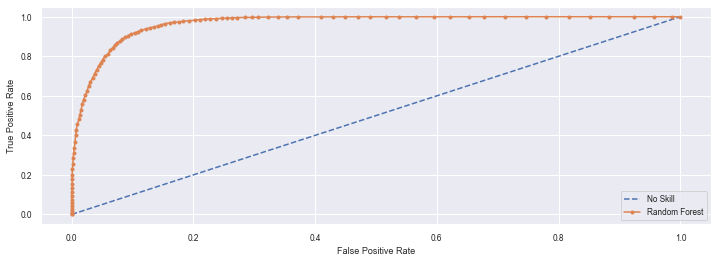

In [165]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = rf_S.predict_proba(X_SMOTE_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_SMOTE_test, ns_probs)
lr_auc = roc_auc_score(y_SMOTE_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_SMOTE_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_SMOTE_test, lr_probs)
plt.figure(figsize=(12,4))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Model tends to the upper left corner, which corresponds to the ideal level of the classifier.

Check Bias-variance tradeoff 

In [166]:
def plot_learning_curve(estimator, title, X_SMOTE, y_SMOTE, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_SMOTE, y_SMOTE, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [167]:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

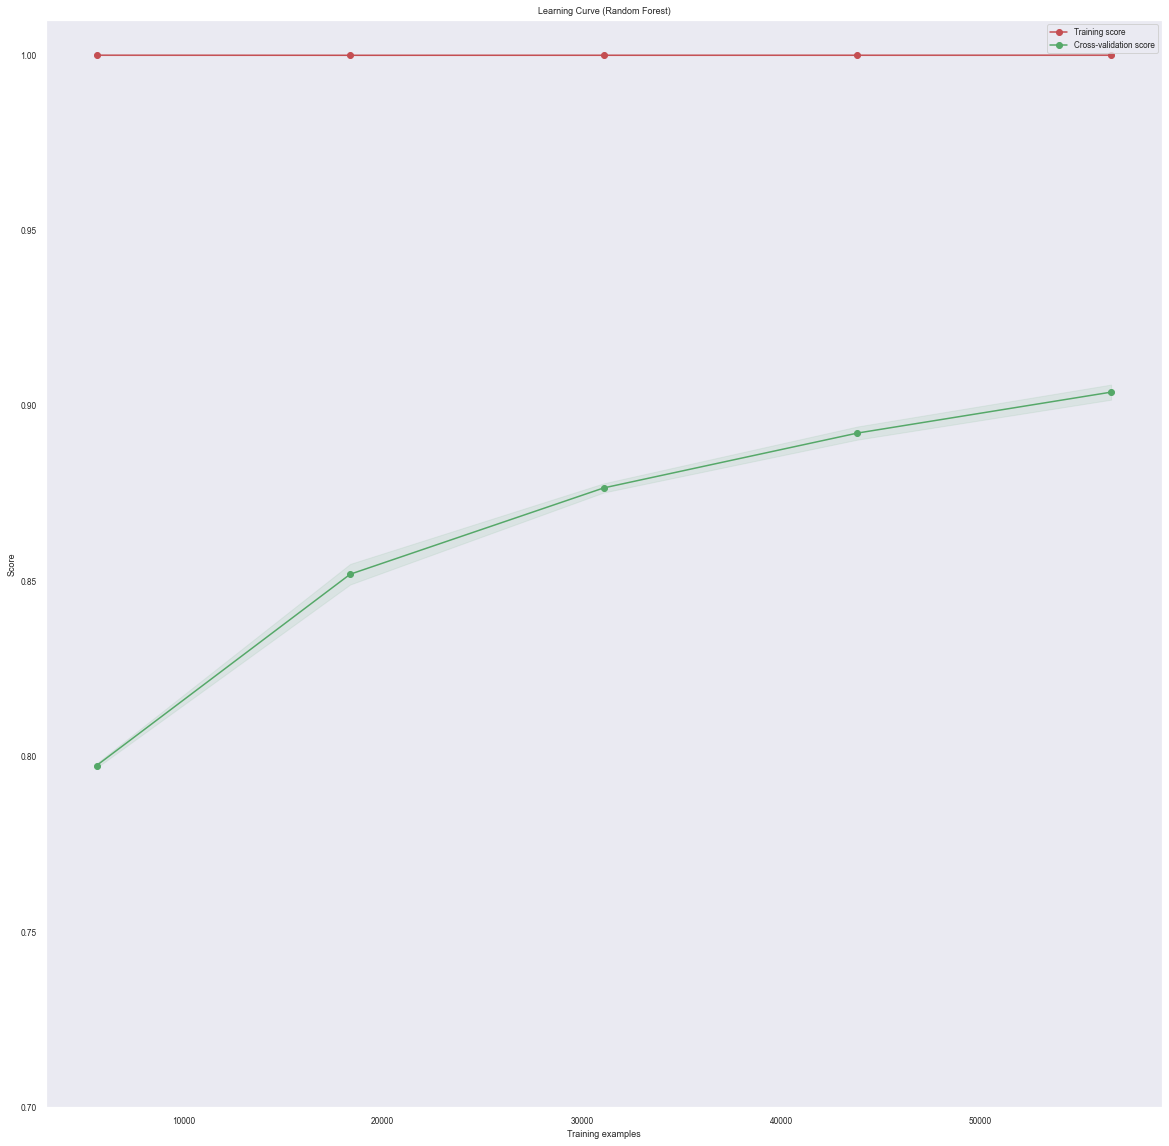

In [168]:
# Bias-variance tradeoff
from sklearn.ensemble import RandomForestClassifier
model_rb = RandomForestClassifier(random_state=0)
plot_learning_curve(model_rb, 'Learning Curve (Random Forest)', X_SMOTE, y_SMOTE, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

Reading the chart, there is an overfiting on the training set - there is an excessive fit, the model is overtrained on the training set. The result on the test set is satisfactory.

Verification of essential characteristics

In [169]:
print('Feature importances: \n', pd.DataFrame(rf_S.feature_importances_,columns=['Imp'],index = X_SMOTE_train.columns))

Feature importances: 
                                           Imp
funded_amnt                          0.044732
term                                 0.037079
int_rate                             0.074687
emp_length                           0.064087
annual_inc                           0.054398
dti                                  0.047134
delinq_2yrs                          0.010044
fico_range_low                       0.062949
inq_last_6mths                       0.118113
open_acc                             0.046519
revol_bal                            0.045257
revol_util                           0.049234
total_acc                            0.044104
pub_rec_bankruptcies                 0.003510
installment_to_inc                   0.046273
funded_amnt_to_inv                   0.047750
desc_number                          0.062717
grade_A                              0.012905
grade_B                              0.008354
grade_C                              0.006078
grade_D    

In [170]:
X_SMOTE_train.shape

(63624, 45)

Model makes decisions based on all the features that have been entered into the model, which agrees with the importance of the added features.